# 0.0. Imports

In [621]:
import pickle
import numpy      as np
import pandas     as pd
import boruta     as bt
import seaborn    as sns
import scikitplot as skplt

from matplotlib              import pyplot          as plt
from matplotlib.artist       import Artist          as art

from sklearn                 import metrics         as mt
from sklearn                 import preprocessing   as pp
from sklearn                 import linear_model    as lm
from sklearn                 import model_selection as ms
from sklearn                 import ensemble        as en
from sklearn                 import neighbors       as nh
from xgboost                 import XGBClassifier
from lightgbm                import LGBMClassifier
from catboost                import CatBoostClassifier
from lightgbm                import LGBMClassifier
from skopt                   import BayesSearchCV




## 0.1. Helper Function

In [779]:
def jupyter_settings():
    """
    Configurações para visualizações no Jupyter Notebook.

    Retorna:
    - Nenhum (apenas configura as opções de visualização)
    """

    from IPython.core.display import HTML
    %matplotlib inline
    
    plt.style.use('Solarize_Light2')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
   
    sns.set_palette('Set2')
    sns.set_style("darkgrid")
 
 
def conversion_plots(df, feature):
    """
    Plota um gráfico de barras para visualizar a conversão em relação a uma determinada feature.

    Argumentos:
    - df: o DataFrame contendo os dados
    - feature: a feature para a qual deseja-se visualizar a conversão

    Retorna:
    - Nenhum (apenas plota o gráfico)
    """
   
    # Define o estilo do seaborn para ocultar as linhas de grade nos eixos
    sns.set_style({'axes.grid': False})

    # Conta o número total de ocorrências para cada valor da feature
    total = df.groupby(feature)[['id']].count().reset_index()  
    
    # Conta o número de ocorrências onde a resposta é igual a 1 para cada valor da feature
    response1 = df[df['response'] == 1].groupby(feature)[['id']].count().reset_index().rename(columns={'id': 'interested'})  
    
    # Combina os dados de contagem total e interessados em uma tabela, preenchendo valores ausentes com zero
    total = total.merge(response1, how='left', on=feature).fillna(0)  

    # Calcula o percentual de interessados em relação ao total de ocorrências
    total['perc'] = (total.interested / total.id) * 100  
    

    # Plota um gráfico de barras com a feature no eixo x e o percentual no eixo y
    fig, ax = plt.subplots()  
    sns.barplot(data=total, x=feature, y='perc', ax=ax)  
    plt.ylim(0, 100)  
    ax.set_ylabel('Percentual')  
    ax.set_xlabel(feature)  
    
    # Formata o rótulo com o percentual formatado com duas casas decimais
    for i in total.index:
        label = f"{total.loc[i, 'perc']:.2f}%"  
        y = total.loc[i, 'perc']  
        plt.annotate(label, (i, y), ha='center', va='bottom', rotation=90)  # Adiciona rótulos aos pontos do gráfico
        
    plt.show()  



def line_plot(df, feature):
    """
    Plota um gráfico de linhas para visualizar a distribuição de uma feature em relação à resposta.

    Argumentos:
    - df: o DataFrame contendo os dados
    - feature: a feature a ser visualizada

    Retorna:
    - Nenhum (apenas plota o gráfico)
    """

    # Filtra os dados para cada resposta
    response_0 = df.loc[df['response'] == 0, feature]
    response_1 = df.loc[df['response'] == 1, feature]
    
    # Plota as curvas de densidade das idades para cada resposta
    sns.distplot(response_0, hist=False, kde=True, label='Response 0')
    sns.distplot(response_1, hist=False, kde=True, label='Response 1')
    
    # Configurações adicionais do gráfico
    plt.xlabel(feature)
    plt.ylabel('Interessed')
    plt.title(f'Distribuição de {feature} por Resposta')
    plt.legend()
    
    plt.show()


def calculate_metrics(models, x_train, y_train, x_val, y_val):
    """
    Calcula as métricas de desempenho para vários modelos.

    Argumentos:
    - models: uma lista de modelos a serem avaliados
    - x_train: os dados de treinamento
    - y_train: os rótulos de treinamento
    - x_val: os dados de validação
    - y_val: os rótulos de validação

    Retorna:
    - Uma lista de dicionários contendo os resultados das métricas de desempenho para cada modelo testado.
    """

    results = [] 
   
    for model in models:
        model_name = model.__class__.__name__  # Obtém o nome da classe do modelo
        model.fit(x_train, y_train)  # Treina o modelo com os dados de treinamento
        y_pred = model.predict(x_val)  # Faz previsões com o modelo nos dados de validação
        
        precision = mt.precision_score(y_val, y_pred)  # Calcula a métrica de precisão
        recall = mt.recall_score(y_val, y_pred)  # Calcula a métrica de recall
        f1 = mt.f1_score(y_val, y_pred)  # Calcula a métrica F1-score
        
        # Cria um dicionário com os resultados das métricas para o modelo atual
        result = {
            'Model': model_name,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        }  
        
        results.append(result)  
    
    return results  


def perform_cross_validation(models, x_train, y_train, scoring=['precision', 'recall', 'f1']):
    """
    Realiza a validação cruzada para avaliar o desempenho de diferentes modelos.

    Argumentos:
    - models: uma lista de modelos a serem avaliados
    - x_train: os dados de treinamento
    - y_train: os rótulos de treinamento
    - scoring: uma lista de métricas de avaliação. As métricas padrão são ['precision', 'recall', 'f1'].

    Retorna:
    - Uma lista de dicionários contendo os resultados das métricas para cada modelo testado.
    """

    # Lista para armazenar os resultados das métricas de validação cruzada
    results = []  
    
    for i, model in enumerate(models):
        # Realiza a validação cruzada com o modelo fornecido
        cv_results = ms.cross_validate(model, x_train, y_train, scoring=scoring, cv=5) 
        # Obtém o nome da classe do modelo 
        model_name = model.__class__.__name__  
        
        # Calcula a média e o desvio padrão da métrica de precisão nos conjuntos de validação
        precision_mean = cv_results['test_precision'].mean()  
        precision_std = cv_results['test_precision'].std()  
        
        # Calcula a média e o desvio padrão da métrica de recall nos conjuntos de validação
        recall_mean = cv_results['test_recall'].mean()  
        recall_std = cv_results['test_recall'].std()  
        
        # Calcula a média e o desvio padrão da métrica de F1 score nos conjuntos de validação
        f1_mean = cv_results['test_f1'].mean()  
        f1_std = cv_results['test_f1'].std() 
        

        # Cria um dicionário com os resultados das métricas para o modelo atual
        result = {
            'Model': model_name,
            'Precision Mean': precision_mean,
            'Precision Std': precision_std,
            'Recall Mean': recall_mean,
            'Recall Std': recall_std,
            'F1-Score Mean': f1_mean,
            'F1-Score Std': f1_std
        }  
        
        results.append(result) 
    
    return results 


def precision_at_k(data, k=10):
    """
    Calcula a precisão no k-ésimo item recomendado.
    
    Argumentos:
    - data: um DataFrame contendo as colunas "response" (1 para resposta relevante e 0 caso contrário) e 
      "ranking" (posição do item recomendado)
    - k: o valor de k para o qual se deseja calcular a precisão. O valor padrão é 10.
    
    Retorna:
    - A precisão no k-ésimo item recomendado e o DataFrame "data" atualizado com a coluna "precision_at_k"
    """
    # Reseta o índice do DataFrame "data"
    data = data.reset_index(drop=True)
    
    # Cria a coluna "ranking" com base no índice do DataFrame
    data['ranking'] = data.index + 1
    
    # Calcula a precisão acumulada
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    # Retorna a precisão no k-ésimo item recomendado e o DataFrame "data" atualizado
    return (data.loc[k, 'precision_at_k'], data)


def recall_at_k(data, k=15):
    """
    Calcula o recall no k-ésimo item recomendado.
    
    Argumentos:
    - data: um DataFrame contendo as colunas "response" (1 para resposta relevante e 0 caso contrário) e 
      "ranking" (posição do item recomendado)
    - k: o valor de k para o qual se deseja calcular o recall. O valor padrão é 15.
    
    Retorna:
    - O recall no k-ésimo item recomendado e o DataFrame "data" atualizado com a coluna "recall_at_k"
    """
    # Reseta o índice do DataFrame "data"
    data = data.reset_index(drop=True)
    
    # Cria a coluna "ranking" com base no índice do DataFrame
    data['ranking'] = data.index + 1
    
    # Calcula o recall acumulado
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    # Retorna o recall no k-ésimo item recomendado e o DataFrame "data" atualizado
    return (data.loc[k, 'recall_at_k'], data)

def get_score(data, k=2000):
    """
    Calcula a pontuação do modelo para um determinado cliente na posição k.

    Parâmetros:
    - data: DataFrame contendo os dados dos clientes e suas pontuações.
    - k: Posição do cliente para o qual a pontuação deve ser obtida. O valor padrão é 2000.

    Retorna:
    - A pontuação do modelo para o cliente na posição k.
    """
    data = data.reset_index(drop=True)
    score = data.loc[k, 'score']
    return score


def profit_dataframe(data, insurance_price, cost):
    """
    Calcula o dataframe de lucro com base nos dados fornecidos.

    Parâmetros:
    - data: DataFrame contendo os dados dos clientes e suas respostas.
    - insurance_price: Preço do seguro por cliente.
    - cost: Custo por cliente.

    Retorna:
    - DataFrame contendo as informações de lucro para diferentes porcentagens de amostra.
    
    Comentários:
    Esta função calcula o dataframe de lucro com base nos dados fornecidos, o preço do seguro e o custo por cliente.

    Primeiro, são extraídas informações importantes dos dados, como o número total de clientes positivos (number_of_positives)
    e o tamanho da população (population_size), que é o número total de clientes.

    Em seguida, é criada uma lista de valores de k (k_numbers) para amostrar diferentes porcentagens do conjunto de dados.
    Esses valores são calculados com base no tamanho da população e são arredondados para duas casas decimais (k_percents).

    A função utiliza as funções recall_at_k() e get_score() para calcular as métricas de recall e pontuação para cada valor de k.
    Os resultados são armazenados nas listas recalls e score.

    Com base nas métricas e nos parâmetros fornecidos, a função calcula os lucros e as linhas de base correspondentes para cada
    valor de k. Os cálculos são feitos utilizando as fórmulas fornecidas.

    Por fim, todas as informações são organizadas em um DataFrame (df_profit) com as colunas 'x_nsamples', 'y_profit', 'y_baseline'
    e 'score', que representam a porcentagem de amostra, o lucro com o modelo, o lucro da linha de base e a pontuação, respectivamente.

    O DataFrame de lucro é retornado como resultado da função.
    """
    number_of_positives = data['response'].sum()
    population_size = data.shape[0]
    k_numbers = np.arange(data.shape[0] // 100, data.shape[0], data.shape[0] // 100)
    k_percents = np.round((k_numbers / data.shape[0]), 2)

    recalls = np.array([recall_at_k(data, k=k_number)[0] for k_number in k_numbers])
    score = np.array([get_score(data, k=k_number) for k_number in k_numbers])
    profits = (recalls * number_of_positives * insurance_price) - (k_percents * population_size * cost)
    baselines = (k_percents * number_of_positives * insurance_price) - (k_percents * population_size * cost)

    df_profit = pd.DataFrame({
        'x_nsamples': k_percents,
        'y_profit': np.round(profits, 2),
        'y_baseline': np.round(baselines, 2),
        'score': score
    })

    return df_profit

def line_profit(df_profit, title='Best K for the Biggest Profit'):
    """
    Plota um gráfico de linha com os dados de lucro.

    Parâmetros:
    - df_profit: DataFrame contendo as informações de lucro.
    - title: Título do gráfico.

    Retorna:
    - Objeto Axes do matplotlib contendo o gráfico.
    """
    plt.figure(figsize=(12, 6))
    max_profit = df_profit.loc[df_profit['y_profit'].idxmax()]
    x_value, y_value, score = max_profit[['x_nsamples', 'y_profit', 'score']].astype(float)
    y_min_value = int(df_profit['y_profit'].min() * 1.1)
    y_baseline = int(max_profit['y_baseline'])

    text = f'Percentage of sample = {x_value}\nProfit = {y_value}\nScore = {round(score,2)}'
    text_baseline = f'Percentage of sample = {x_value}\nProfit = {y_baseline}'

    ax = sns.lineplot(x='x_nsamples', y='y_baseline', data=df_profit, marker='o', fillstyle='none',
                      markeredgewidth=1, markeredgecolor='black', markevery=[max_profit.name], label='Baseline')

    sns.lineplot(x='x_nsamples', y='y_profit', data=df_profit, marker='o', fillstyle='none',
                 markeredgewidth=1, markeredgecolor='black', markevery=[max_profit.name], ax=ax, label='With Model')

    ax.set_xlabel('Percentage of sample')
    ax.set_ylabel('Profit')
    ax.set_title(title)
    ax.set_ylim([y_min_value, y_value * 1.5])
    ax.text(x_value, (y_value * 1.2), text, horizontalalignment='center', verticalalignment='center', fontsize=10)
    ax.text(x_value, (y_baseline + (((0.2 * y_baseline) ** 2) ** (1 / 2))), text_baseline,
            horizontalalignment='center', verticalalignment='center', fontsize=10)

    plt.tight_layout()

    return ax

def profit_bar(df_profit, data, insurance_price, cost, title='Profit: Selected Customers X All Customers'):
    """
    Plota um gráfico de barras com as informações de lucro.

    Parâmetros:
    - df_profit: DataFrame contendo as informações de lucro.
    - data: DataFrame contendo os dados originais.
    - insurance_price: Preço do seguro.
    - cost: Custo por cliente.
    - title: Título do gráfico.

    Retorna:
    - Objeto Axes do matplotlib contendo o gráfico.
    """

    y_value = np.max(df_profit['y_profit'])

    interested_customers = np.sum(data['response'])
    revenue = interested_customers * insurance_price
    all_cost = data.shape[0] * cost
    profit = revenue - all_cost

    #plt.figure(figsize=(12,6))
    bar_plot = sns.barplot(x=['Selected Customers', 'All Customers'], y=[y_value, profit])
    bar_plot.set_title(title)
    bar_plot.set_ylabel('Profit')

    for rect, val in zip(bar_plot.patches, [y_value, profit]):    
        perc = np.round((val/profit*100), 2)
        bar_plot.annotate(f"{perc}% ({val})", (rect.get_x() + rect.get_width() / 2., rect.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                    textcoords='offset points')

    plt.tight_layout()

    return bar_plot


In [638]:
jupyter_settings()

## 0.2. Load dataset

In [499]:
# # # Define as variáveis de conexão do PostgreSQL
# host = "comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com"
# port = "5432"
# database = "comunidadedsdb"
# user = "member"
# password = "cdspa"

# # Conecta-se ao PostgreSQL usando a biblioteca psycopg2
# conn = pg.connect(host=host, port=port, database=database, user=user, password=password)

# # Define a query que seleciona todos os registros de três tabelas em um único resultado
# query = """
#             SELECT *
#             FROM pa004.users u 
#                 INNER JOIN pa004.vehicle v ON (u.id = v.id)
#                 INNER JOIN pa004.insurance i ON (u.id = i.id)
#         """

# # Executa a query e armazena o resultado em um DataFrame do pandas
# df_raw = pd.read_sql(query, conn)

# conn.close()

In [500]:
df_raw = pd.read_csv('../src/data/train.csv')

In [501]:
df_raw.head()

id  Gender  Age  Driving_License  Region_Code  Previously_Insured Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  Response
0  141227  Female   25                1          2.0                   0    < 1 Year            Yes          2630.0                 152.0      227         0
1  282256  Female   45                1         28.0                   0    1-2 Year            Yes         26320.0                  26.0      193         0
2  280002  Female   60                1         37.0                   0    1-2 Year            Yes          2630.0                 156.0      177         0
3  230151    Male   48                1         50.0                   1    1-2 Year             No        117793.0                   8.0      155         0
4  372200    Male   35                1         46.0                   0    1-2 Year            Yes         41217.0                  26.0      271         1

In [502]:
# train, test = ms.train_test_split(df_raw, test_size=0.2, stratify=df_raw.Response, shuffle=True, random_state=25)

In [503]:
# train.shape

In [504]:
# train.to_csv('../src/data/train.csv', index=False)

In [505]:
# test.shape

In [506]:
# test.to_csv('../src/data/test.csv', index=False)

# 1.0. Data Description

|      Nome              |         Significado                                |
|------------------------|---------------------------------------------------|
|       id               |       ID único por cliente                         |
|      gender            |      Gênero do cliente                             |
|      age               |      Idade                                         |
|  region_code           |      Código da região                              |
| policy_sales_channel   |      Código para os canais de contato com o cliente|
|  driving_license       |      Se o cliente possui habilitação               |
|  vehicle_age           |      Idade do veículo                              |
|  vehicle_damage        |      Se o veículo já foi danificado                |
| previously_insured     |      Se o cliente já possui seguro de carro        |
| annual_premium         |      Valor anual do seguro de saúde do cliente     |
|      vintage           |      Número de dias em que o cliente tem o seguro  |
|      response          |      Resposta do cliente em relação ao interesse   |


In [507]:
df1 = train.copy()

In [508]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [509]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
            'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

# rename 
df1.columns = cols_new


## 1.2. Data Dimensions

In [510]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 79923
Number of Cols: 12


## 1.3. Data Types

In [511]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Change Types

## 1.5. Check NA

In [512]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.6. Data Descriptive 

In [513]:
# Separando atributos numéricos e categóricos do dataframe

# Seleciona apenas colunas do tipo numérico
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

# Seleciona todas as colunas que não são numéricas ou datas
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.6.1. Numerical Attributes

In [514]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatena todos os dataframes criados anteriormente
metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()

# Renomeia as colunas
metrics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

metrics



attributes     min       max     range           mean    median            std       skew    kurtosis
0                    id     4.0  381108.0  381104.0  190429.757504  190010.0  109999.925801   0.004057   -1.198108
1                   age    20.0      85.0      65.0      38.806964      36.0      15.505911   0.672747   -0.568704
2       driving_license     0.0       1.0       1.0       0.997560       1.0       0.049335 -20.171248  404.889389
3           region_code     0.0      52.0      52.0      26.368492      28.0      13.204972  -0.113382   -0.864546
4    previously_insured     0.0       1.0       1.0       0.456865       0.0       0.498136   0.173190   -1.970055
5        annual_premium  2630.0  399010.0  396380.0   30552.308835   31661.0   17147.005441   1.328057   19.581514
6  policy_sales_channel     1.0     163.0     162.0     111.757667     130.0      54.366473  -0.888761   -0.994951
7               vintage    10.0     299.0     289.0     154.216571     154.0      83.767938   0.011625   -1.202006
8              response     0.0       1.0       1.0       0.122568       0.0       0.327941   2.301875    3.298709

### 1.6.2. Categorical Attributes

In [515]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

# 2.0. Feature Engineering


In [516]:
df2 = df1.copy()

In [517]:
# Mapeando a coluna 'vehicle_damage' de 'Yes' e 'No' para valores binários de 1 e 0.
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# Transformando os valores categóricos em nomes mais descritivos
df2['vehicle_age'] =  df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year')

# 3.0. Data Filtering

In [518]:
df3 = df2.copy()

# 4.0. Data Analysis

In [519]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

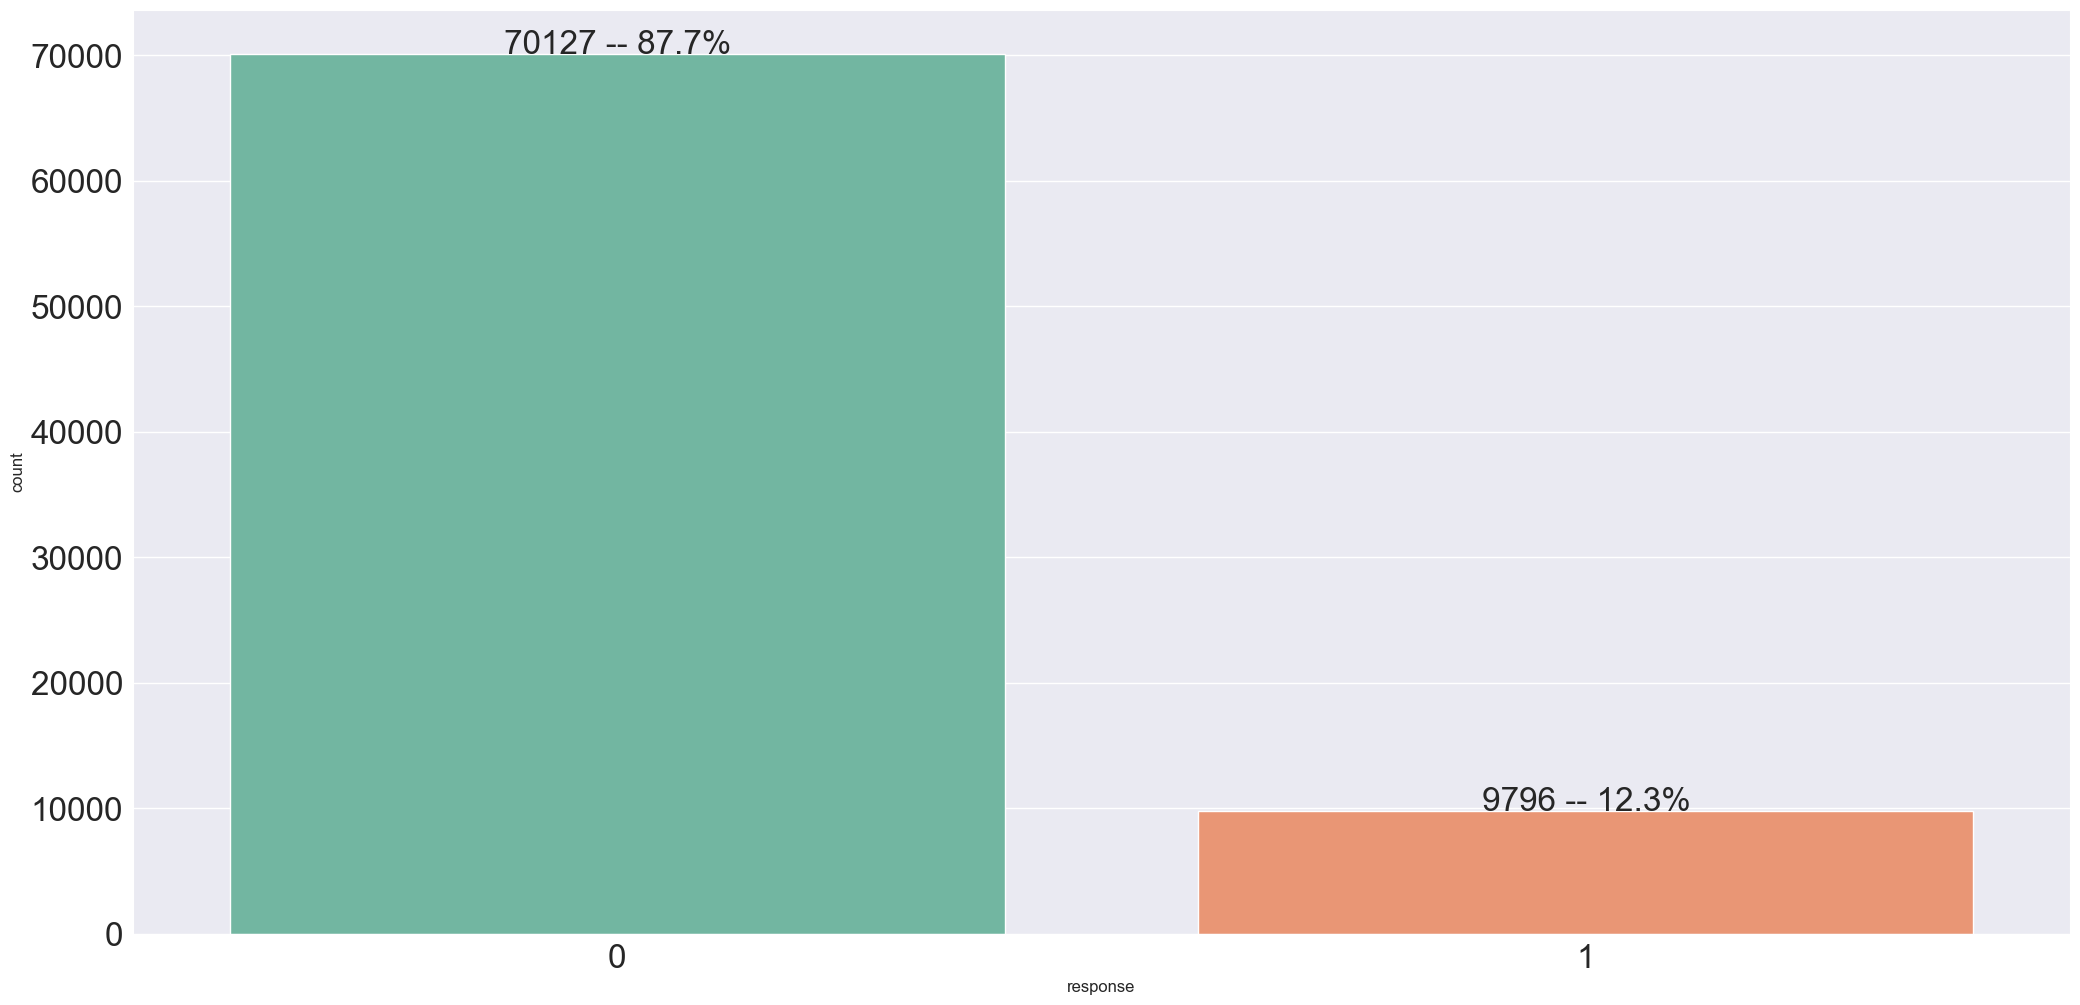

In [520]:
fig, ax = plt.subplots()
sns.countplot(data = df1, x='response', ax = ax);

for p in ax.patches:
    h = p.get_height()
    ax.text(p.get_x() + (p.get_width()/2), h , f'{h} -- {round(h/len(df1)*100, 1)}%', ha='center')

### 4.1.2. Numeic Variable

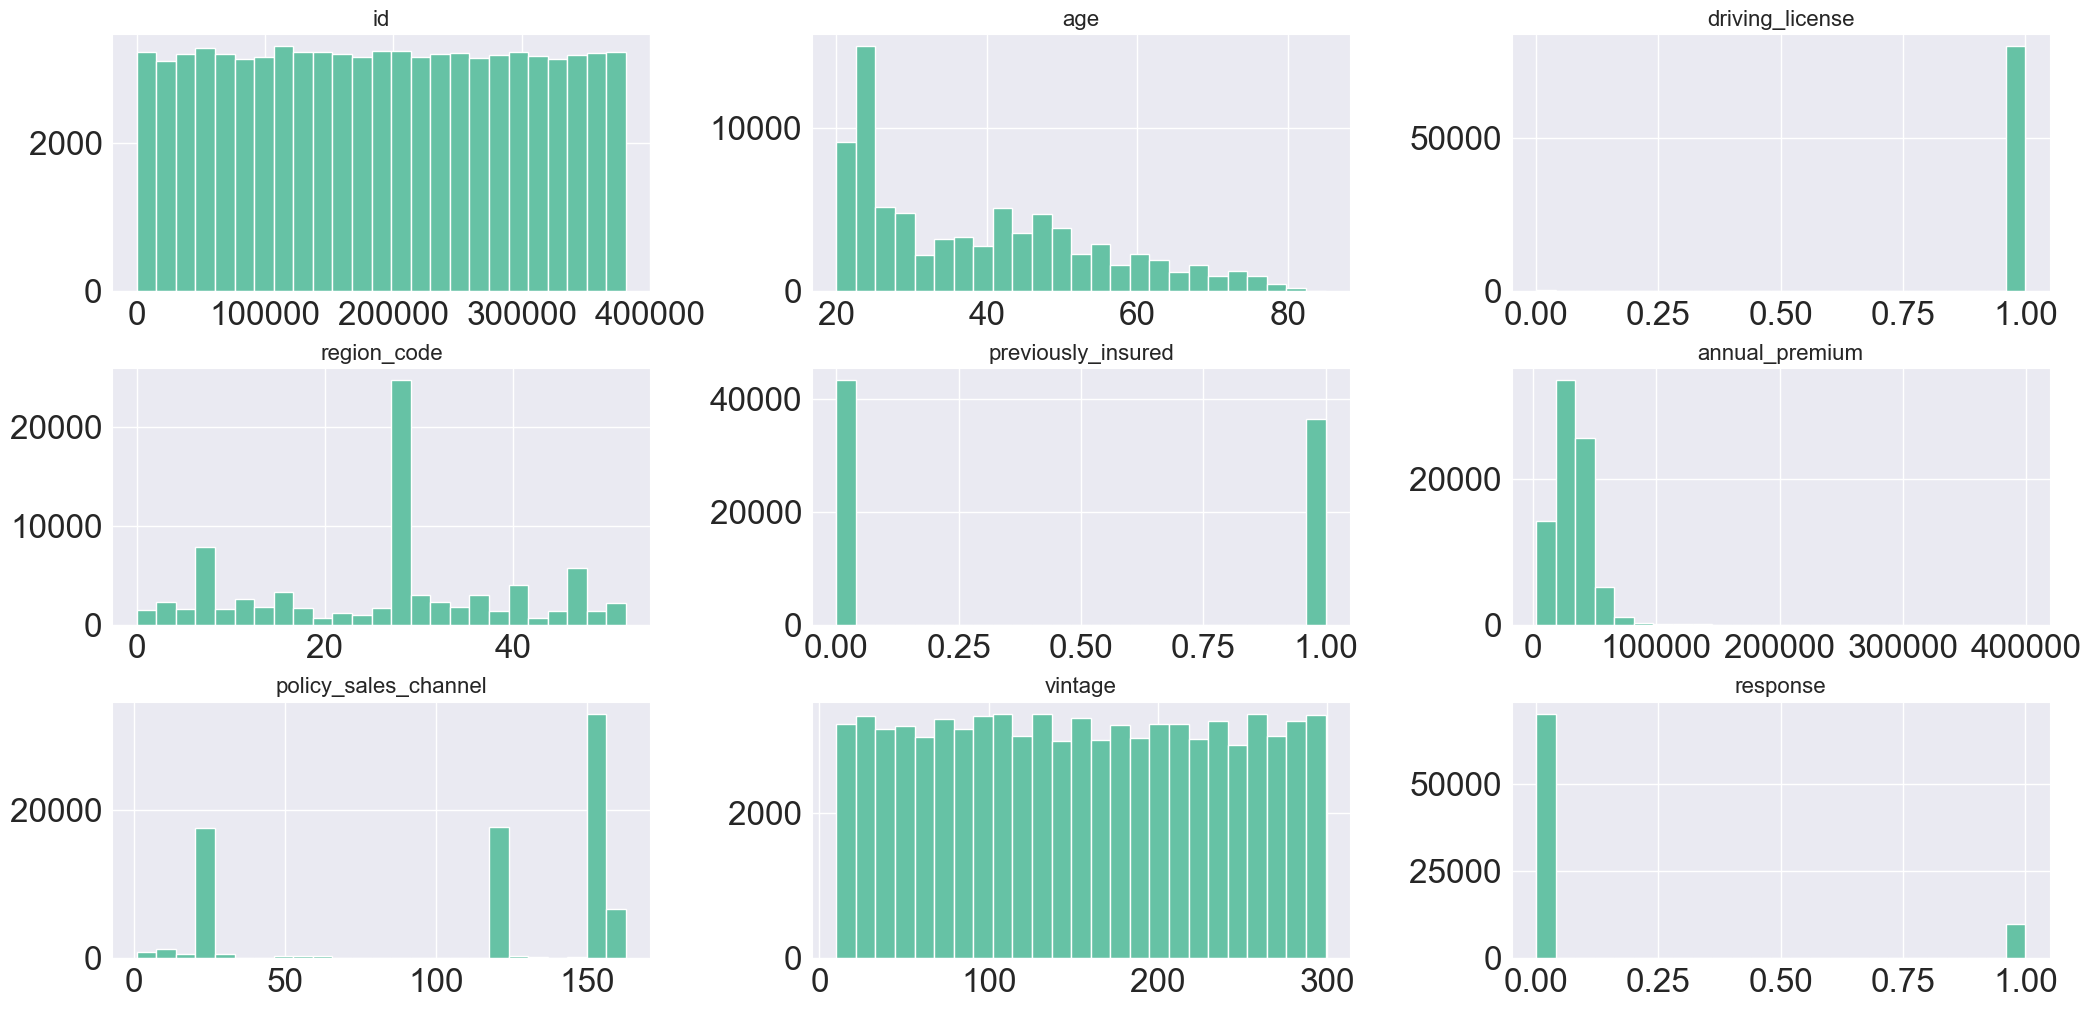

In [521]:
num_attributes.hist(bins=25);

## 4.2. Bivariate Analysis


### 4.2.1. Gender

- Dos 105.424 clientes homens no total, quase 14% demonstram interesse no seguro
- Já entre as mulheres, das 89.703 clientes, quase 11% possuem interesse no seguro

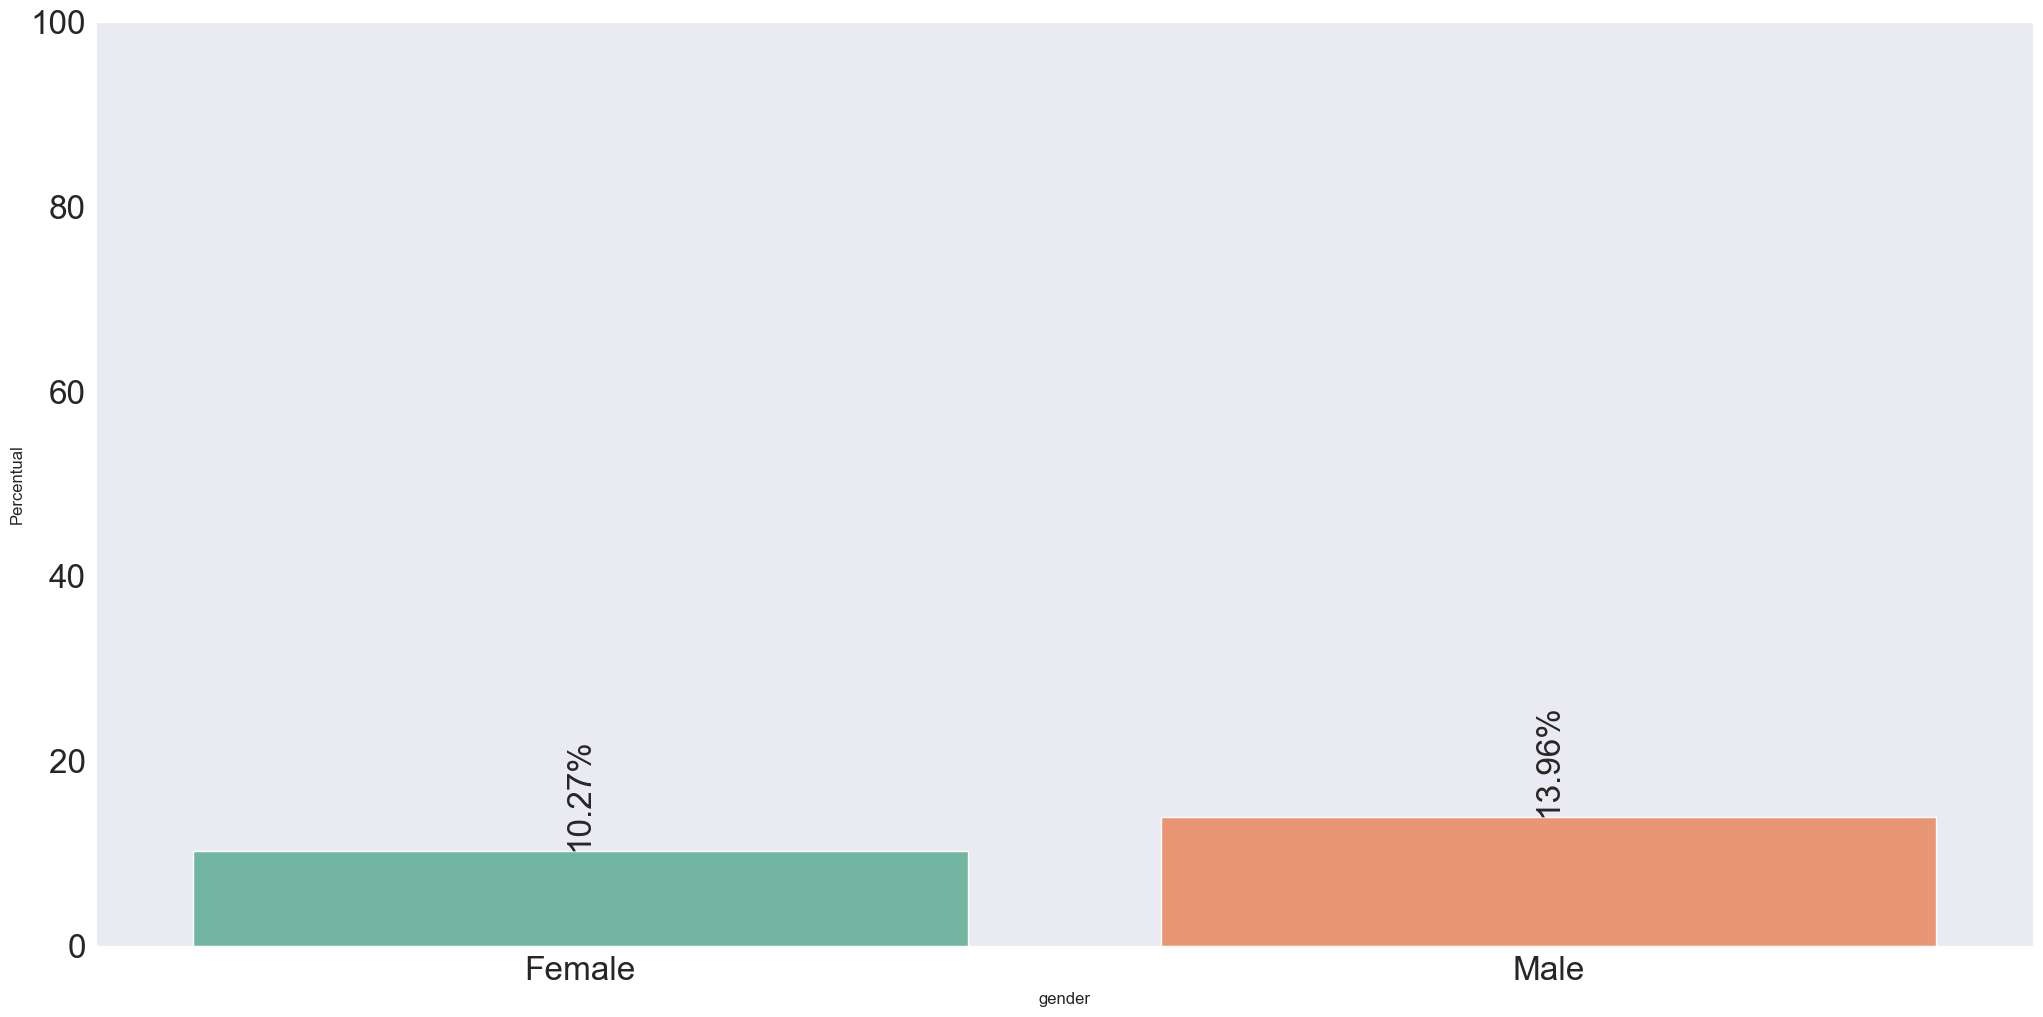

In [522]:
conversion_plots(df4, 'gender')

In [523]:
df4[['id', 'gender', 'response']].groupby(['gender', 'response']).count().reset_index()

gender  response     id
0  Female         0  33119
1  Female         1   3791
2    Male         0  37008
3    Male         1   6005

### 4.2.2. Age

- Faixa etária de 32 a 53 anos: Apresenta um interesse maior na aquisição do seguro de carro
- Faixa etária abaixo de 30 anos: Concentra o grupo com menor interesse na aquisição do seguro de carro

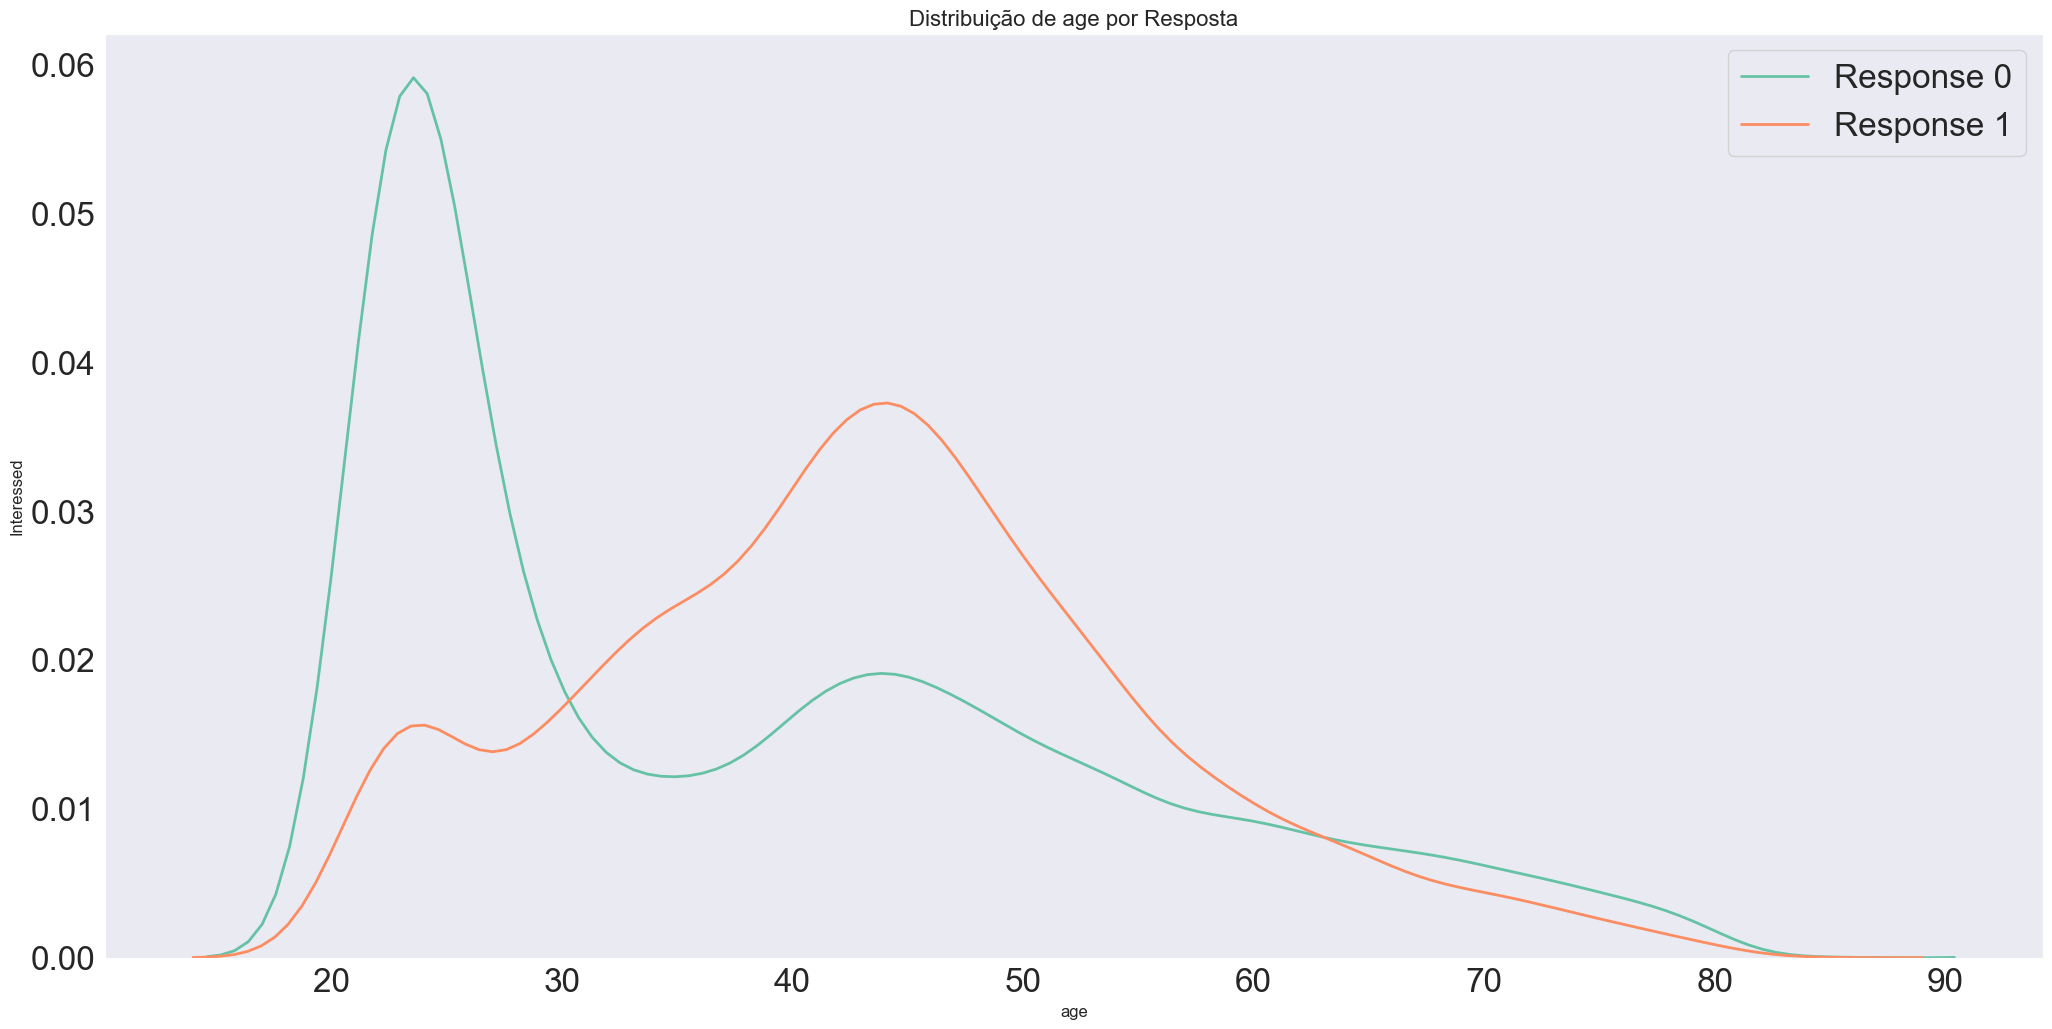

In [524]:
line_plot(df4, 'age')

### 4.2.3. Region Code

<Figure size 1200x600 with 0 Axes>

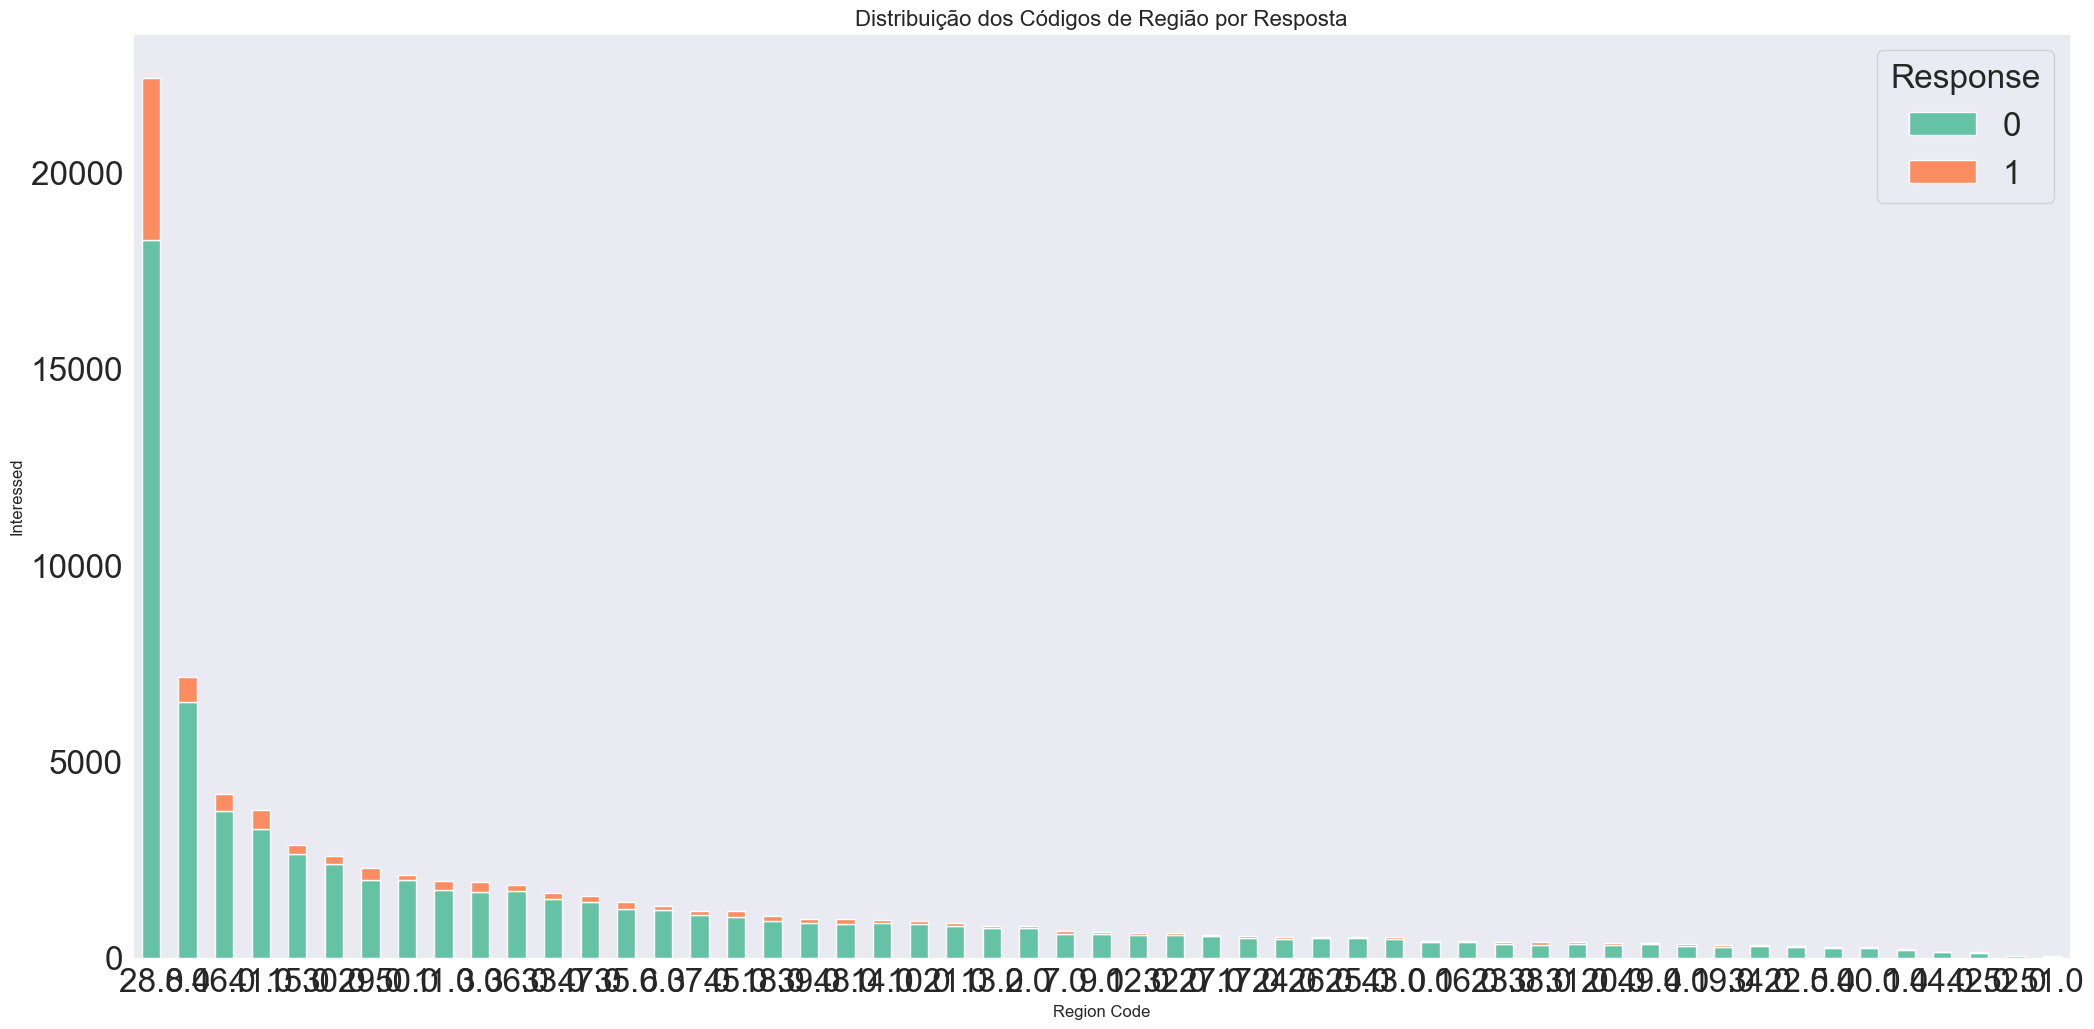

In [525]:
# Agrupar os dados por código de região e resposta e contar a frequência
region_response_counts = df4.groupby(['region_code', 'response']).size().unstack().fillna(0)

# Ordenar os códigos de região por ordem decrescente de total
region_response_counts['Total'] = region_response_counts.sum(axis=1)
region_response_counts = region_response_counts.sort_values('Total', ascending=False).drop('Total', axis=1)

# Criar o gráfico de barras agrupadas
plt.figure(figsize=(12, 6))
region_response_counts.plot(kind='bar', stacked=True)

plt.xlabel('Region Code')
plt.ylabel('Interessed')
plt.title('Distribuição dos Códigos de Região por Resposta')

plt.legend(title='Response', loc='upper right')

plt.xticks(rotation=0)  # Rotação dos rótulos do eixo x, se necessário

plt.show()

### 4.2.4. Policy Sales Channel

- Os 3 principais canais de venda de apólices respondem por 79,57% dos clientes captados

In [747]:
total_channels = df4['policy_sales_channel'].nunique()
print("Total de policy_sales_channel:", total_channels)

Total de policy_sales_channel: 135


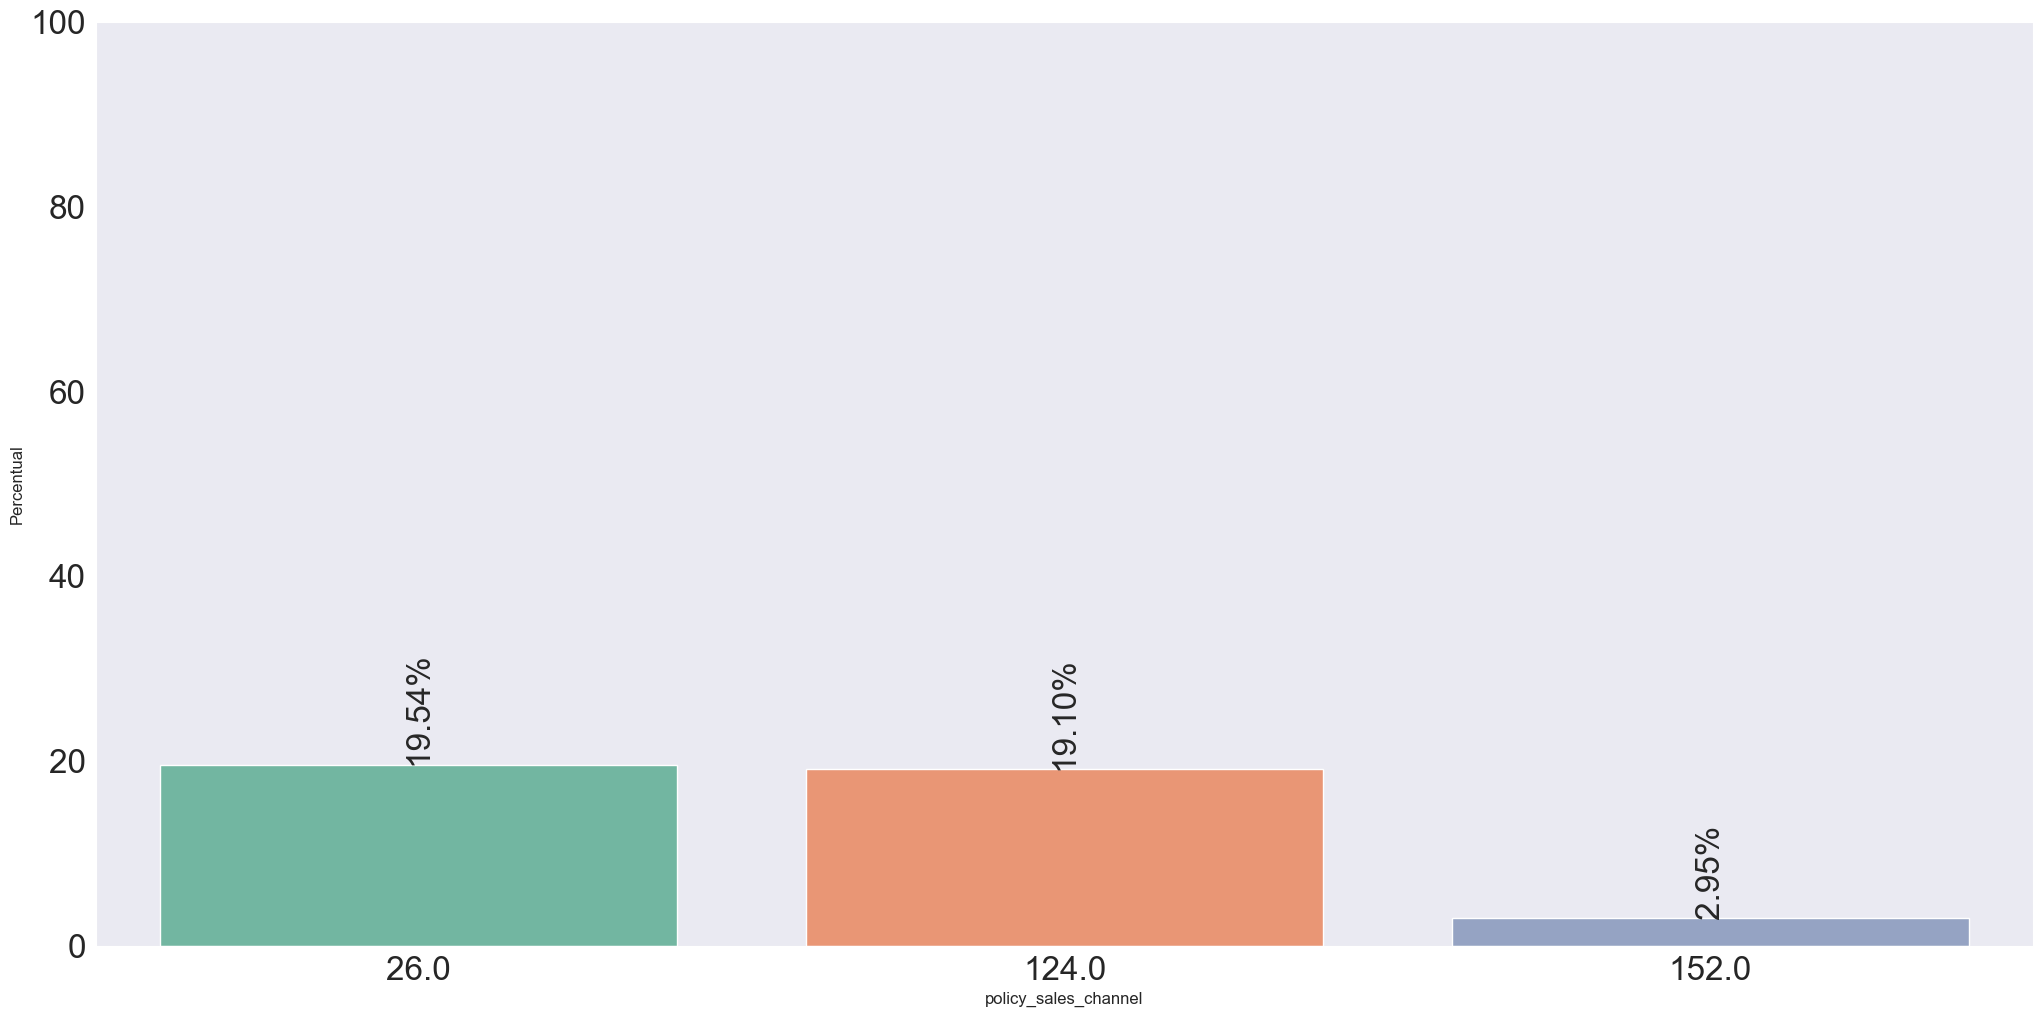

In [526]:
top3 = df4.policy_sales_channel.value_counts().sort_values(ascending=False).head(3).index

df_top3 = df4[df4.policy_sales_channel.isin(top3)]
conversion_plots(df_top3, 'policy_sales_channel')

In [527]:
# Calculate the percentage of customers attracted by the top 3 channels
total_customers = df4.shape[0]
top3_customers = df_top3.shape[0]
percentage = (top3_customers / total_customers) * 100

print(f"The top 3 policy sales channels account for {percentage:.2f}% of the attracted customers.")


The top 3 policy sales channels account for 75.82% of the attracted customers.


### 4.2.5. Driving License

- Entre os interessados, 3.75% são clientes sem carta de condução, enquanto que 12.28% são clientes com carta de condução

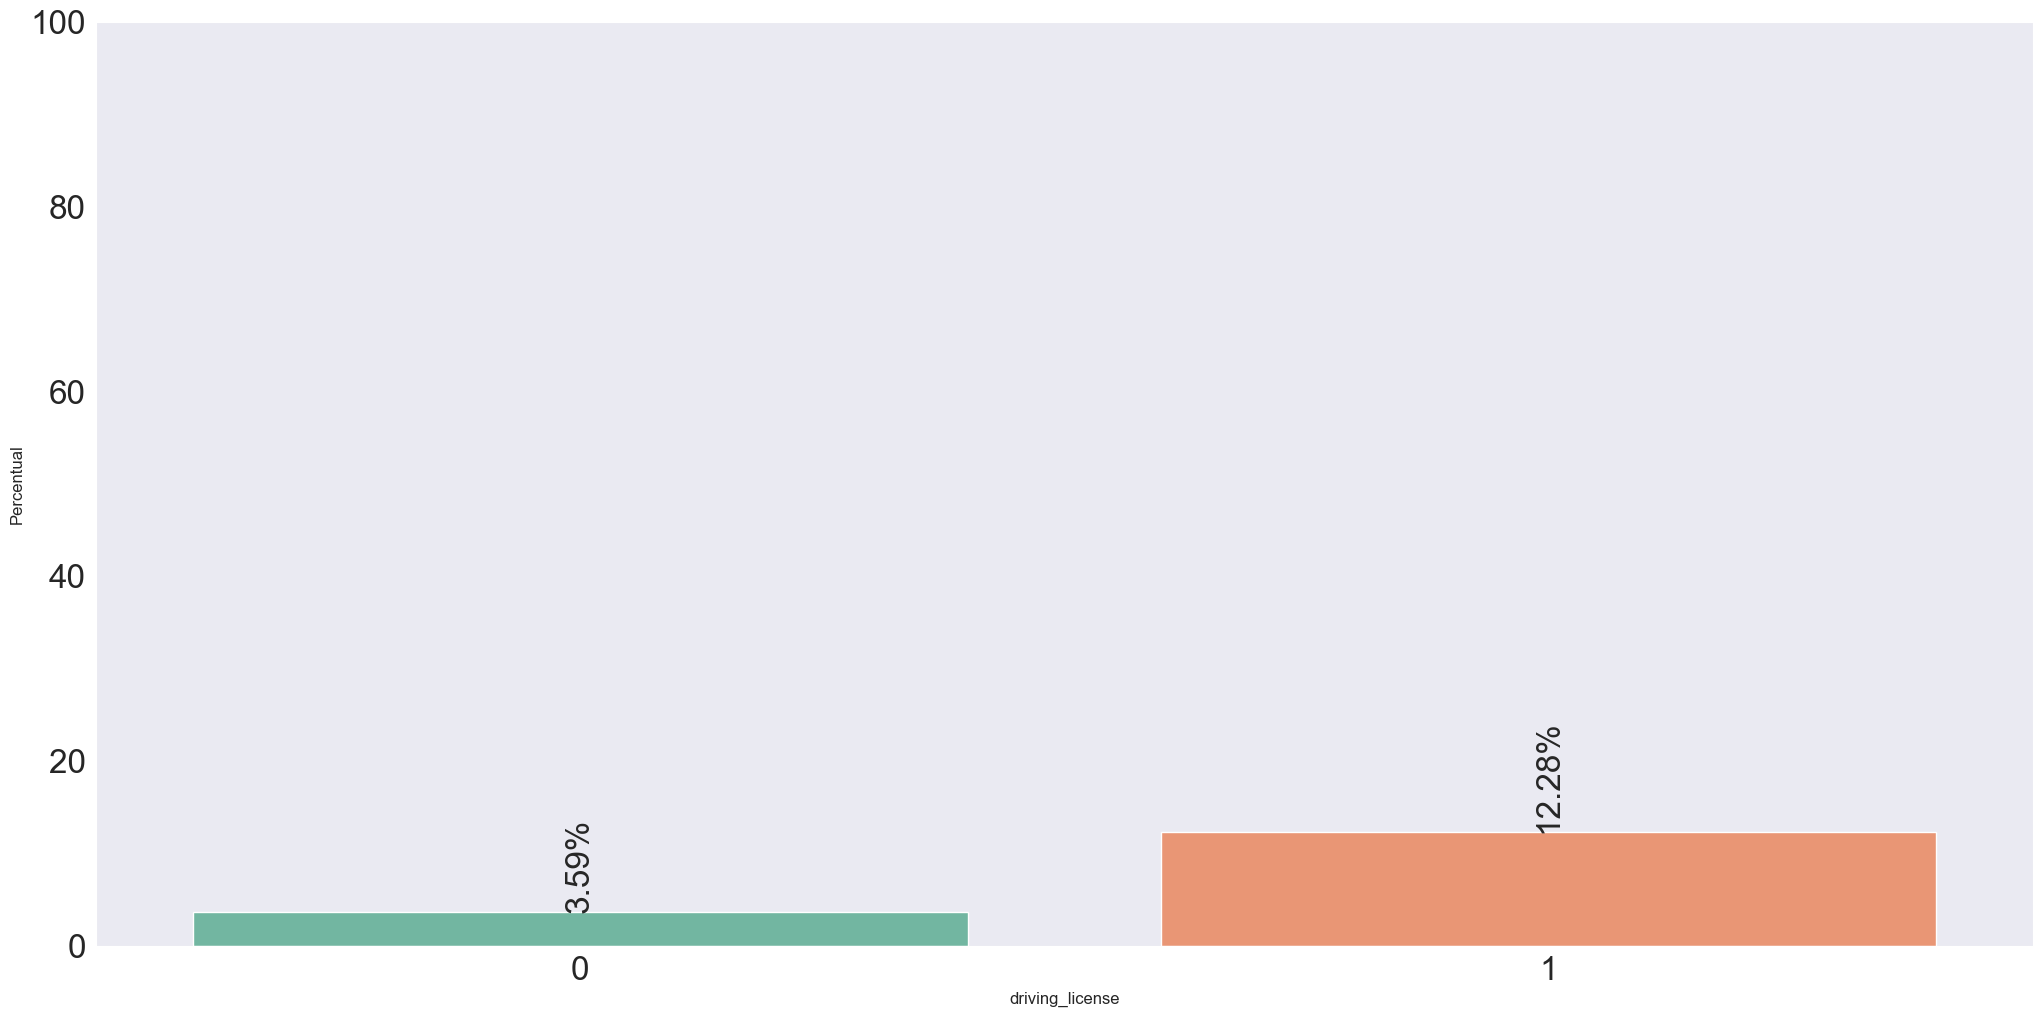

In [528]:
conversion_plots(df4, 'driving_license')

### 4.2.6. Vehicle Age

- Carros com mais de 2 anos apresentam uma taxa de conversão mais alta em comparação aos demais

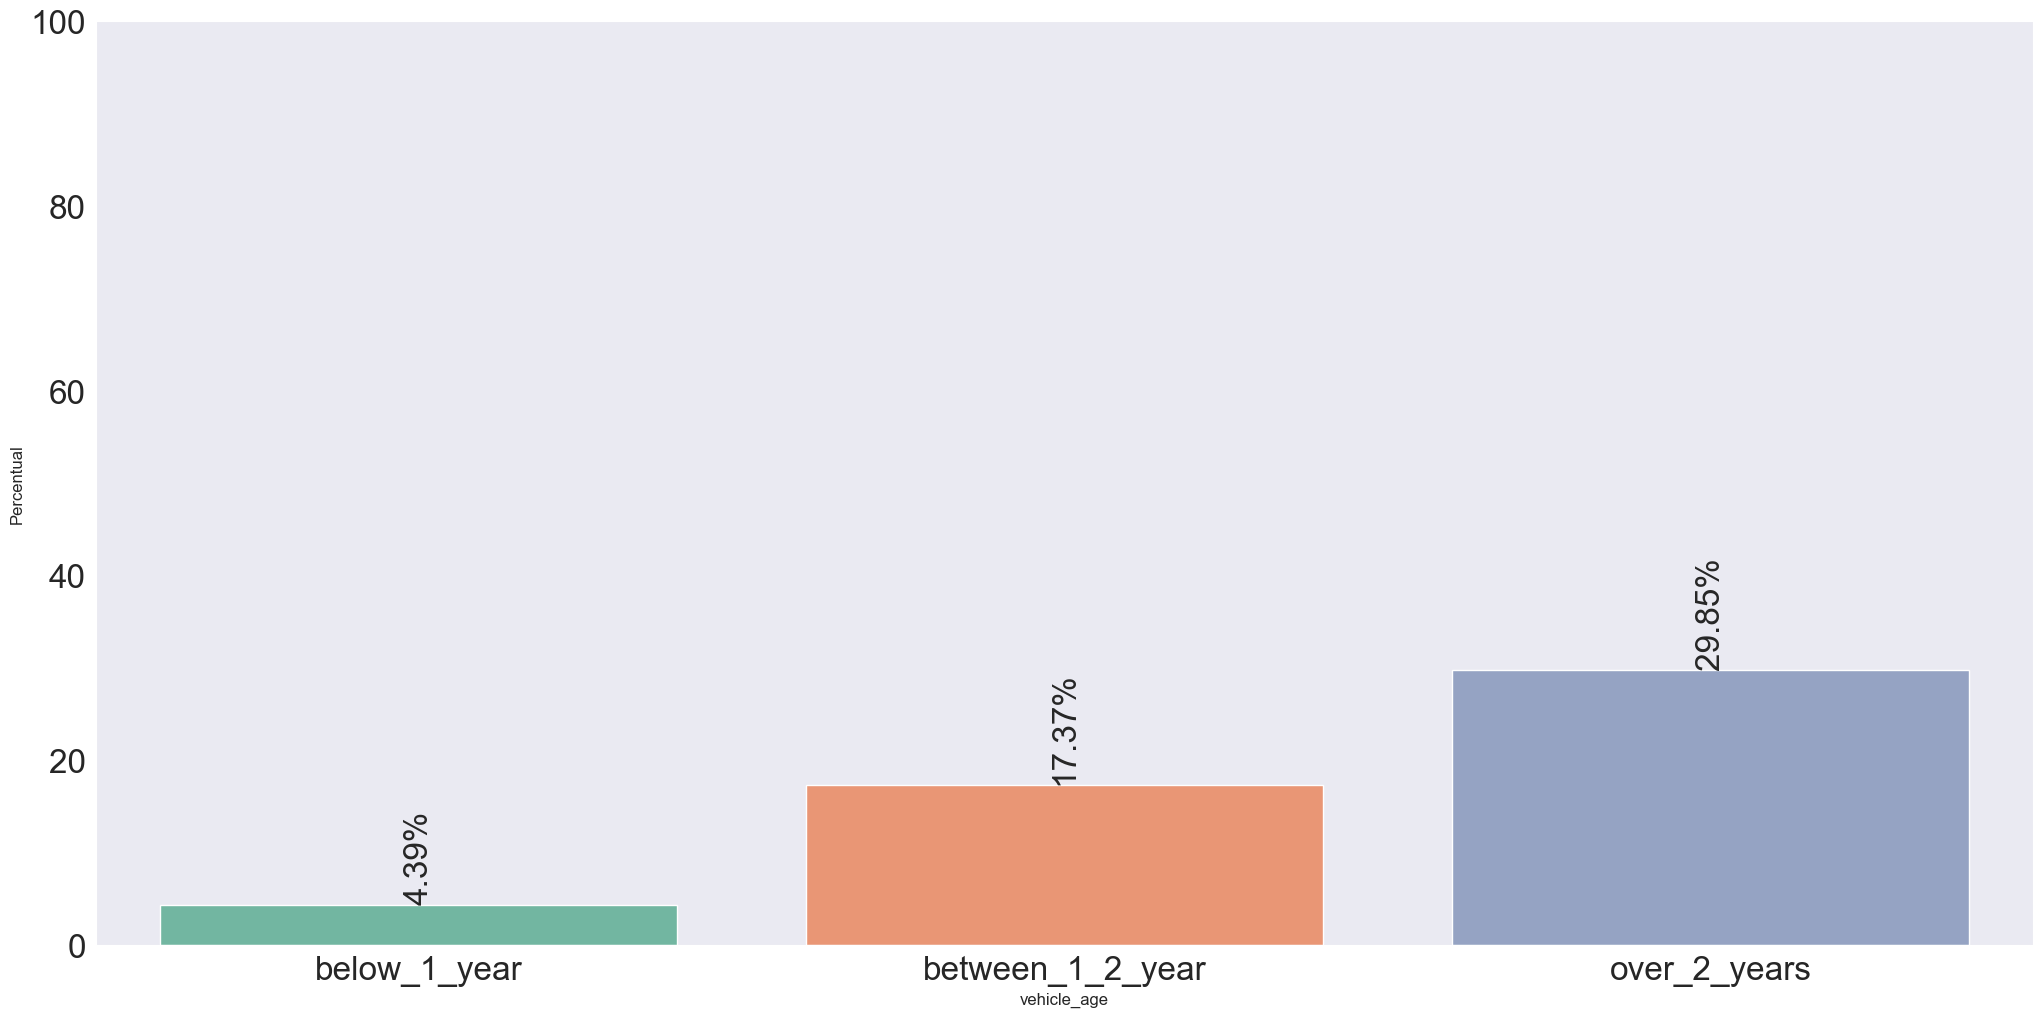

In [529]:
conversion_plots(df4, 'vehicle_age')

### 4.2.7. Vehicle Damage

-  A experiência anterior de acidentes pode influenciar a percepção dos indivíduos sobre a importância e a necessidade de obter um seguro de carro

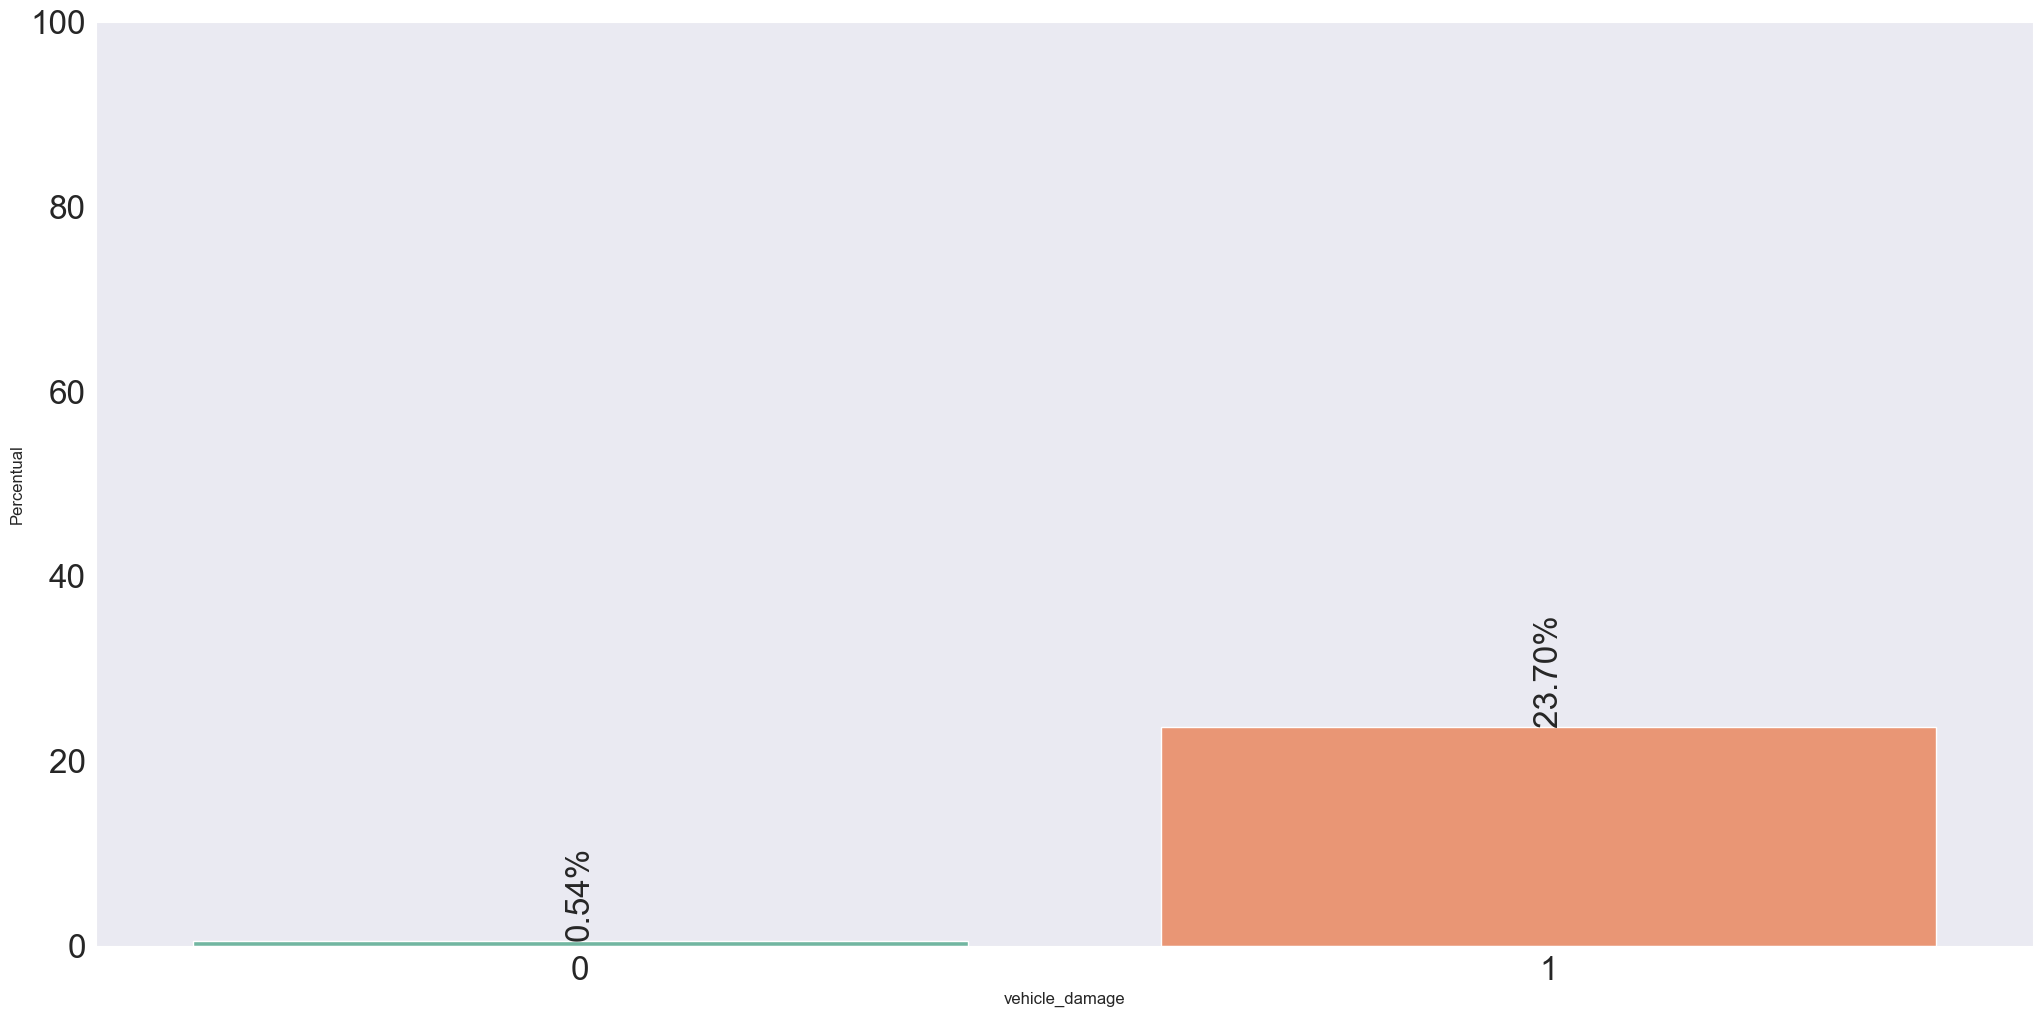

In [530]:
conversion_plots(df4, 'vehicle_damage')

### 4.2.8. Previously Insured

- A posse prévia de um seguro de carro pode influenciar a percepção dos indivíduos sobre a necessidade de obter cobertura adicional ou de buscar alternativas no mercado

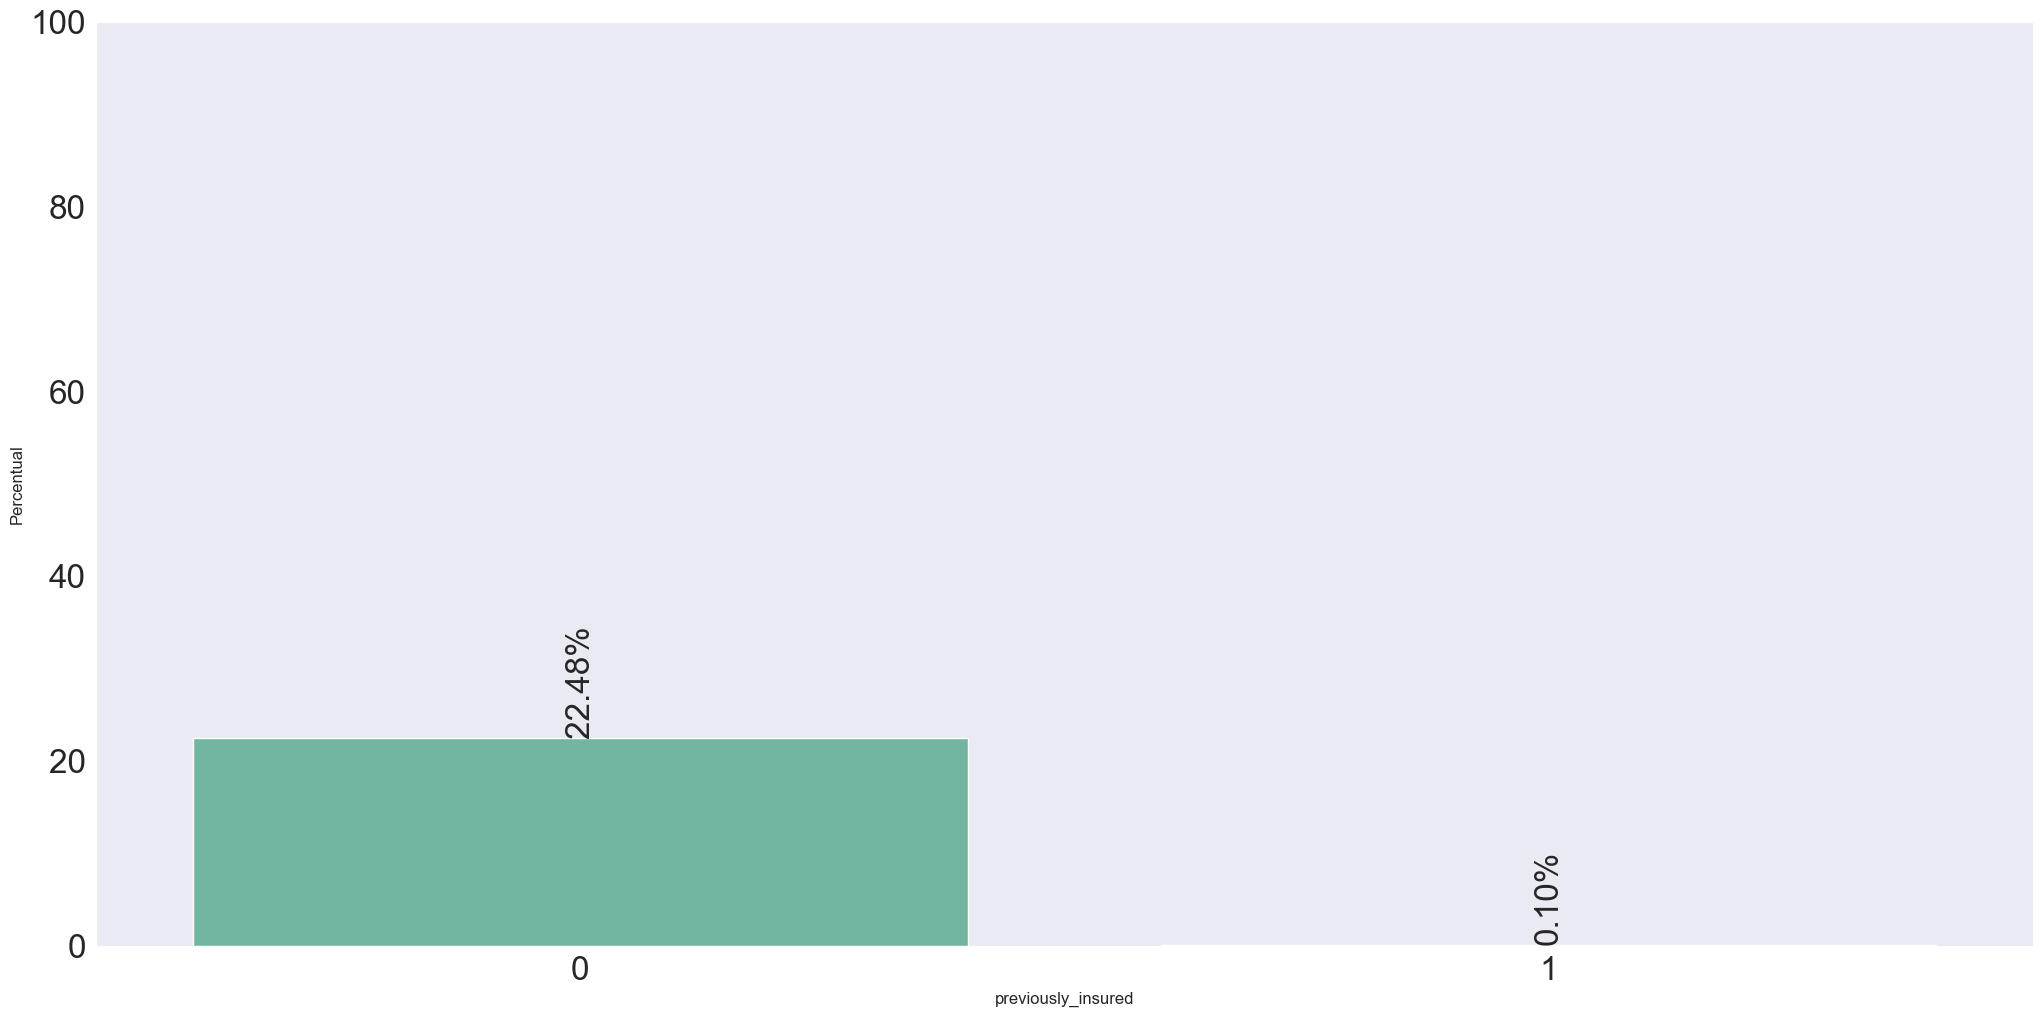

In [531]:
conversion_plots(df4, 'previously_insured')

### 4.2.9. Annual Premium

<AxesSubplot: xlabel='response', ylabel='annual_premium'>

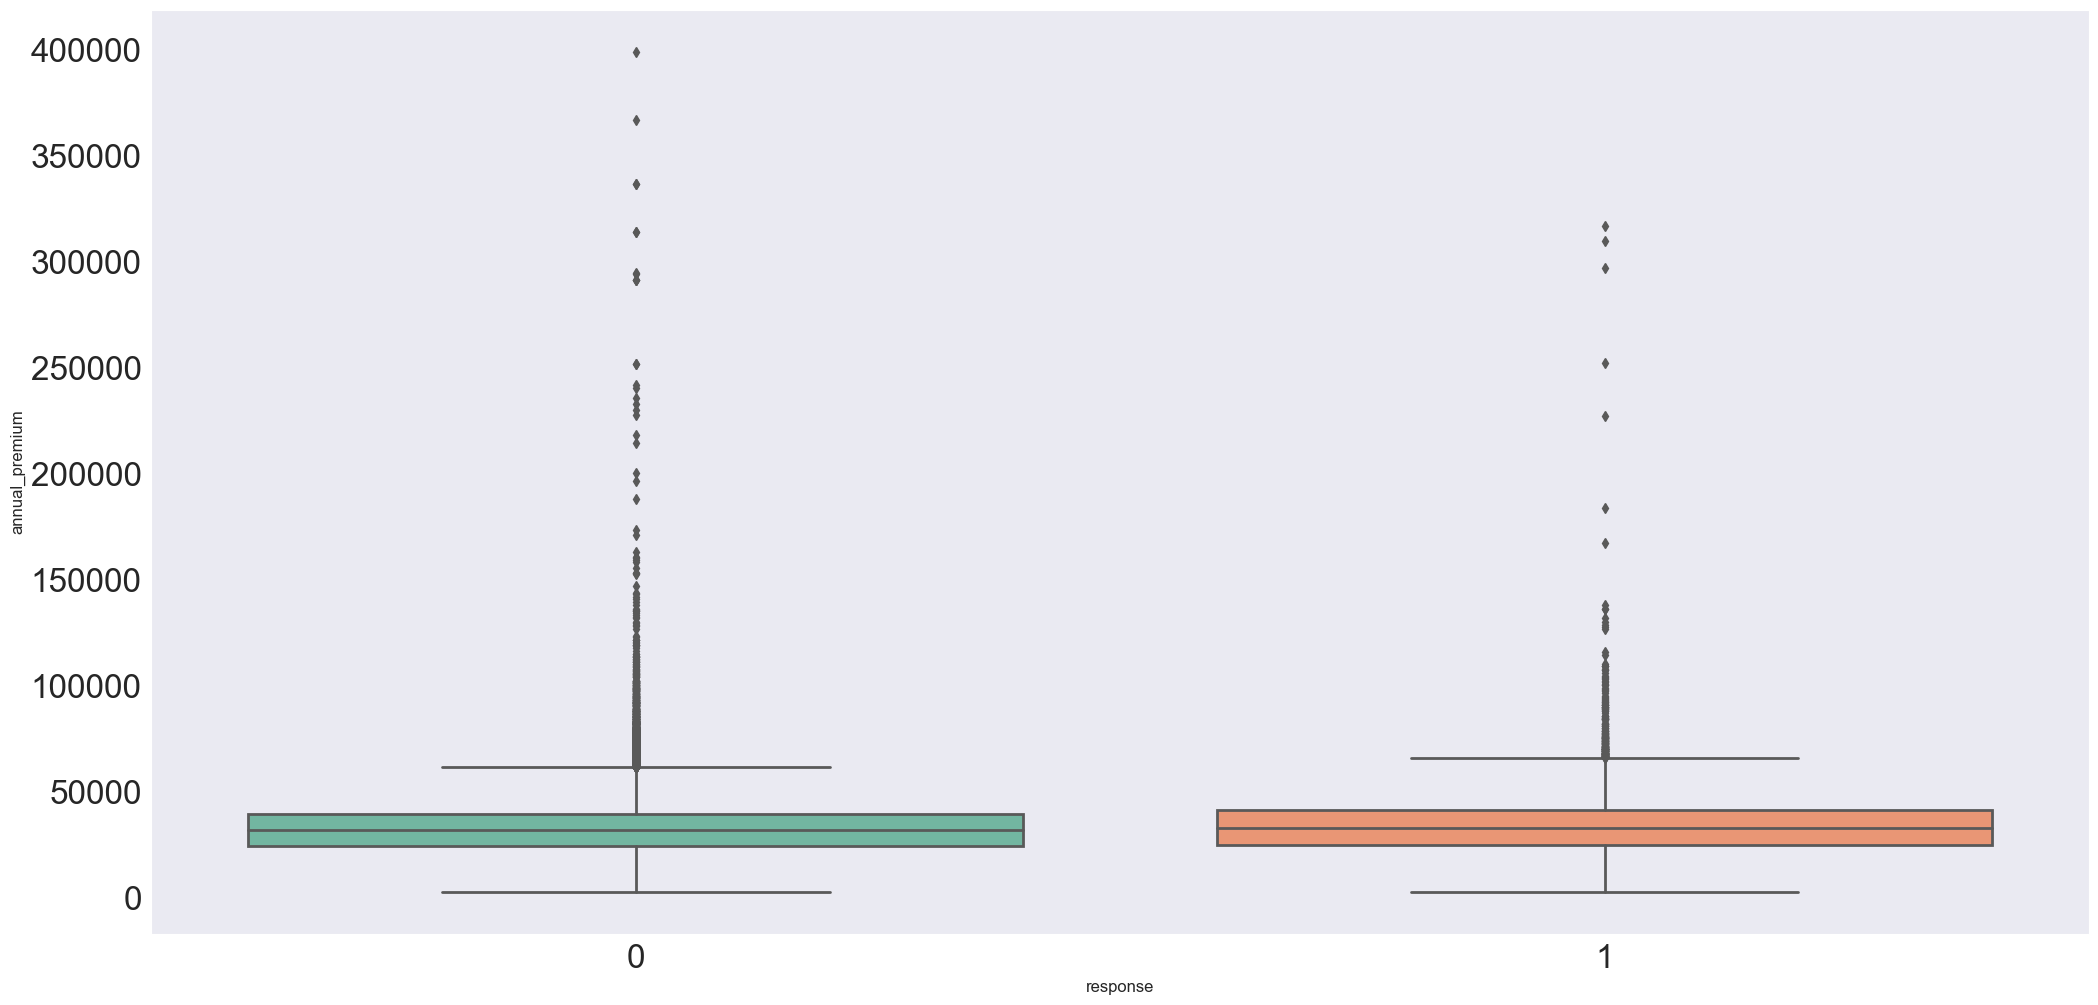

In [532]:
sns.boxplot(x='response', y='annual_premium', data=df4)

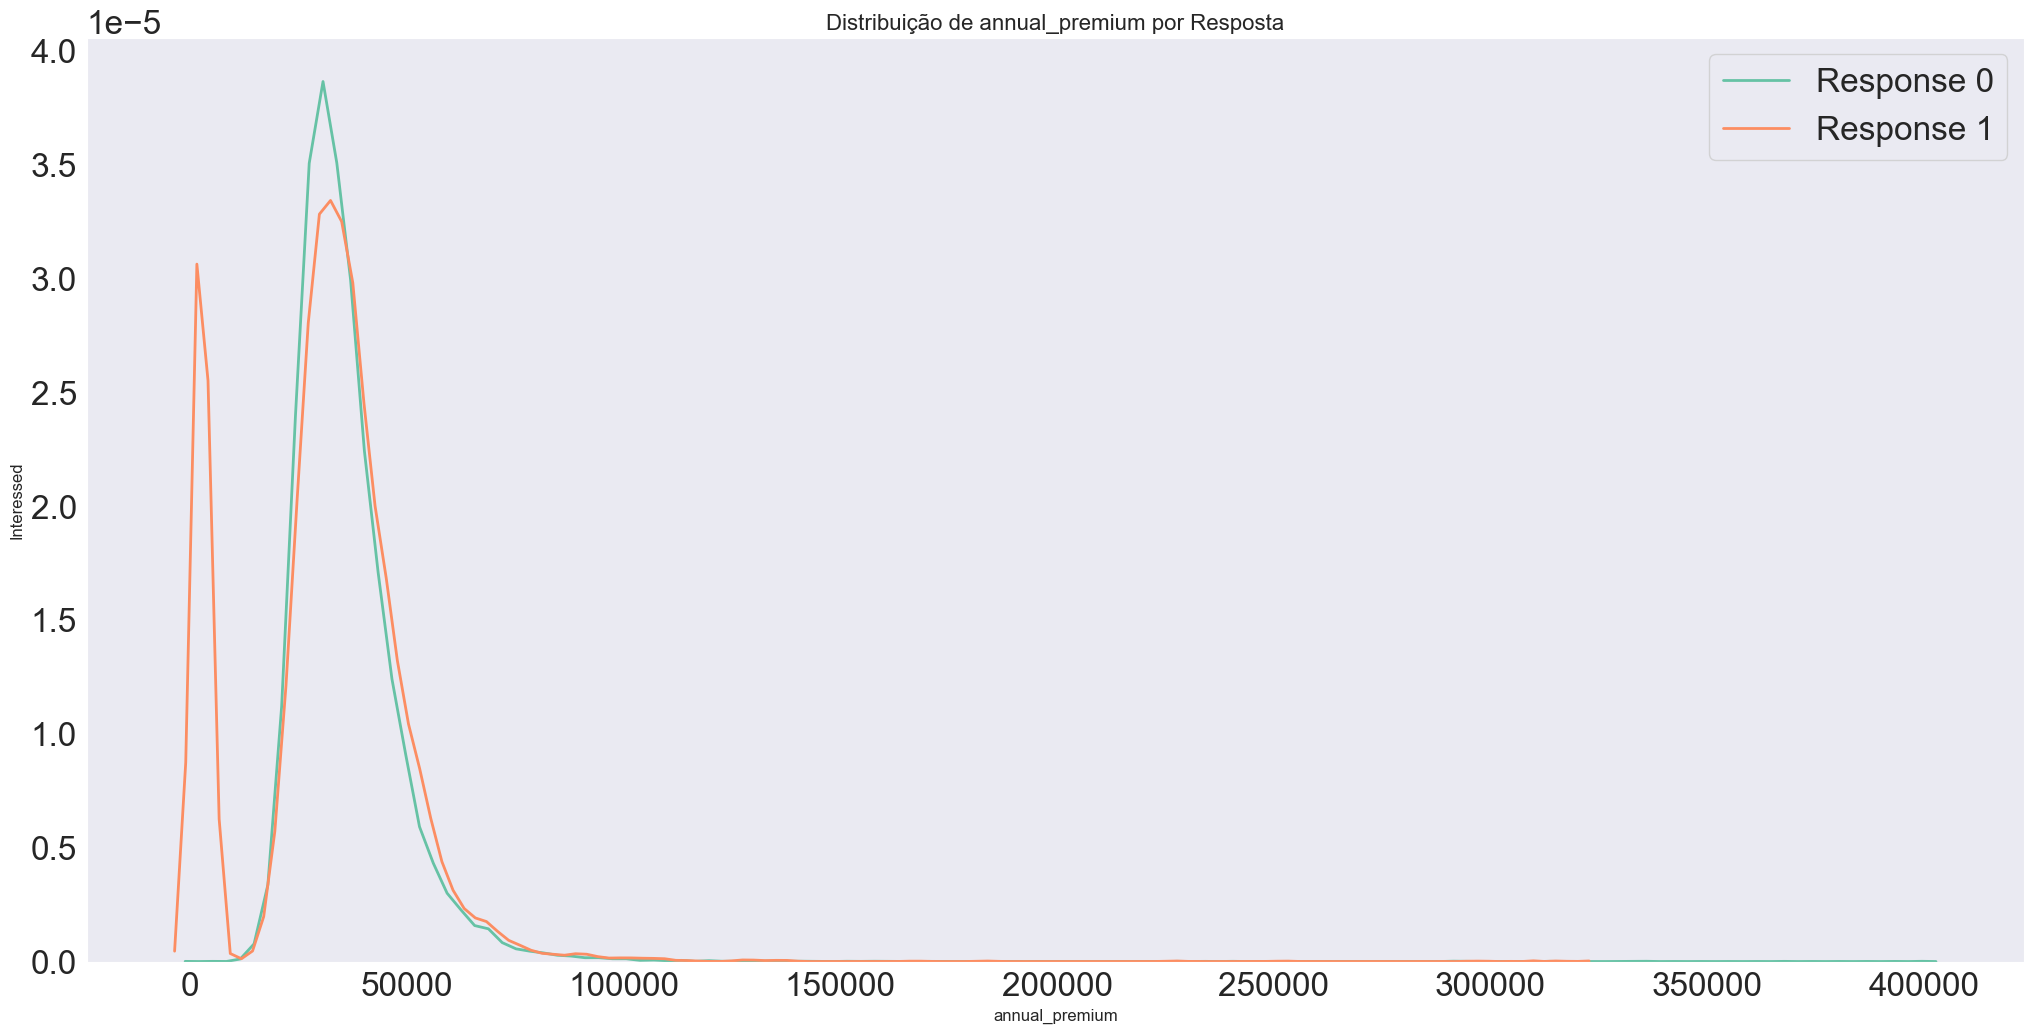

In [533]:
line_plot(df4, 'annual_premium')

### 4.2.10. Vintage

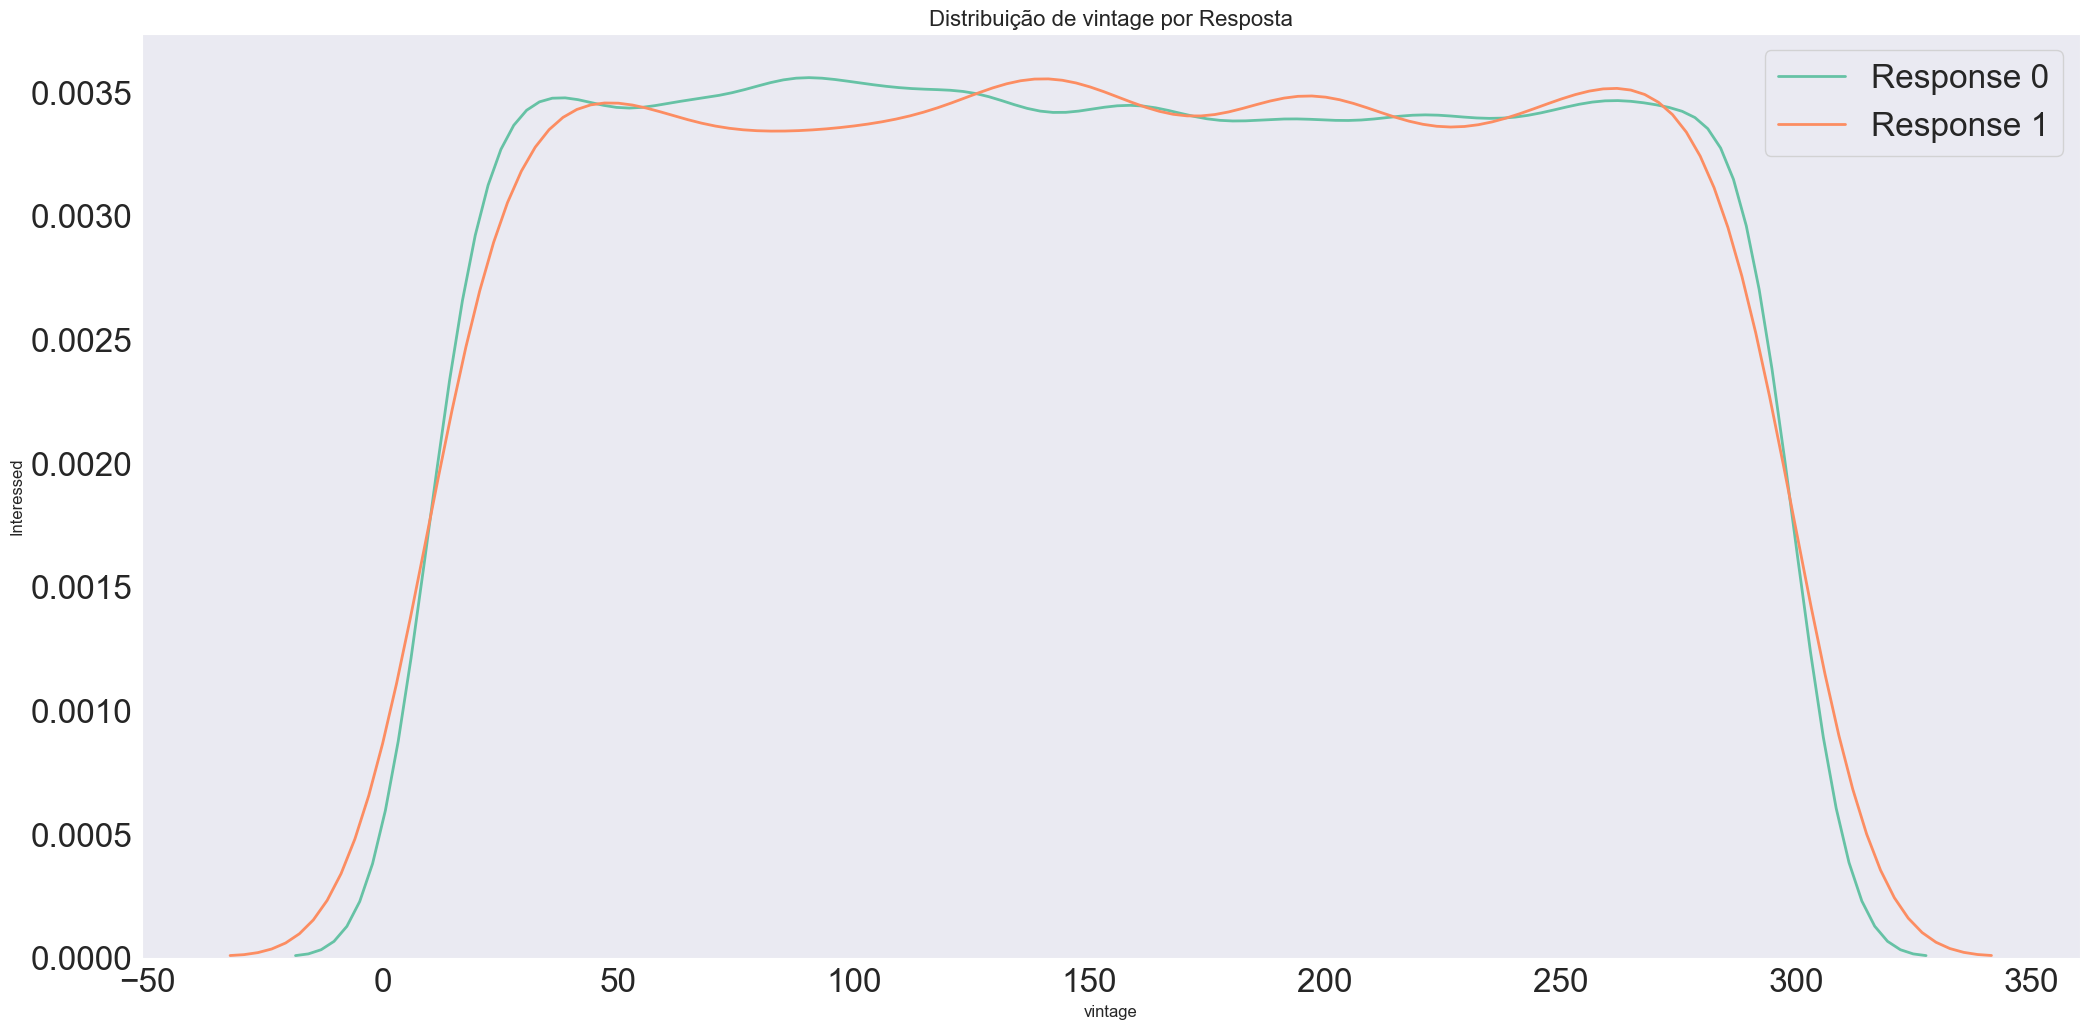

In [534]:
line_plot(df4, 'vintage')

## 4.3. Multivariable Analysis

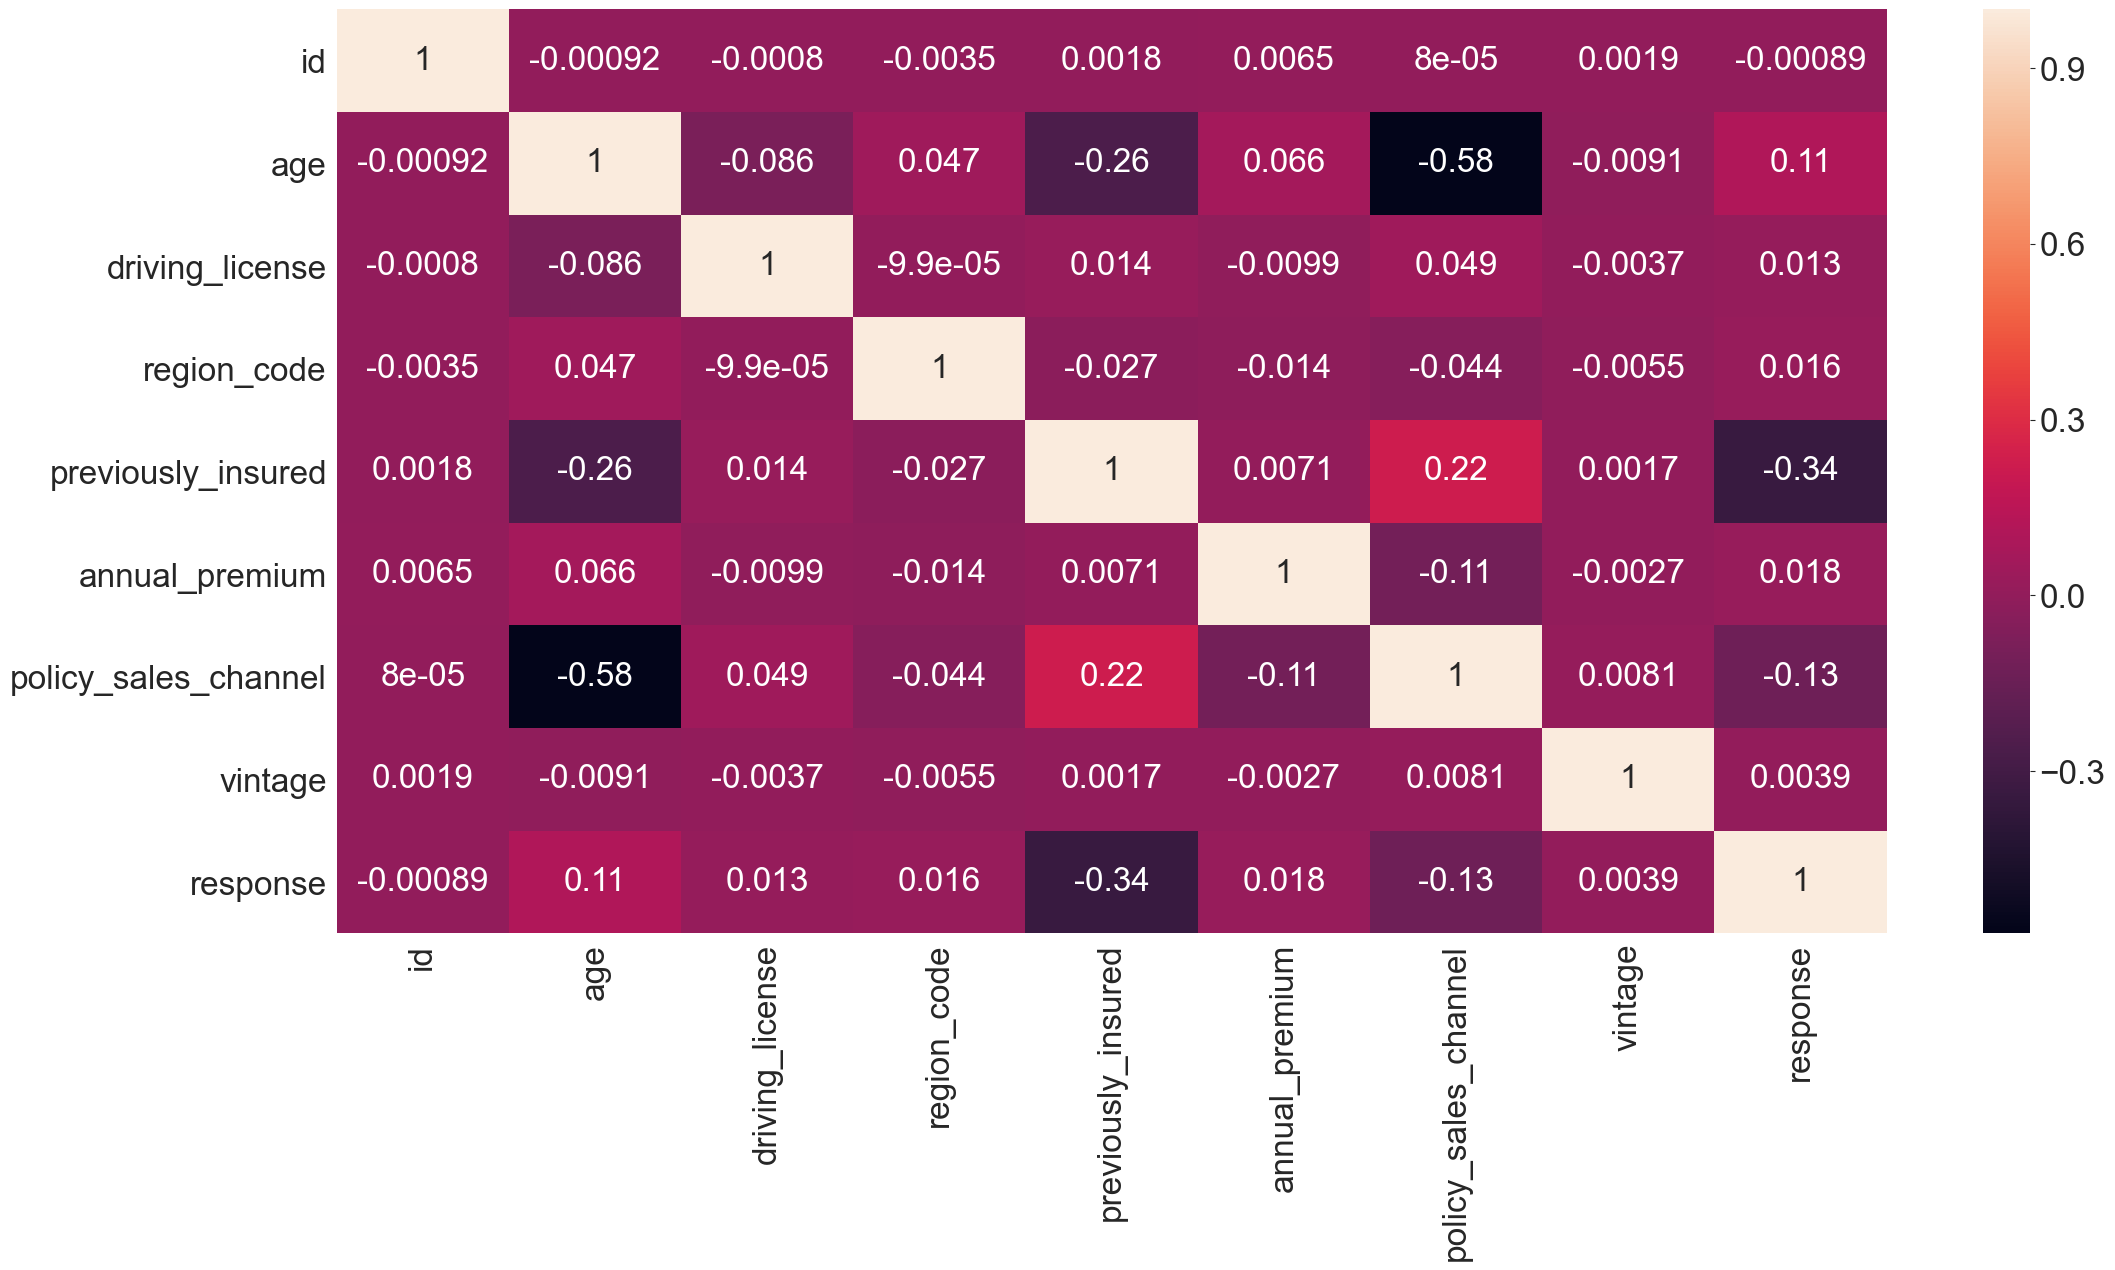

In [535]:
corr = num_attributes.corr(method='pearson')
sns.heatmap(corr, annot=True);

## 4.4. Hypotheses


1. Clientes com menos de 30 anos têm uma probabilidade menor de se interessar por um seguro de carro.

2. Mulheres têm maior probabilidade de adquirir um seguro de veículo do que homens.

3. Clientes que não possuem licença para dirigir apresentam menor interesse em adquirir um seguro de veículo.

4. Clientes que não possuem outro seguro de carro têm maior probabilidade de adquirir o seguro de veículo.

5. Clientes que pagam um prêmio mais alto têm maior probabilidade de adquirir um seguro de veículo.

6. Clientes com mais tempo de posse do seguro saúde têm maior probabilidade de se interessar por um seguro de veículo.

7. Os três canais de venda mais utilizados são responsáveis por atrair aproximadamente 20% dos clientes interessados em adquirir um seguro de carro.

8. Clientes com veículos mais novos apresentam maior probabilidade de ter um seguro de veículo.

# 5.0. Data Preparation

In [538]:
# Separação dos dados em variáveis preditoras (X) e variável alvo (y)
X = df4.drop('response', axis=1)
y = df4['response'].copy()

# Divisão dos dados em conjunto de treino e conjunto de validação
x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.20)

# Criação do DataFrame df5, que é a concatenação das variáveis preditoras e alvo do conjunto de treino
df5 = pd.concat([x_train, y_train], axis=1)


## 5.1. Standardization 

In [539]:
# Instanciando o StandardScaler
ss = pp.StandardScaler()

# Aplicando o StandardScaler na coluna 'annual_premium' e salvando o modelo treinado
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
pickle.dump(ss, open('../src/features/annual_premium_scaler.pkl', 'wb' ))


## 5.2. Rescaling

In [540]:
# Inicializando dois objetos MinMaxScaler para normalização das colunas 'age' e 'vintage'.
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Aplicando o MinMaxScaler na coluna 'age' e salvando o scaler em um arquivo .pkl para uso futuro.
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump(mms_age, open('../src/features/age_scaler.pkl', 'wb'))

# Aplicando o MinMaxScaler na coluna 'vintage' e salvando o scaler em um arquivo .pkl para uso futuro.
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump(mms_vintage, open( '../src/features/vintage_scaler.pkl', 'wb' ))

## 5.3. Transformation

### 5.3.1. Encoding

In [541]:
# gender - One Hot Encoding / Target Encoding
# Target Encoding utilizando a média da coluna 'response' agrupada por 'gender'
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
pickle.dump( target_encode_gender, open( '../src/features/target_encode_gender_scaler.pkl', 'wb' ) )

# region_code - Target Encoding / Frequency Encoding
# Target Encoding utilizando a média da coluna 'response' agrupada por 'region_code'
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
pickle.dump( target_encode_region_code, open( '../src/features/target_encode_region_code_scaler.pkl', 'wb' ) )

# vehicle_age - One Hot Encoding / Frequency Encoding
# One Hot Encoding da coluna 'vehicle_age'
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
# Frequency Encoding da coluna 'policy_sales_channel'
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
pickle.dump( fe_policy_sales_channel, open( '../src/features/fe_policy_sales_channel_scaler.pkl', 'wb' ) )

C:\Users\raquel\AppData\Local\Temp\ipykernel_18248\1991794763.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )


## 5.4. Validation Preparation

In [542]:
# gender: aplica a codificação alvo (target encoding) na coluna 'gender'
x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map( target_encode_gender )

# age: aplica a transformação MinMaxScaler na coluna 'age'
x_validation.loc[:, 'age'] = mms_age.transform(x_validation[['age']].values)

# region_code: aplica a codificação alvo (target encoding) na coluna 'region_code'
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map(target_encode_region_code)

# vehicle_age: cria variáveis dummy para a coluna 'vehicle_age'
x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])

# annual_premium: aplica a transformação StandardScaler na coluna 'annual_premium'
x_validation.loc[:, 'annual_premium'] = ss.transform(x_validation[['annual_premium']].values)

# policy_sales_channel: aplica a Frequency Encoding na coluna 'policy_sales_channel'
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage: aplica a transformação MinMaxScaler na coluna 'vintage'
x_validation.loc[:, 'vintage'] = mms_vintage.transform(x_validation[['vintage']].values)

# fillna
x_validation = x_validation.fillna(0)

C:\Users\raquel\AppData\Local\Temp\ipykernel_18248\2258272651.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map( target_encode_gender )


# 6.0. Feature Selection    

## 6.1. Boruta Algorithm

In [543]:
# Define os dados de treinamento
x_train_n = df5.drop(['id', 'response'], axis=1).values
y_train_n = y_train.values.ravel()

# Define o modelo ExtraTreesClassifier
et = en.ExtraTreesClassifier(n_jobs=-1)

# Define o BorutaPy, que seleciona as features mais relevantes do modelo
boruta = bt.BorutaPy(et, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	9
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	9
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	9
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	9
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Itera

In [544]:
# Cria uma lista de booleanos, com True para as features selecionadas pelo Boruta
cols_selected = boruta.support_.tolist()

# Seleciona apenas as colunas correspondentes às melhores features
# a partir do dataset original
x_train_fs = df5.drop(['id', 'response'], axis=1)
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# features não selecionadas pelo Boruta
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

print(f'Cols selected to boruta: {cols_selected_boruta}')
print(f'Cols NOT selected to boruta: {cols_not_selected_boruta}')

Cols selected to boruta: ['age']
Cols NOT selected to boruta: ['annual_premium', 'driving_license', 'gender', 'policy_sales_channel', 'previously_insured', 'region_code', 'vehicle_age_below_1_year', 'vehicle_age_between_1_2_year', 'vehicle_age_over_2_years', 'vehicle_damage', 'vintage']


## 6.2. Feature Importance

In [545]:
# Definindo o modelo de classificação com o algoritmo ExtraTreesClassifier
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# Preparando os dados de treino: separando as colunas 'id' e 'response'
# os dados de entrada são todos os atributos do dataframe, exceto 'id' e 'response'
x_train_n = df5.drop(['id', 'response'], axis=1)

# Preparando os dados de treino: definindo os dados de saída (variável alvo)
# os dados de saída são obtidos da coluna 'response' do dataframe original
y_train_n = y_train.values

# Treinando o modelo com os dados de treino
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                         feature  importance
8                        vintage    0.248819
6                 annual_premium    0.218742
1                            age    0.187341
3                    region_code    0.117134
7           policy_sales_channel    0.072773
5                 vehicle_damage    0.066892
4             previously_insured    0.055776
9       vehicle_age_below_1_year    0.013788
0                         gender    0.008757
10  vehicle_age_between_1_2_year    0.006502
11      vehicle_age_over_2_years    0.002793
2                driving_license    0.000682


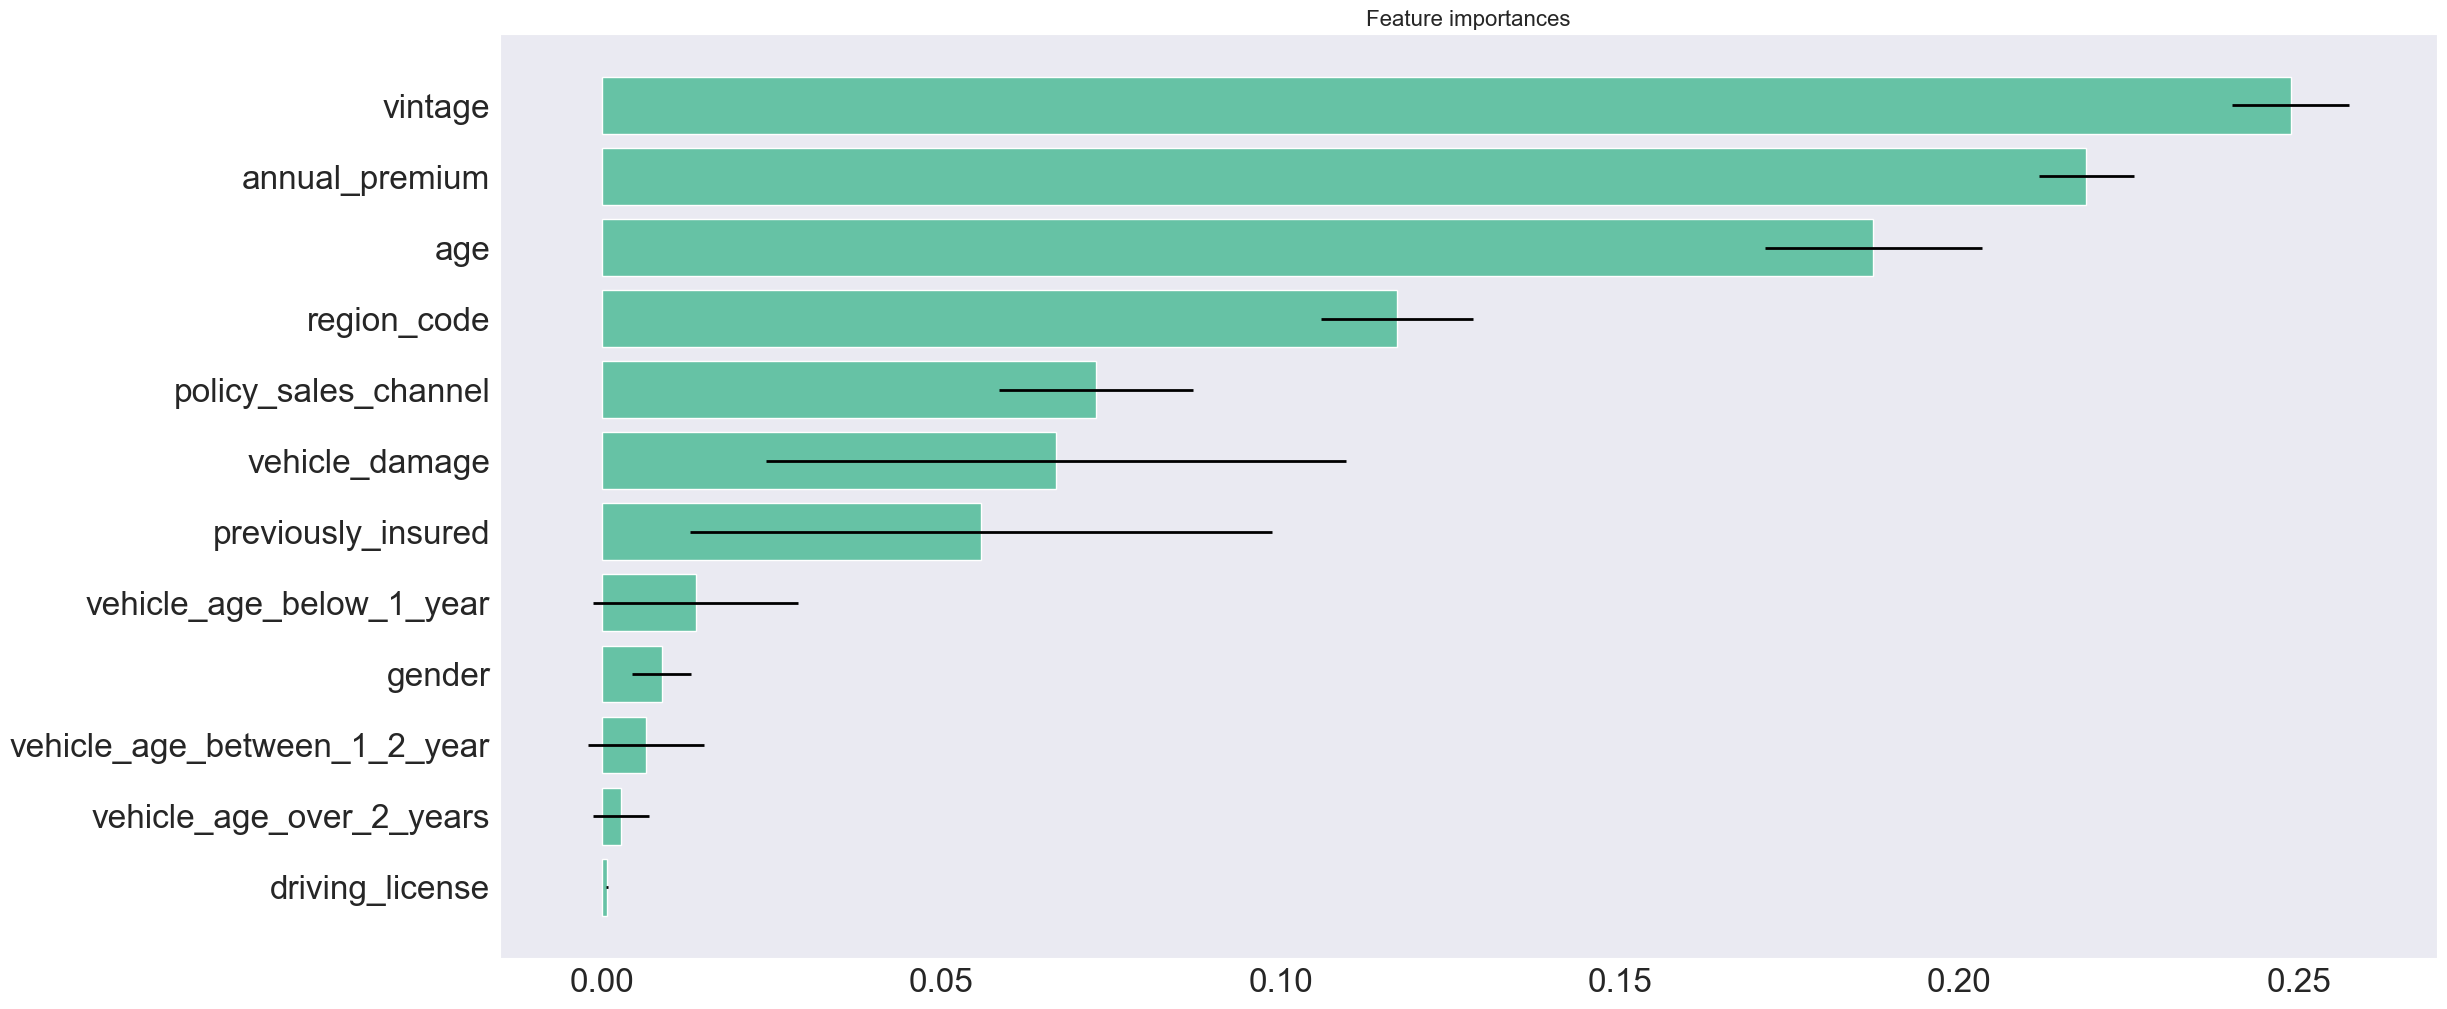

In [546]:
# Importância de cada feature
importances = forest.feature_importances_

# Desvio padrão das importâncias para cada feature
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# Ordena as importâncias em ordem decrescente
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame({'feature': x_train_n.columns, 'importance': importances})
df = df.sort_values('importance', ascending=False)
print(df)

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(x_train_n.shape[1]), importances[indices], xerr=std[indices], align="center")  # plot das importâncias
plt.yticks(range(x_train_n.shape[1]), df['feature'])  # rótulos das features
plt.ylim([-1, x_train_n.shape[1]])
plt.gca().invert_yaxis() # inverte a ordem das barras
plt.show()

# 7.0. Machine Learning Modelling

In [547]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

In [548]:
# Selecionando as colunas de acordo com a importância
x_train = df5[cols_selected]

x_val = x_validation[cols_selected]
y_val = y_validation

## 7.1. KNN Classifier

In [549]:
# Definição do modelo KNN (k-nearest neighbors)
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# Treinamento do modelo com os dados de treino
knn_model.fit(x_train, y_train)

# Realização da predição com o modelo treinado nos dados de validação
yhat_knn = knn_model.predict_proba(x_val)


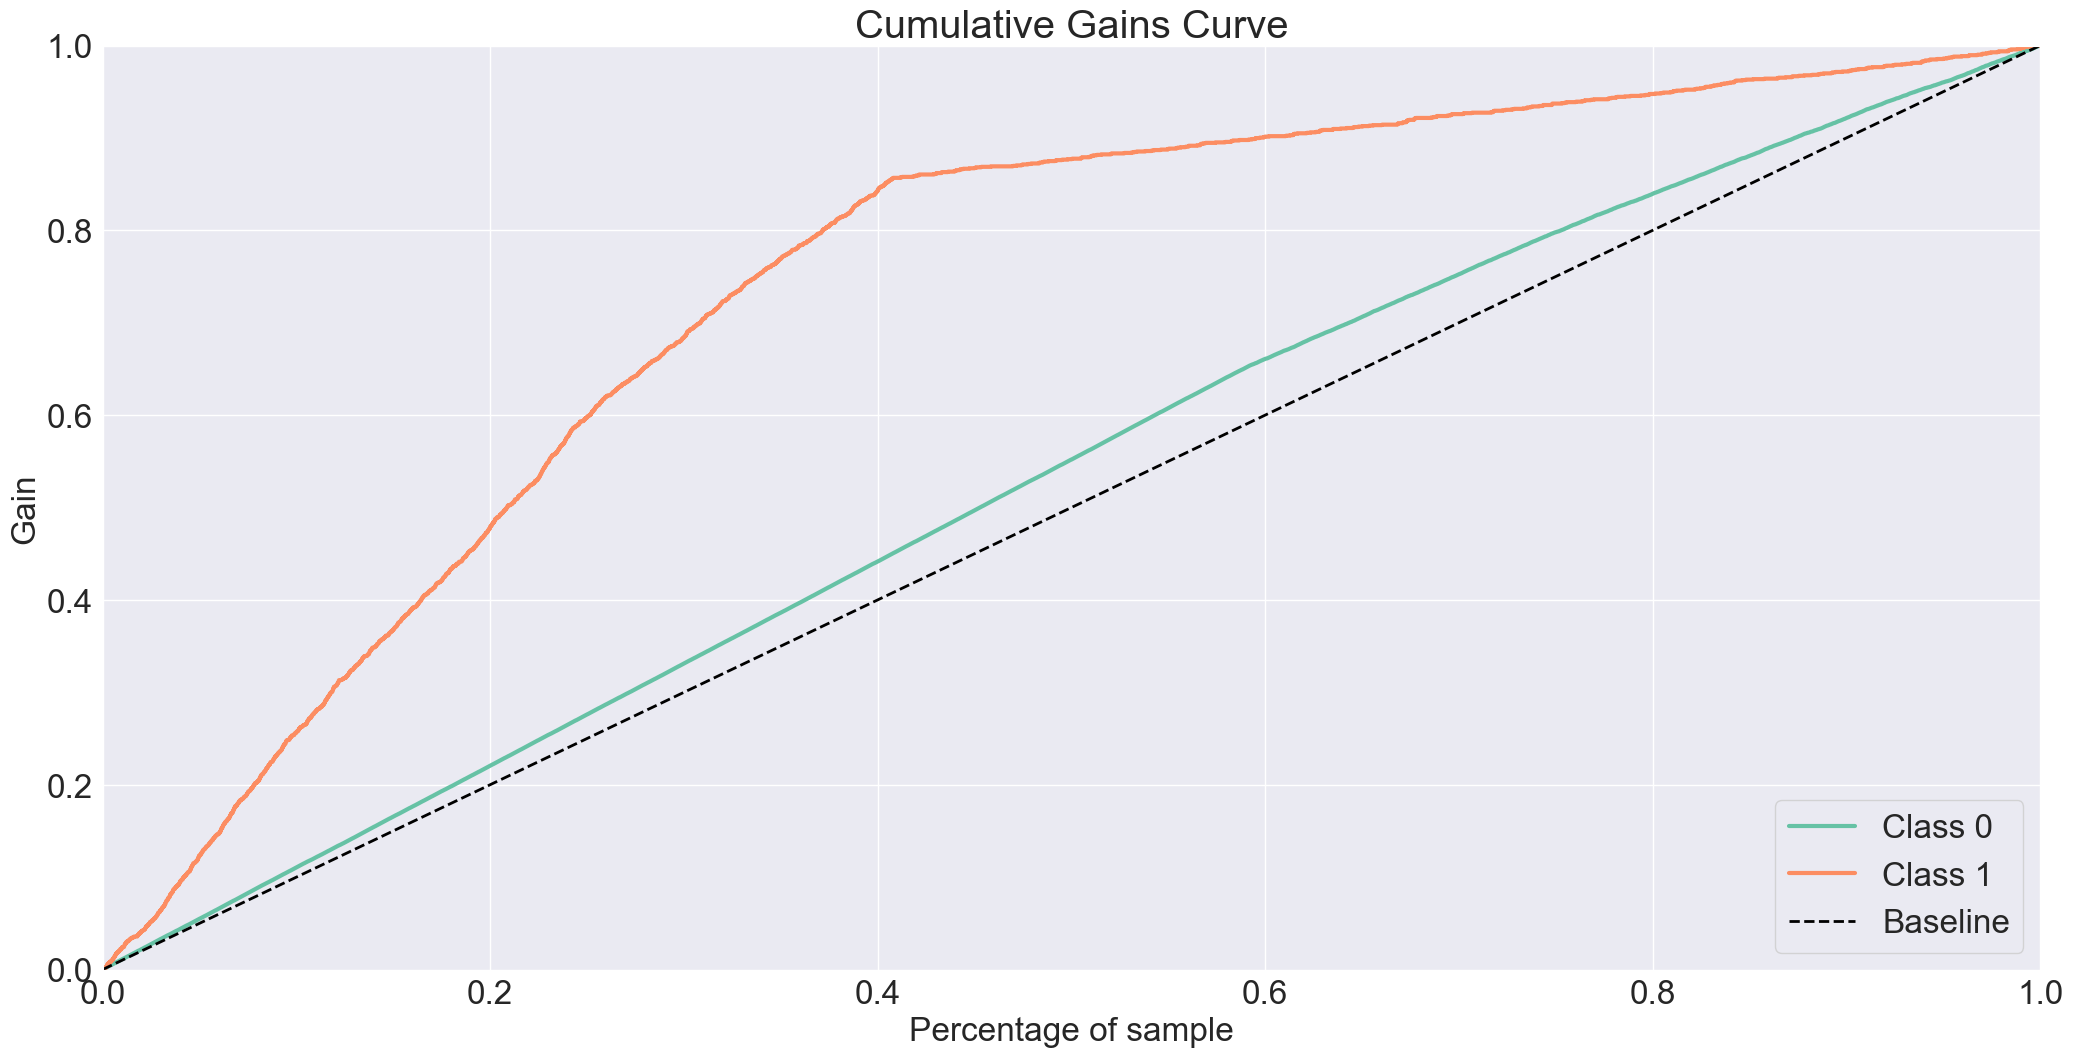

In [550]:
# Accumulative Gain
# Mostra a proporção acumulada de amostras positivas à medida que a amostra é classificada em ordem decrescente de probabilidade
# Permite avaliar a eficácia do modelo em encontrar a maior proporção possível de amostras positivas no topo da lista classificada
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn);

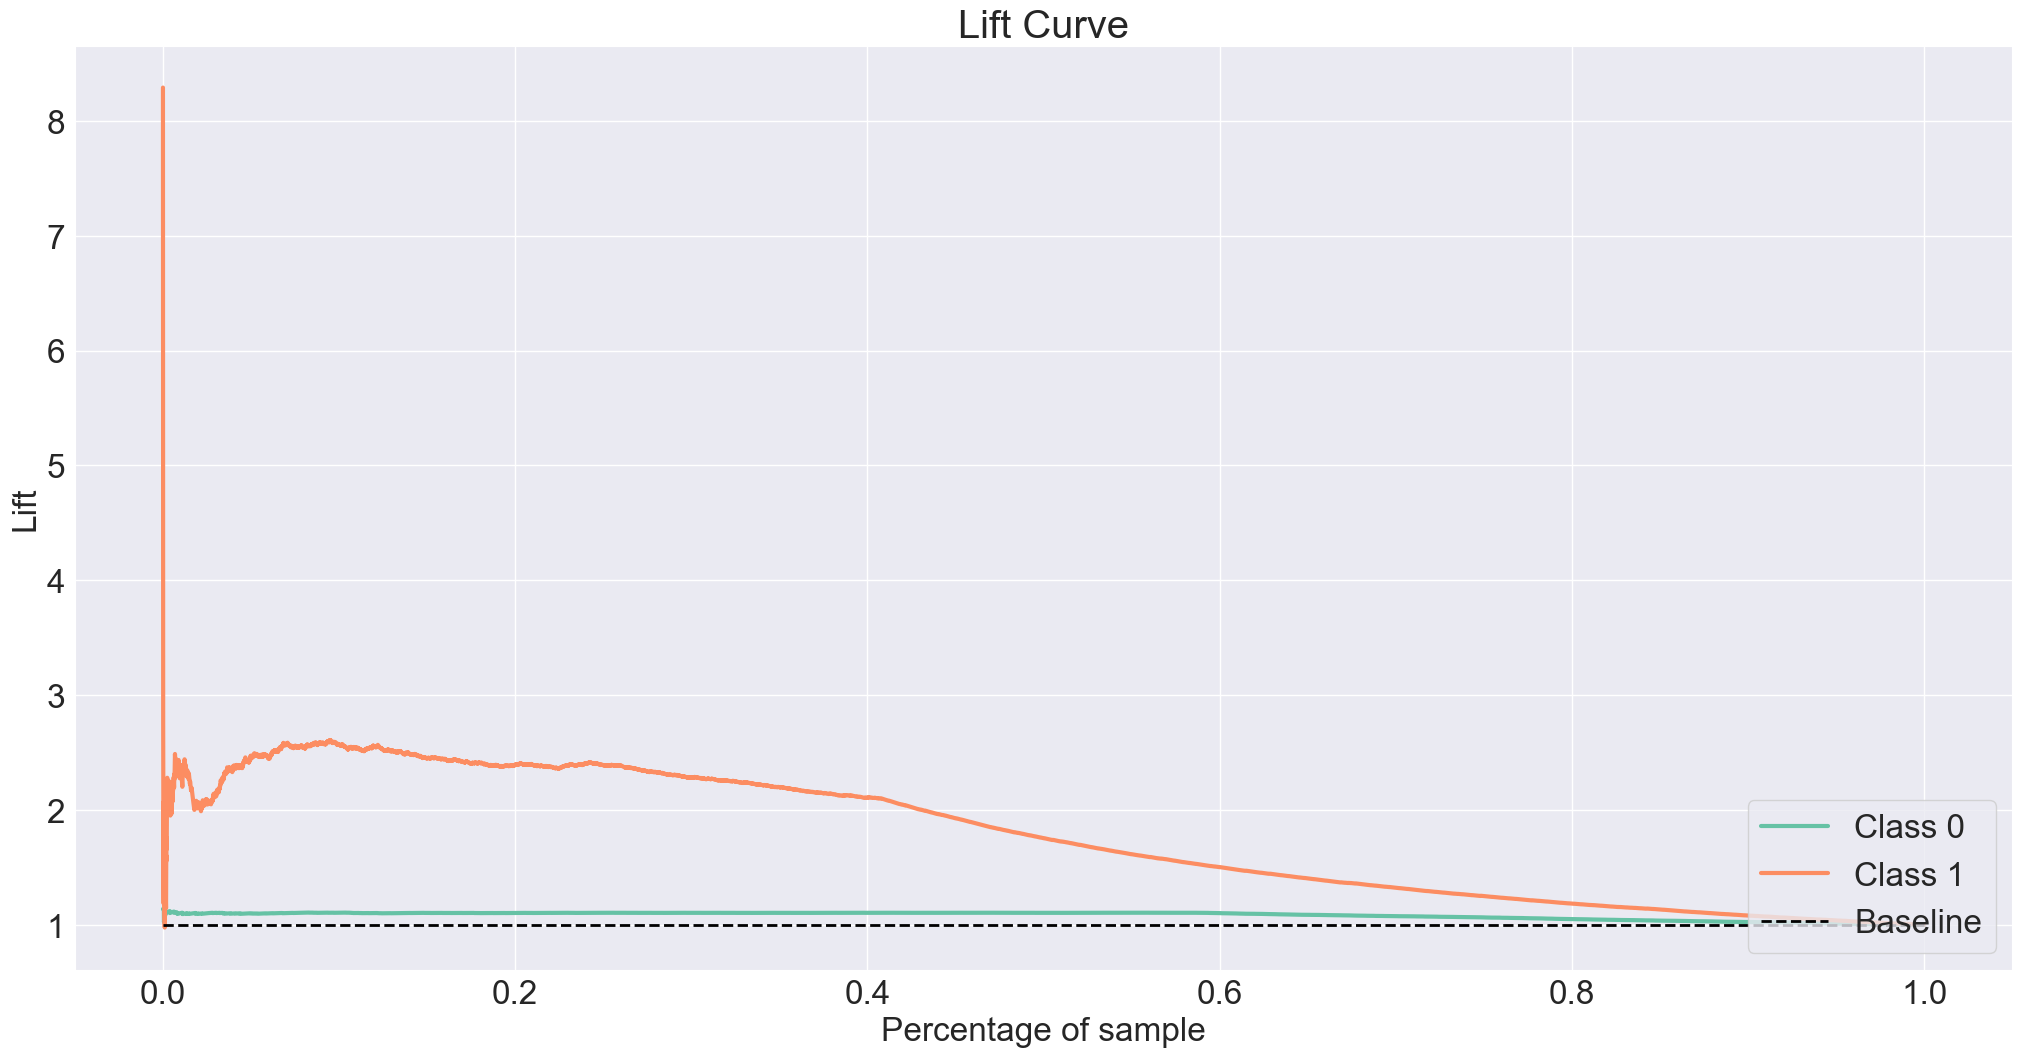

In [551]:
# Lift Curve
# Mostra a proporção de amostras positivas em relação à proporção total de amostras classificadas. 
# Esse gráfico é útil para comparar a performance do modelo com um modelo aleatório.
skplt.metrics.plot_lift_curve(y_val, yhat_knn);

## 7.2. Logistic Regression

In [787]:
# Definição do modelo Logistic Regression
lr_model = lm.LogisticRegression(random_state=42) 

# Treinamento do modelo
lr_model.fit(x_train, y_train)

# Previsão do modelo no conjunto de validação
yhat_lr = lr_model.predict_proba(x_val)


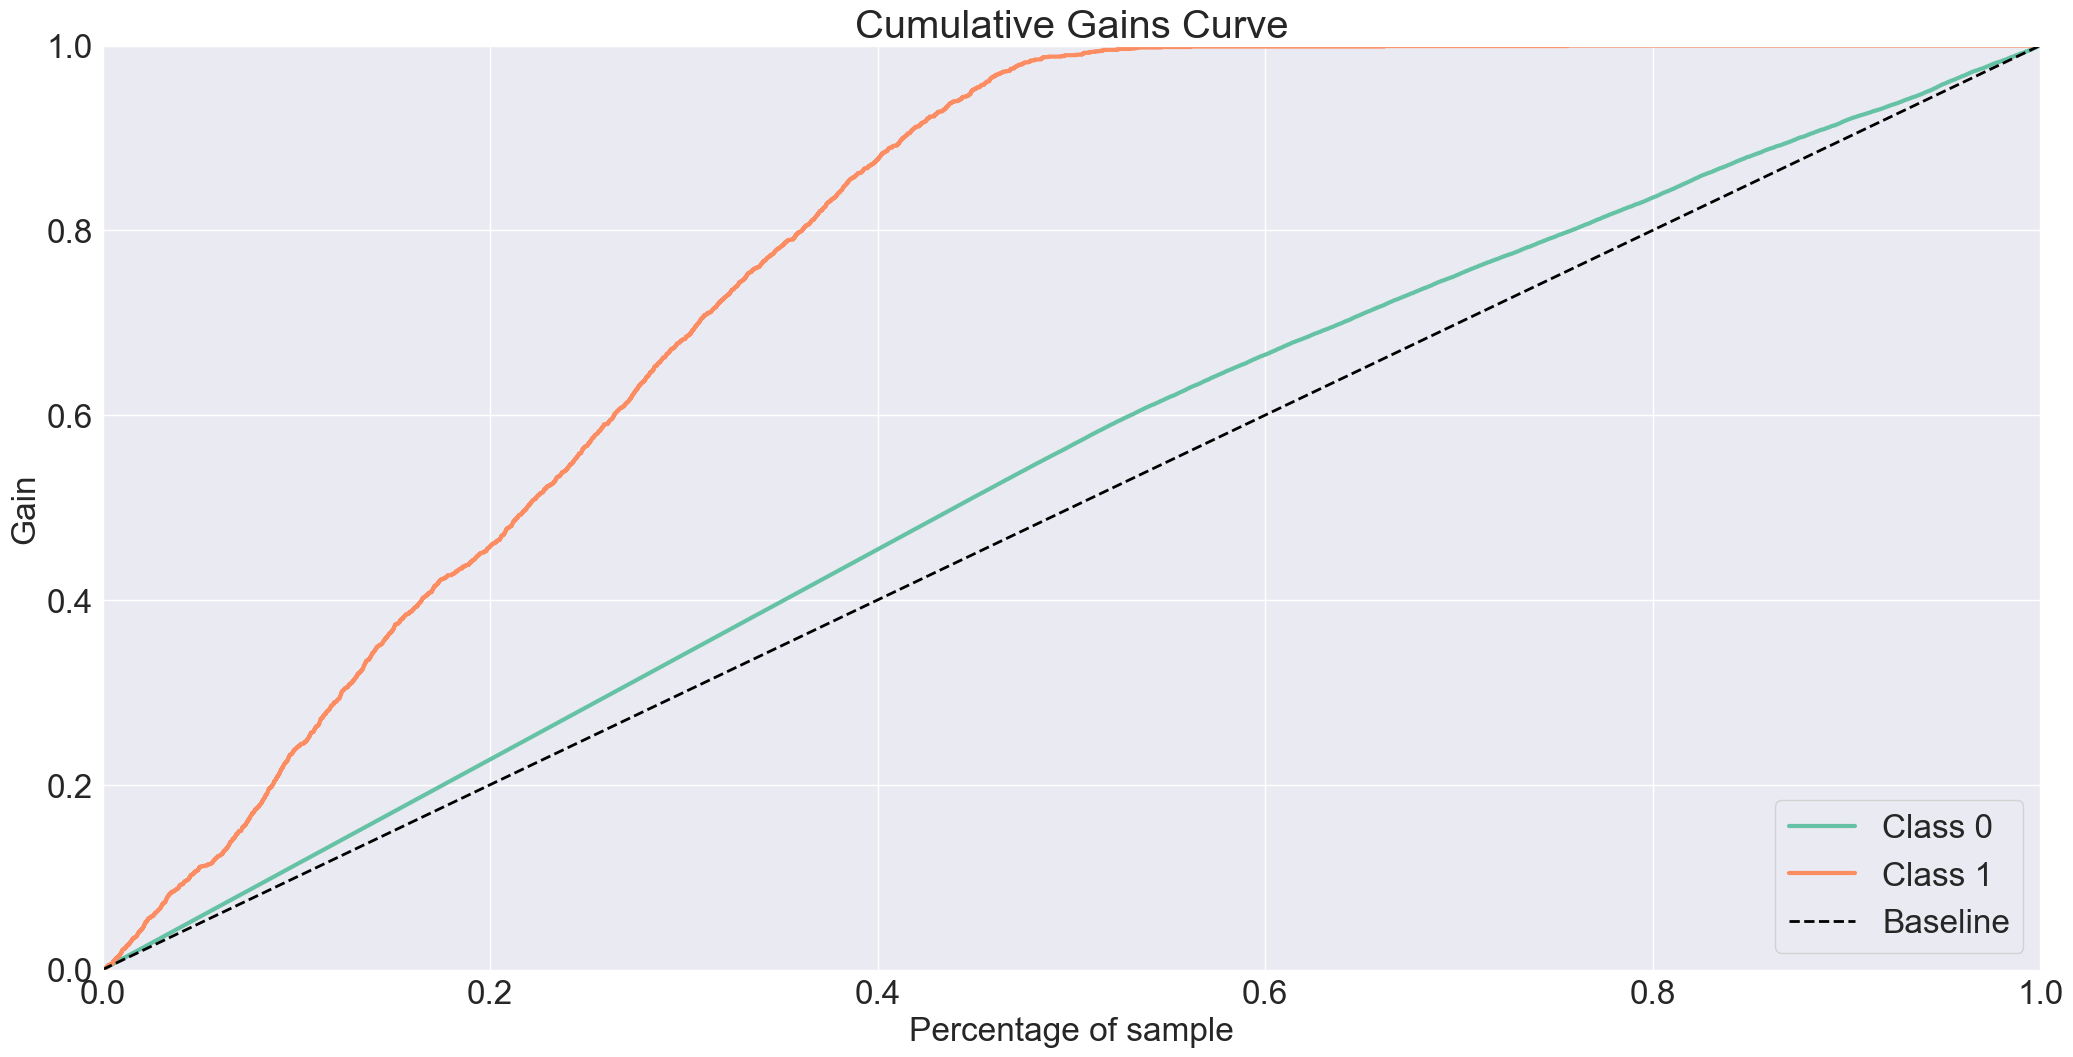

In [553]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr);

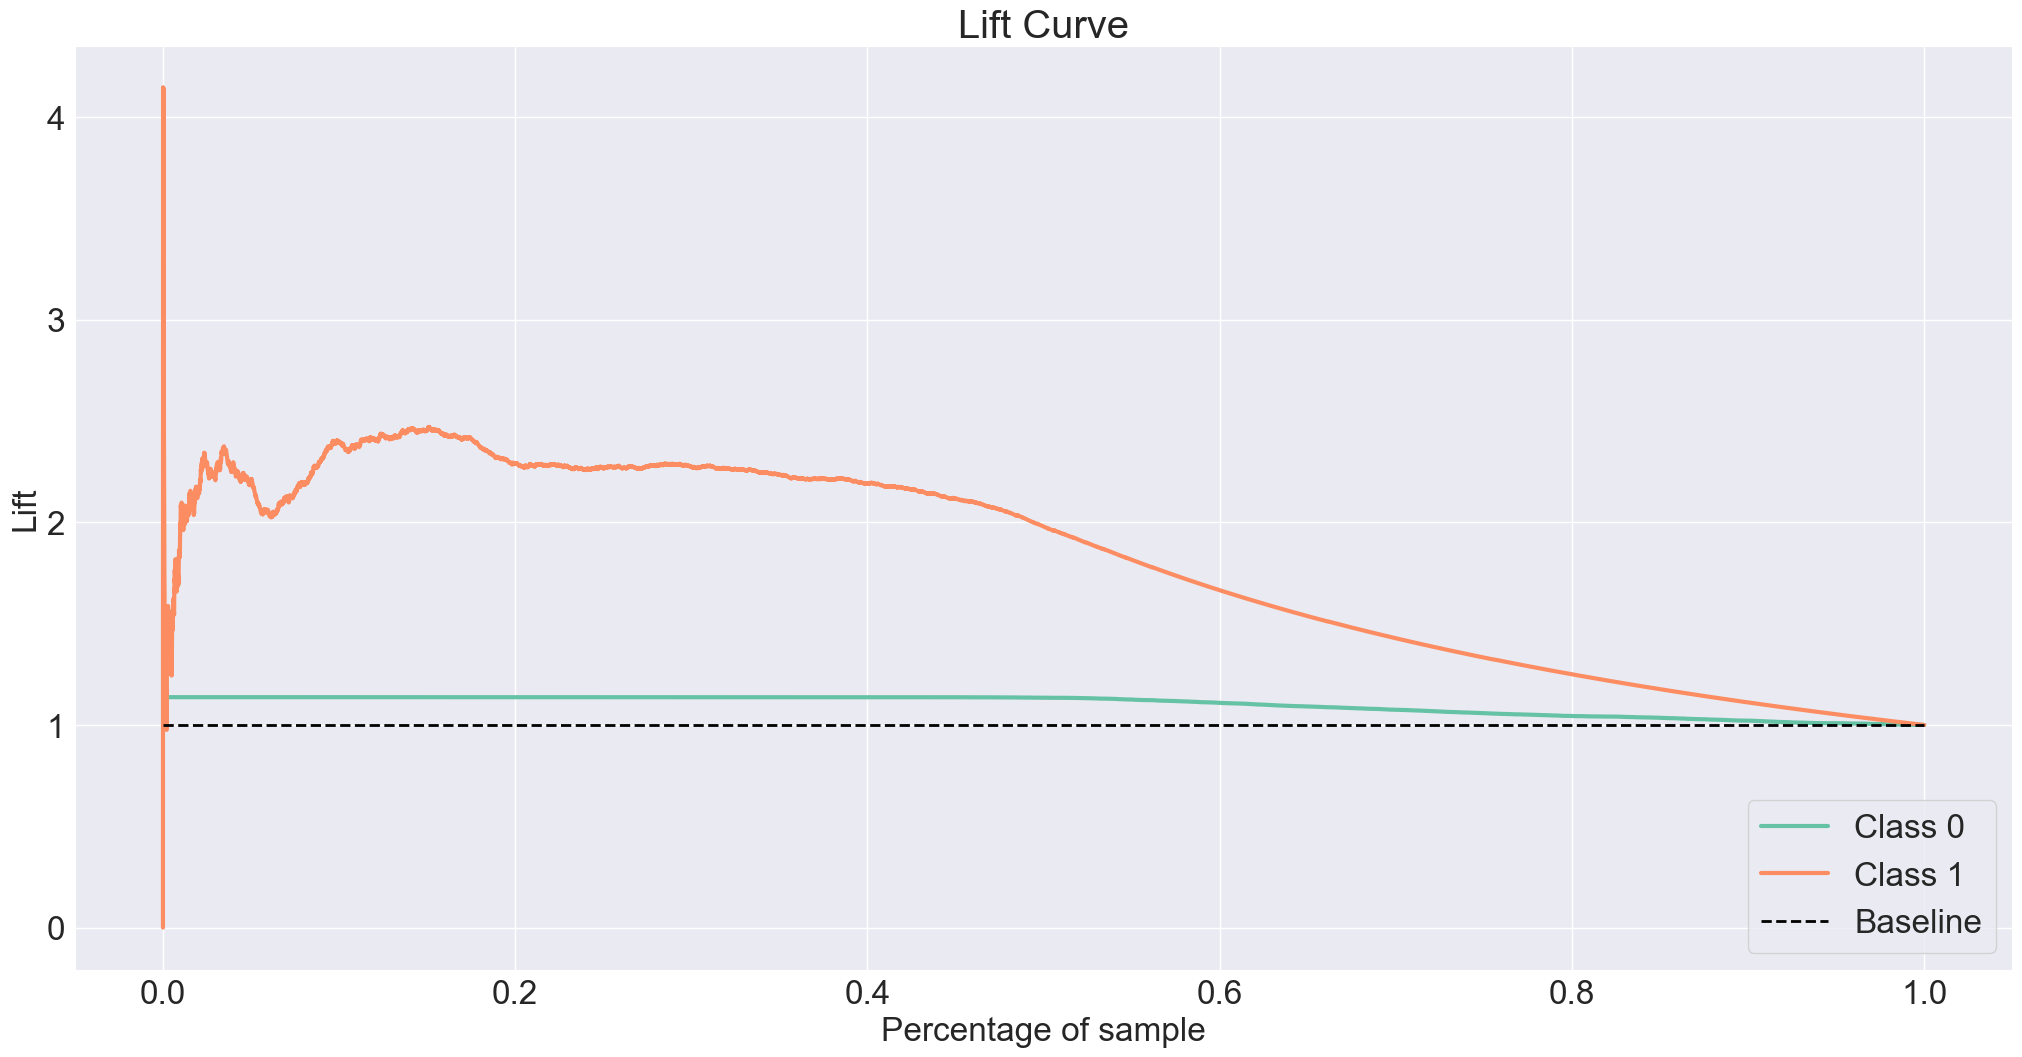

In [554]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_lr);

## 7.3. Extra Trees Classifier

In [555]:
# Definição do modelo Extra Trees Classifier
et_model = en.ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, random_state=42) 

# Treinamento do modelo
et_model.fit(x_train, y_train)

# Previsão do modelo no conjunto de validação
yhat_et = et_model.predict_proba(x_val)


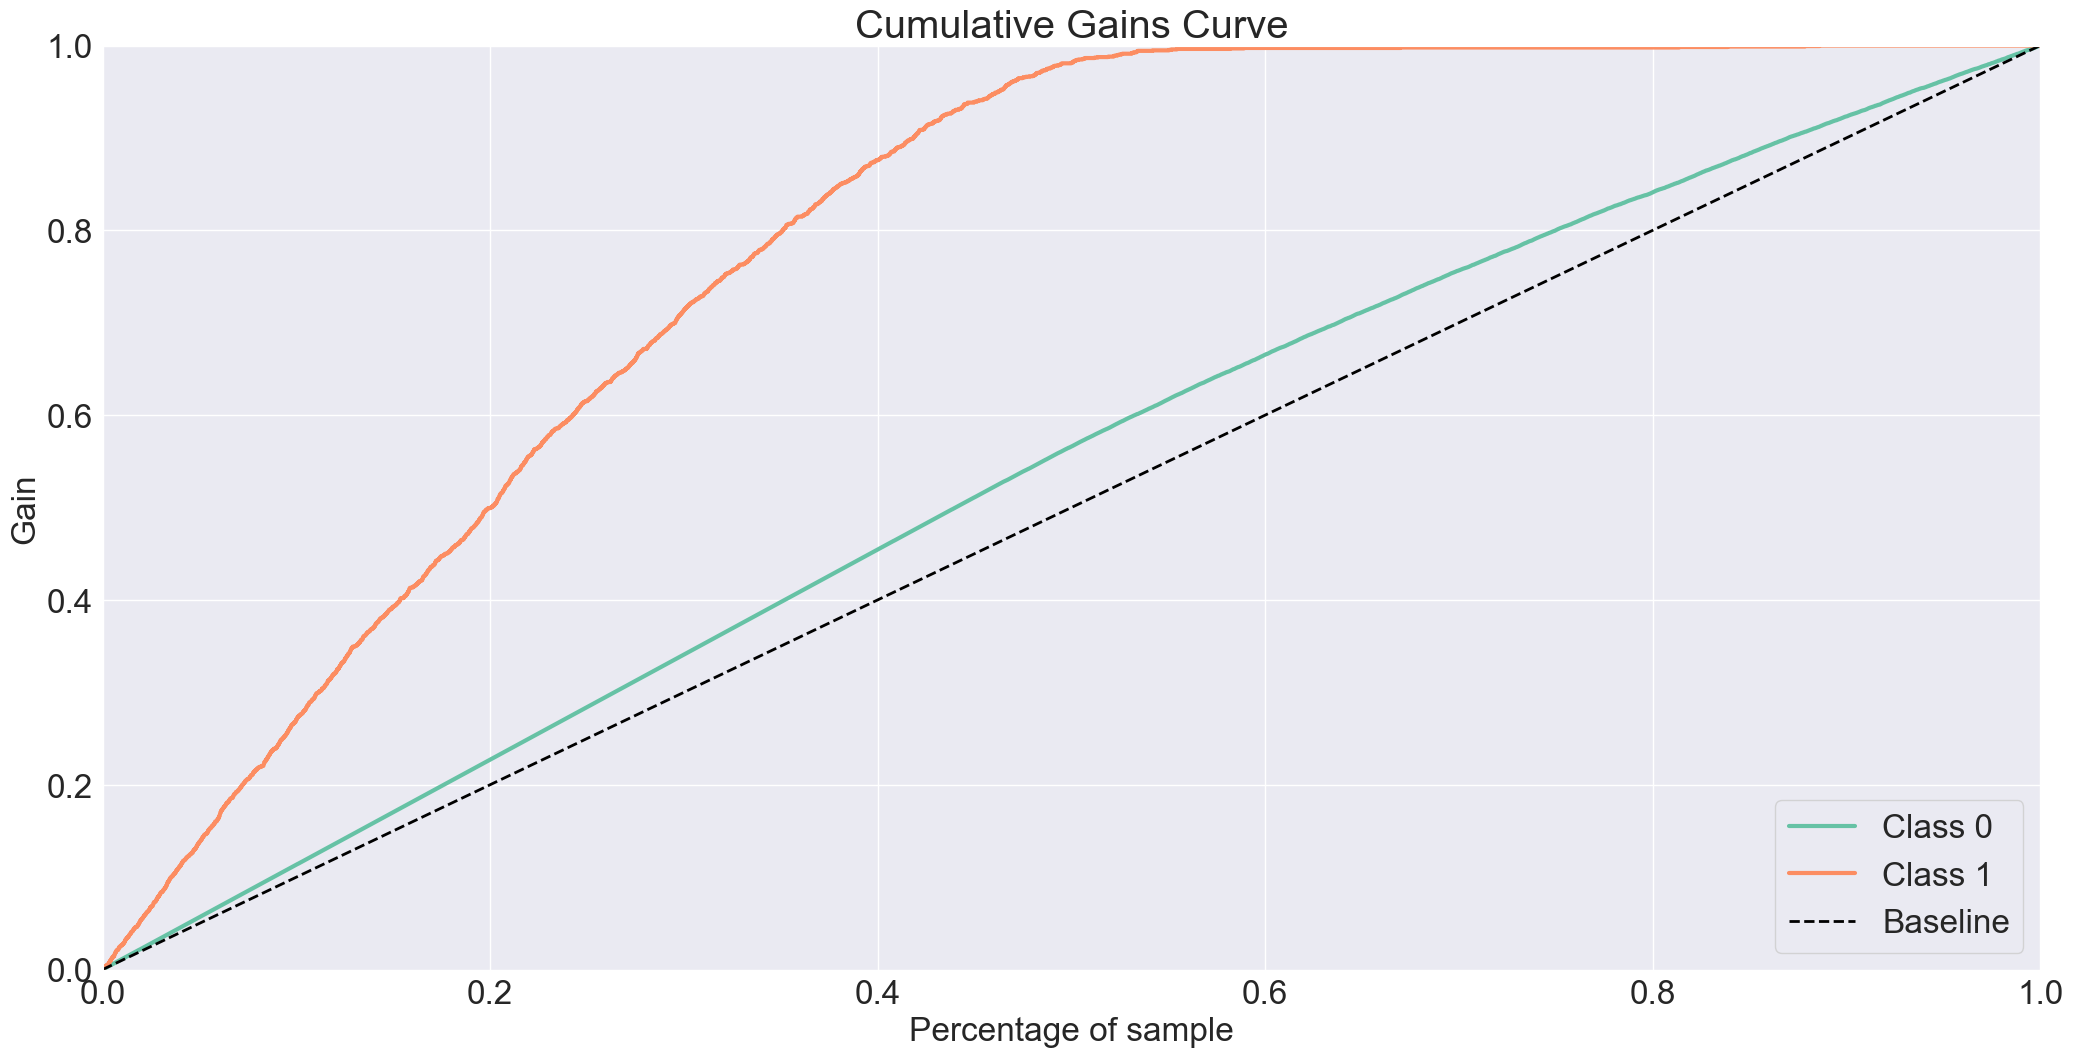

In [556]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_et);

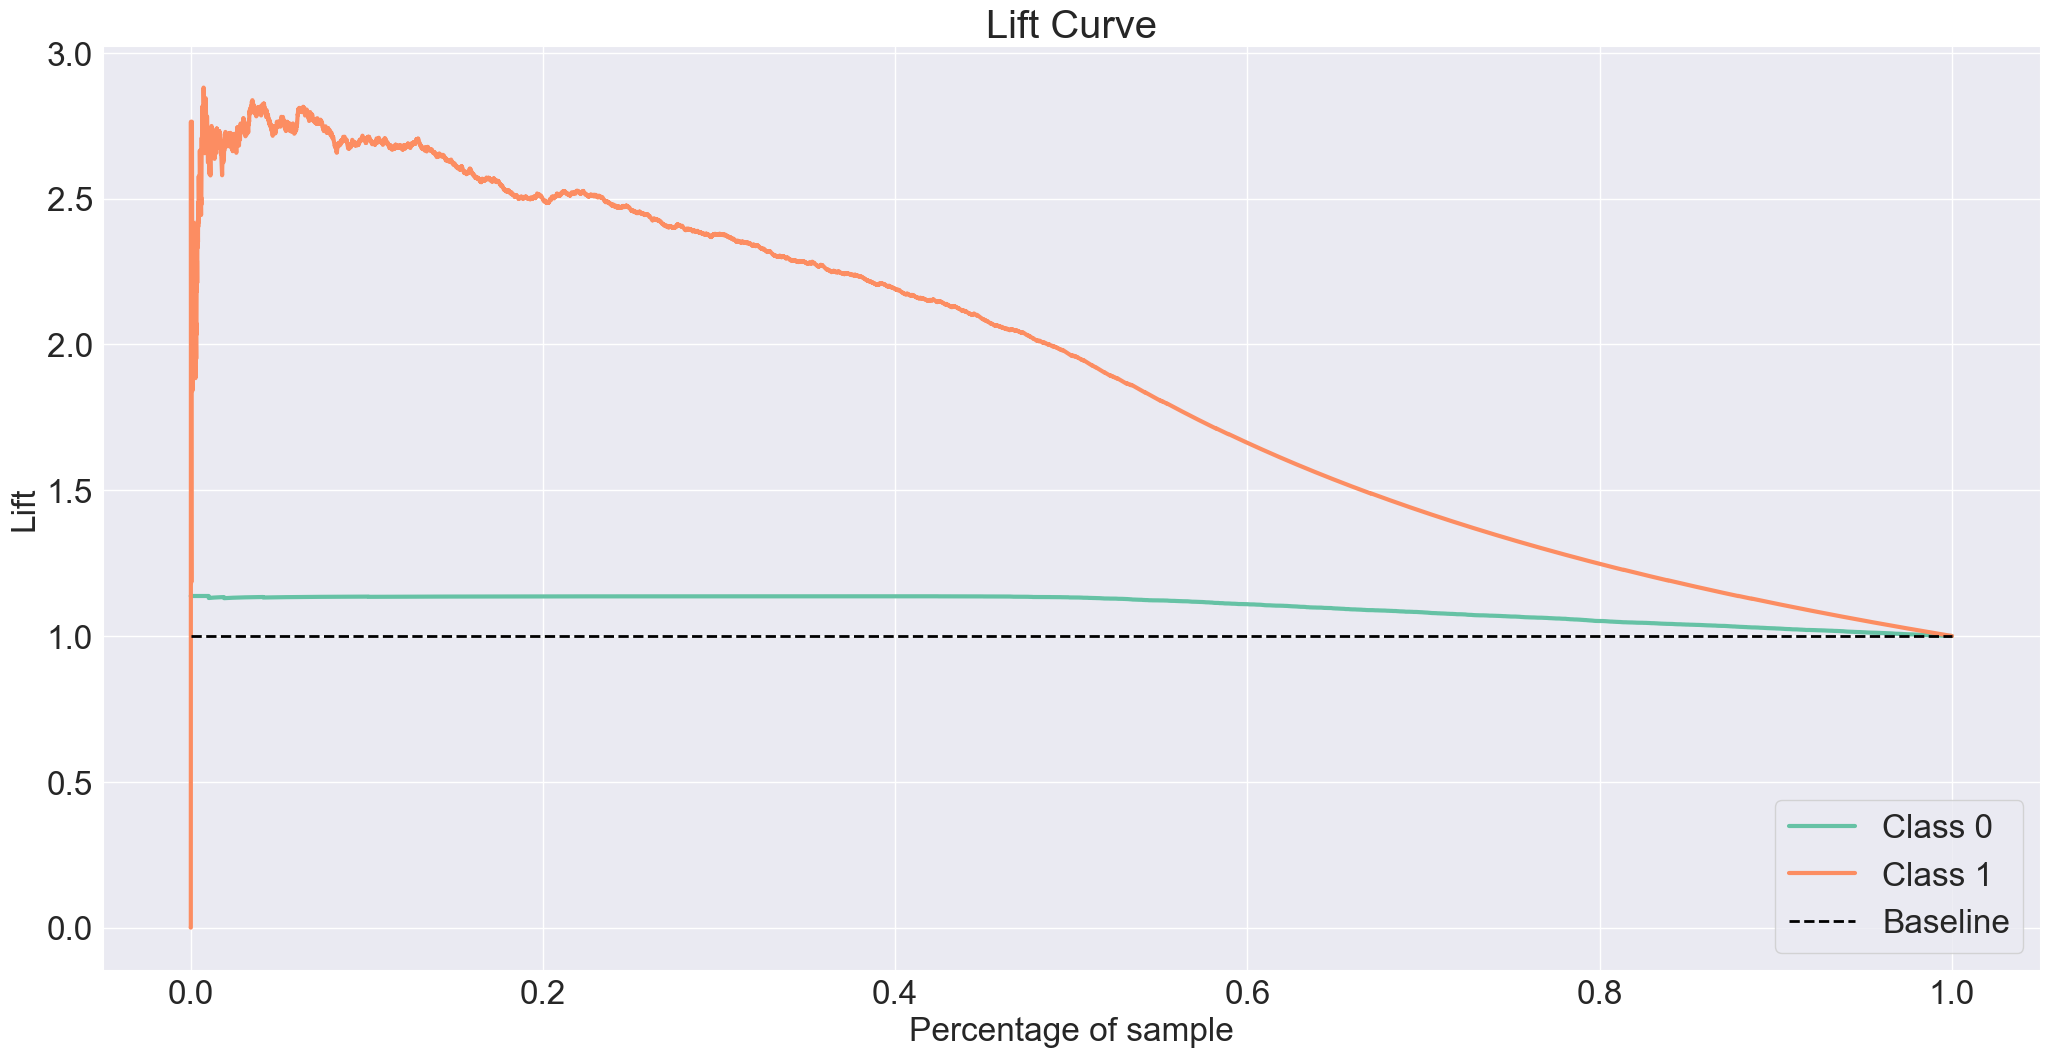

In [557]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_et);

## 7.4. Random Forest

In [558]:
# Definição do modelo Random Forest
rf_model = en.RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42) 

# Treinamento do modelo
rf_model.fit(x_train, y_train)

# Previsão do modelo no conjunto de validação
yhat_rf = rf_model.predict_proba(x_val)

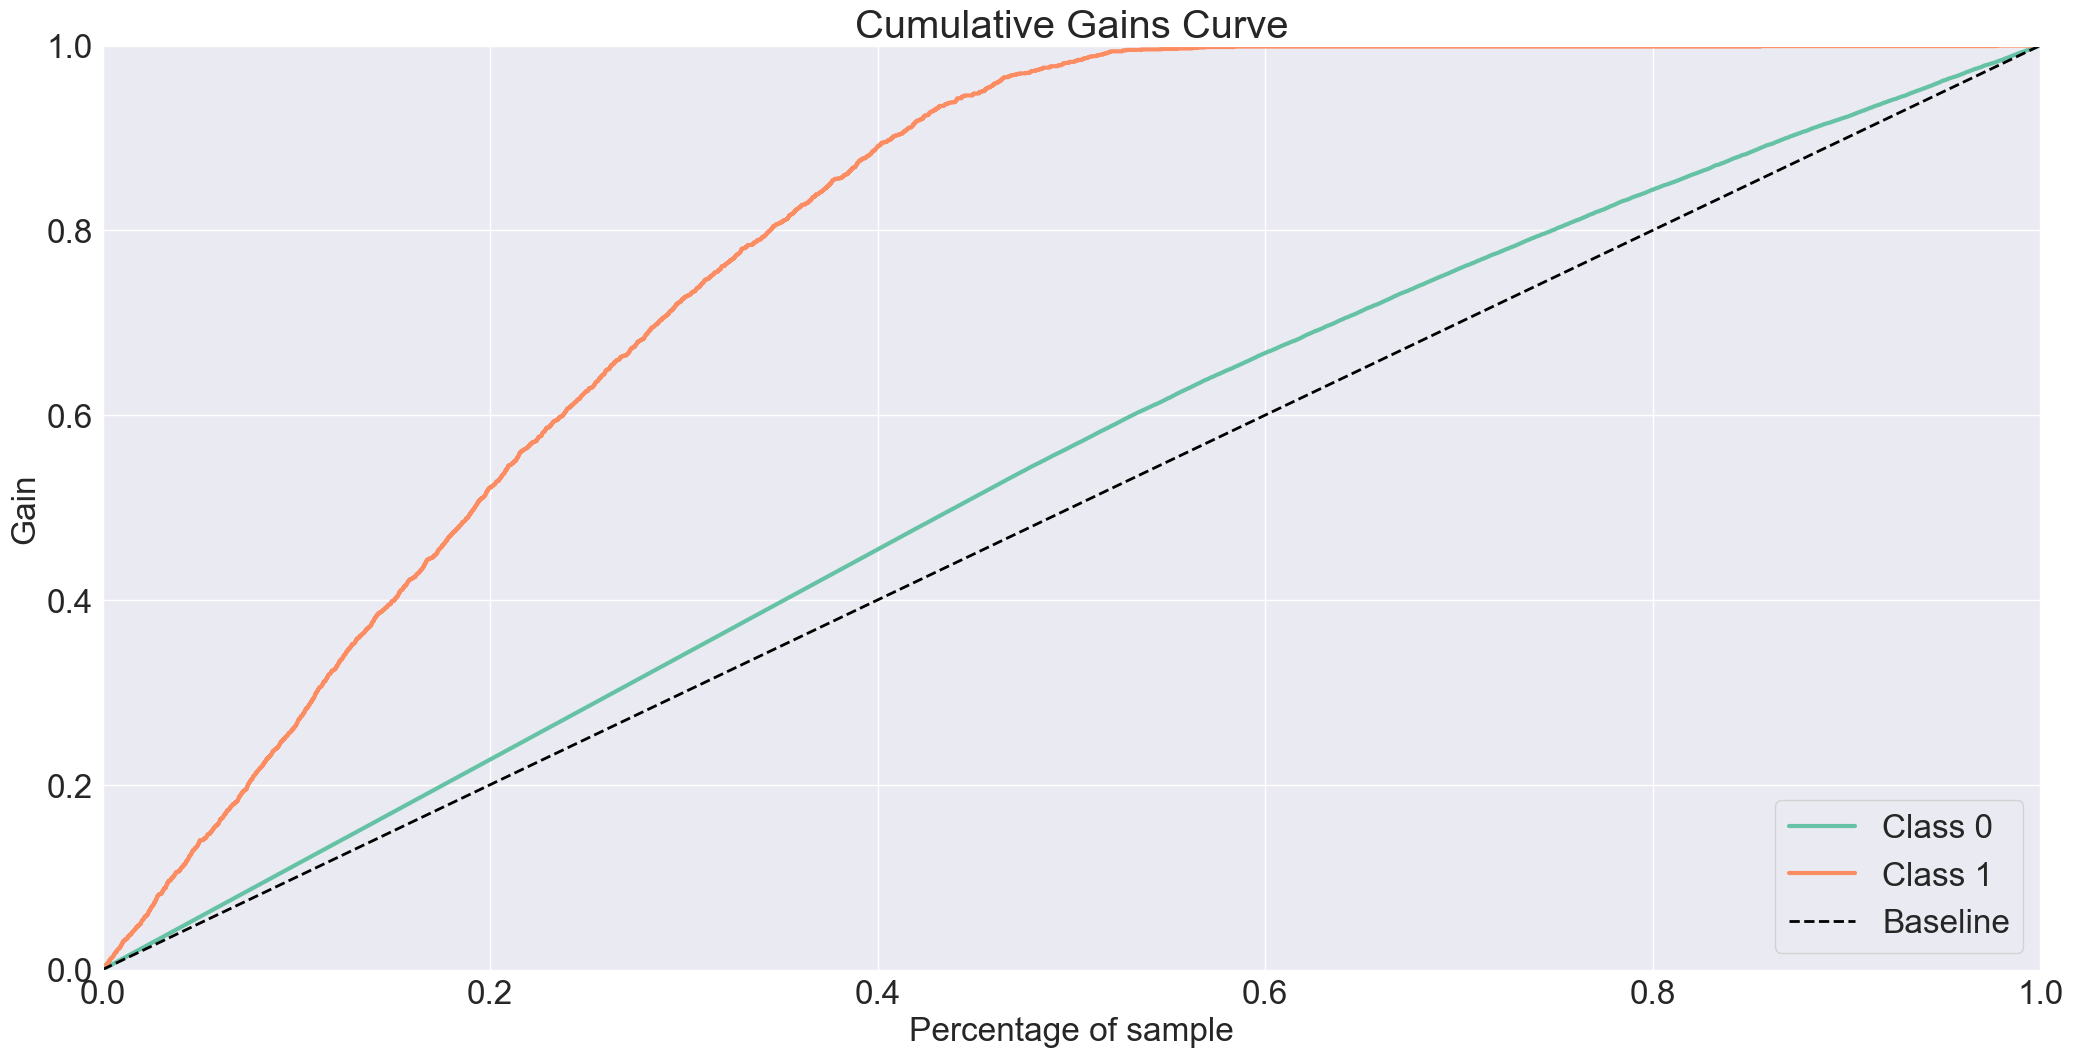

In [559]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf);

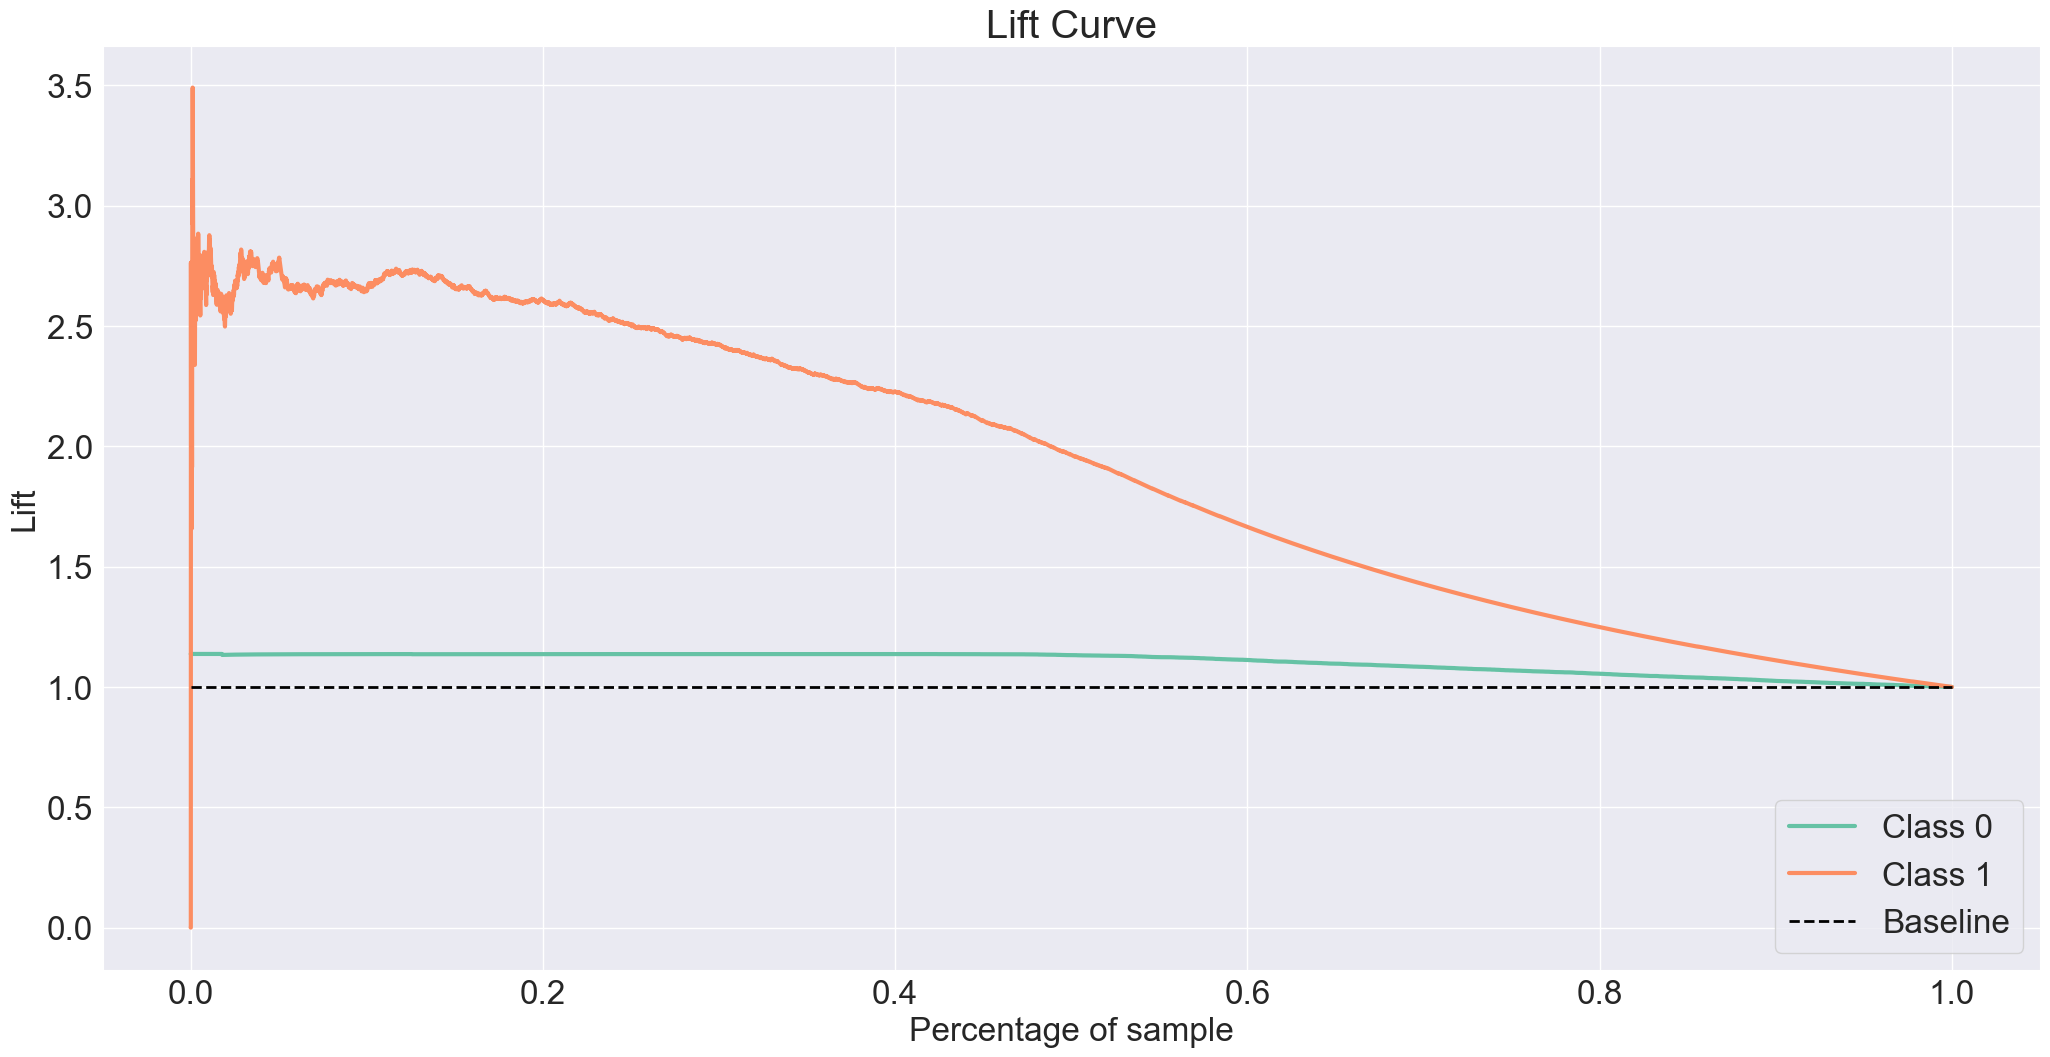

In [560]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_rf);

## 7.5. XGBoost

In [561]:
# Definição do modelo XGBoost
xgb_model = XGBClassifier(n_estimators=1000, n_jobs=-1, random_state=42) 

# Treinamento do modelo
xgb_model.fit(x_train, y_train)

# Previsão do modelo no conjunto de validação
yhat_xgb = xgb_model.predict_proba(x_val)

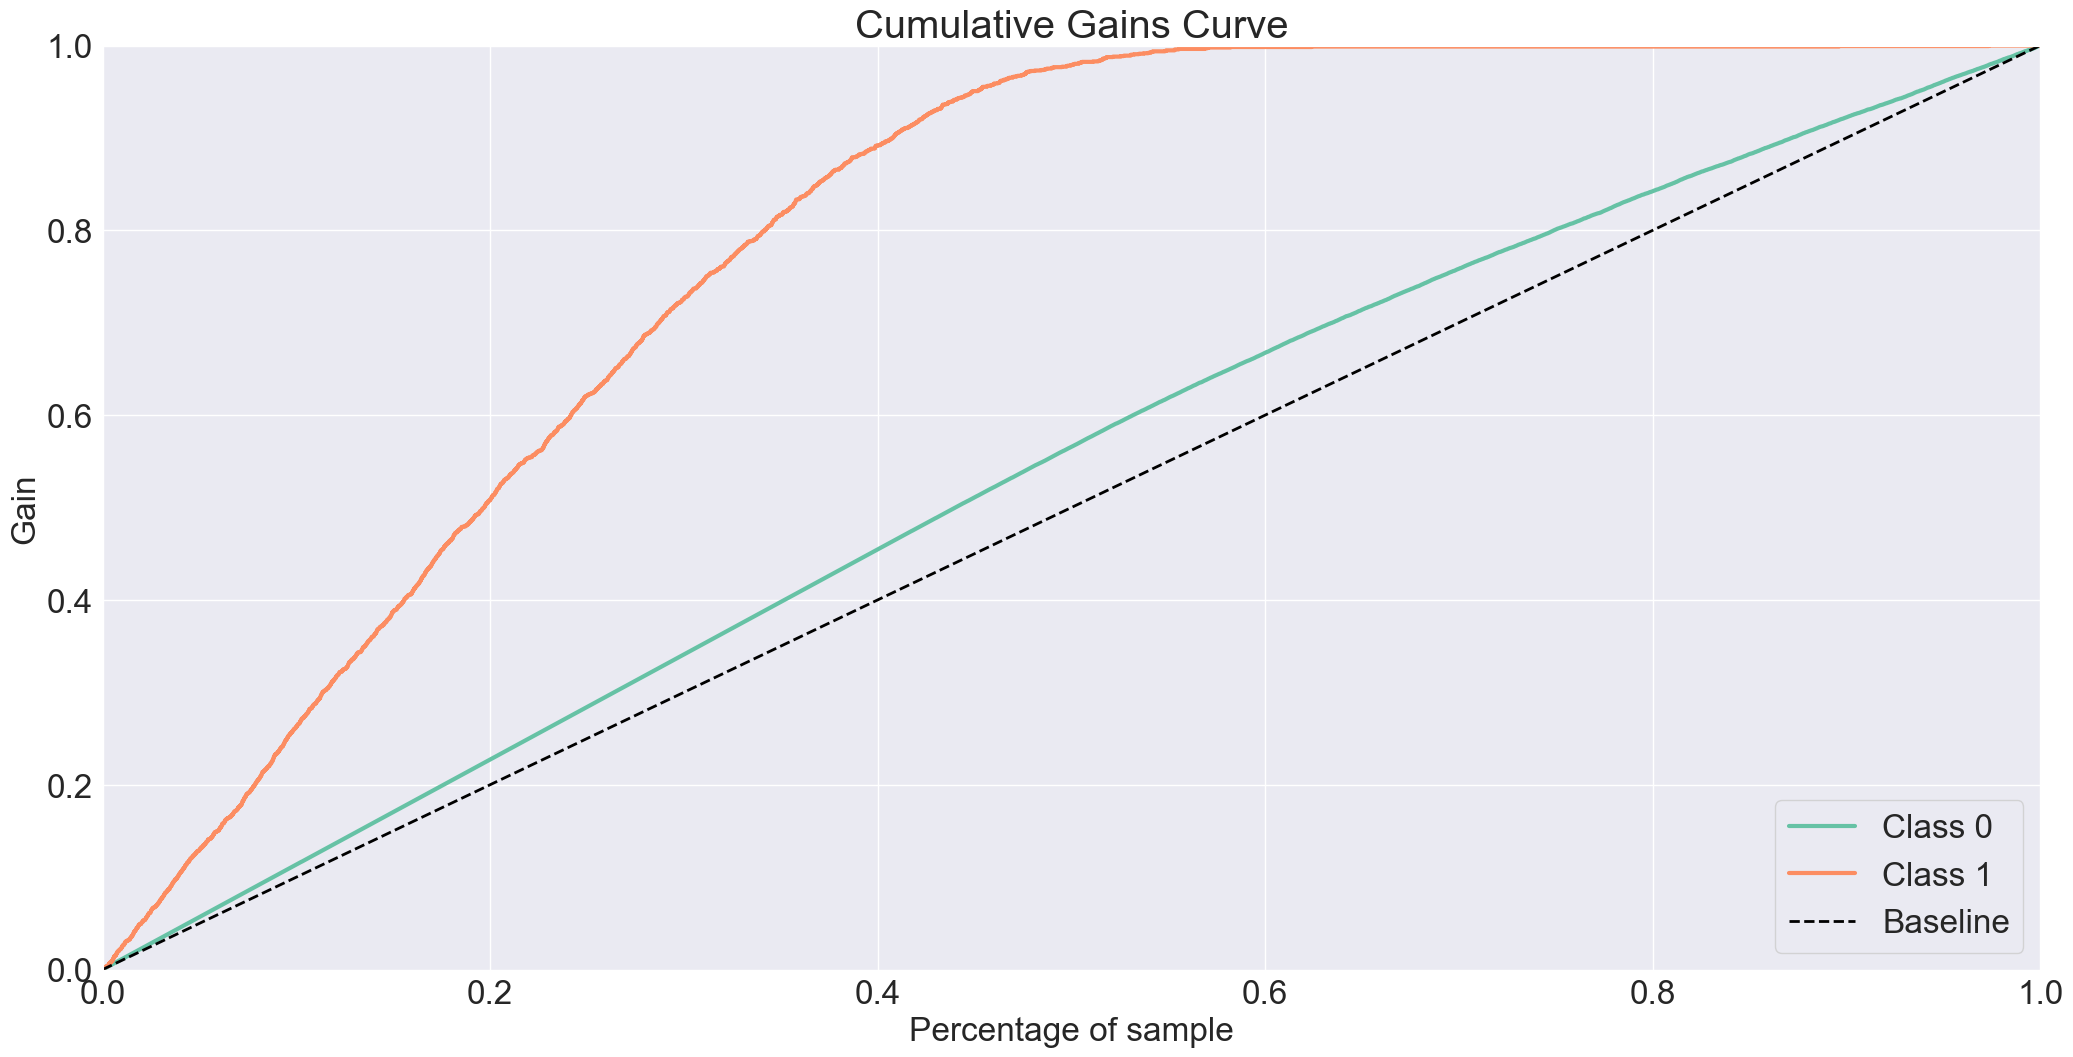

In [562]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb);

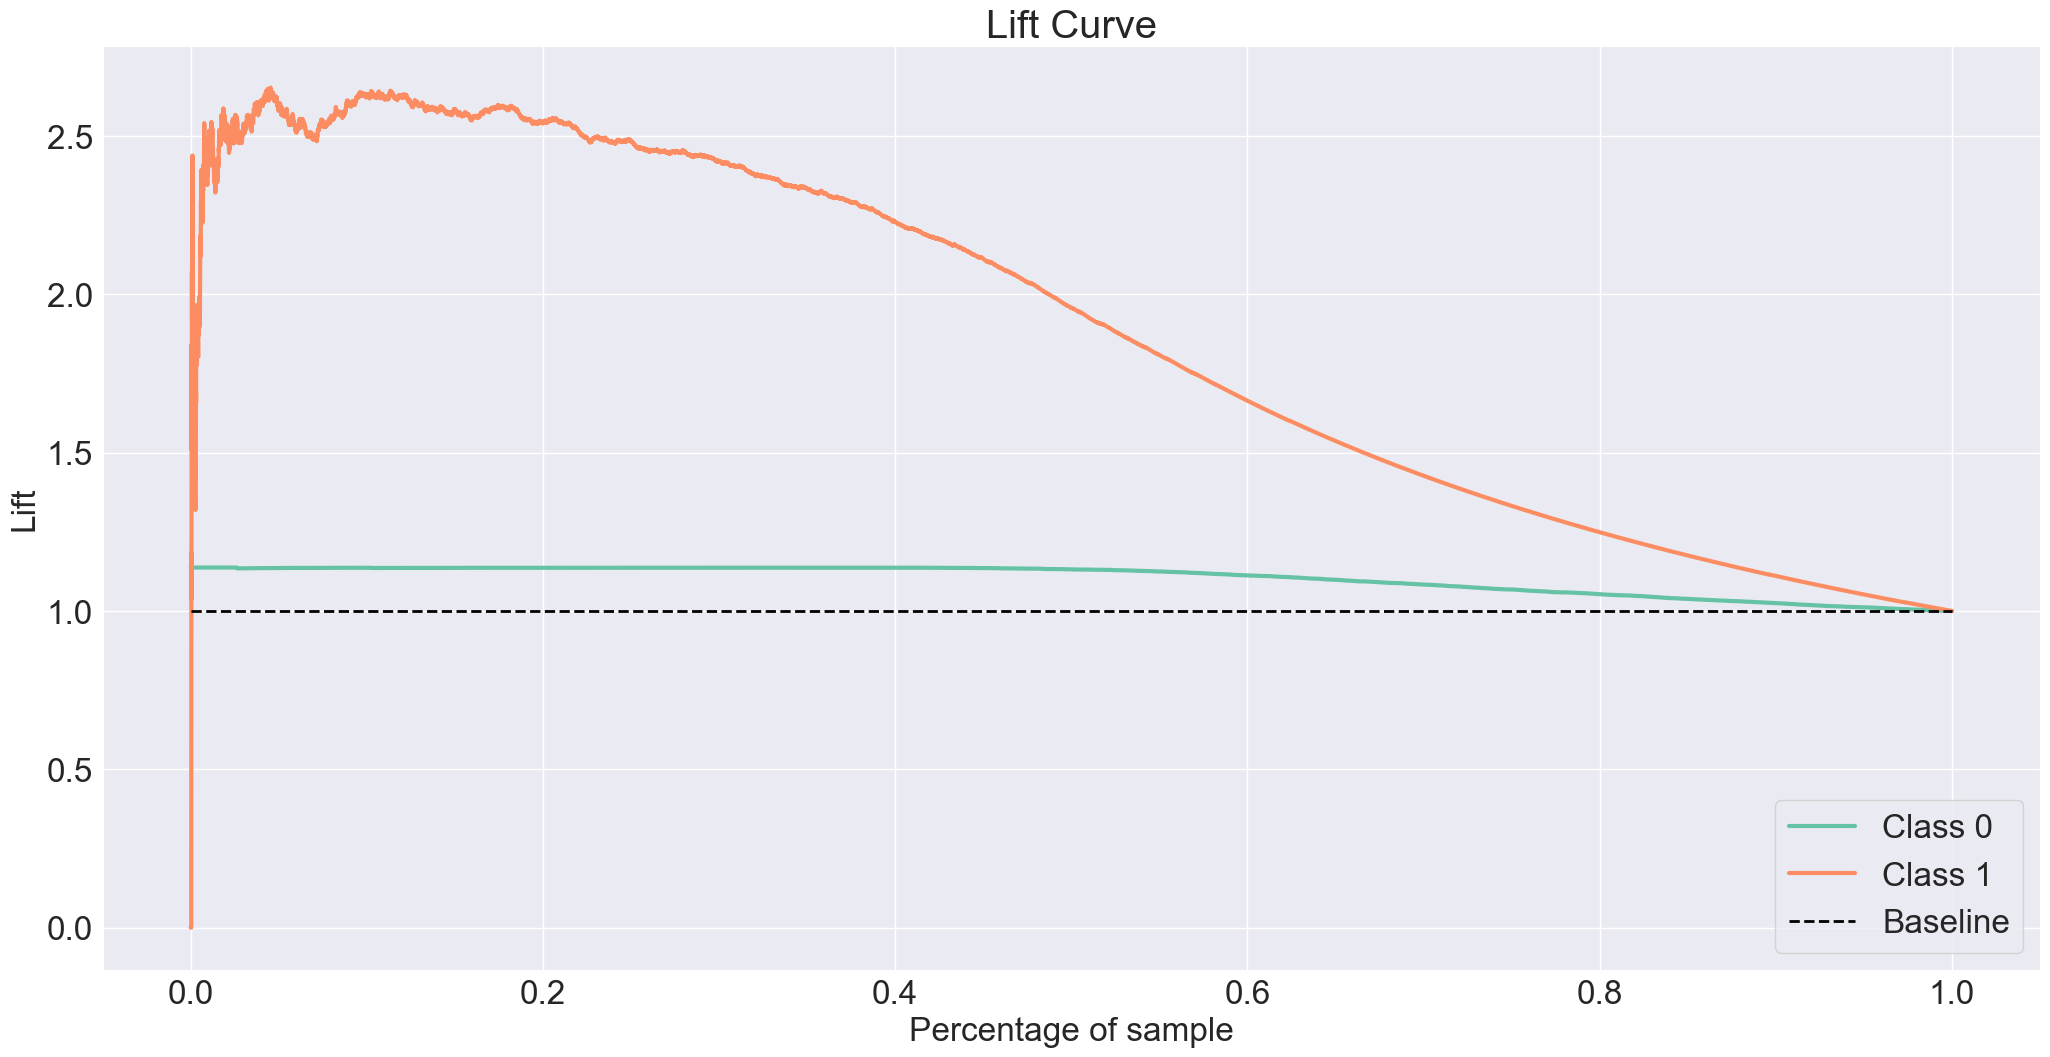

In [563]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_xgb);

## 7.6. LGBM

In [564]:
# Definição do modelo lgbm
lgbm_model = LGBMClassifier(n_estimators=1000, n_jobs=-1, random_state=42) 

# Treinamento do modelo
lgbm_model.fit(x_train, y_train)

# Previsão do modelo no conjunto de validação
yhat_lgbm= lgbm_model.predict_proba(x_val)

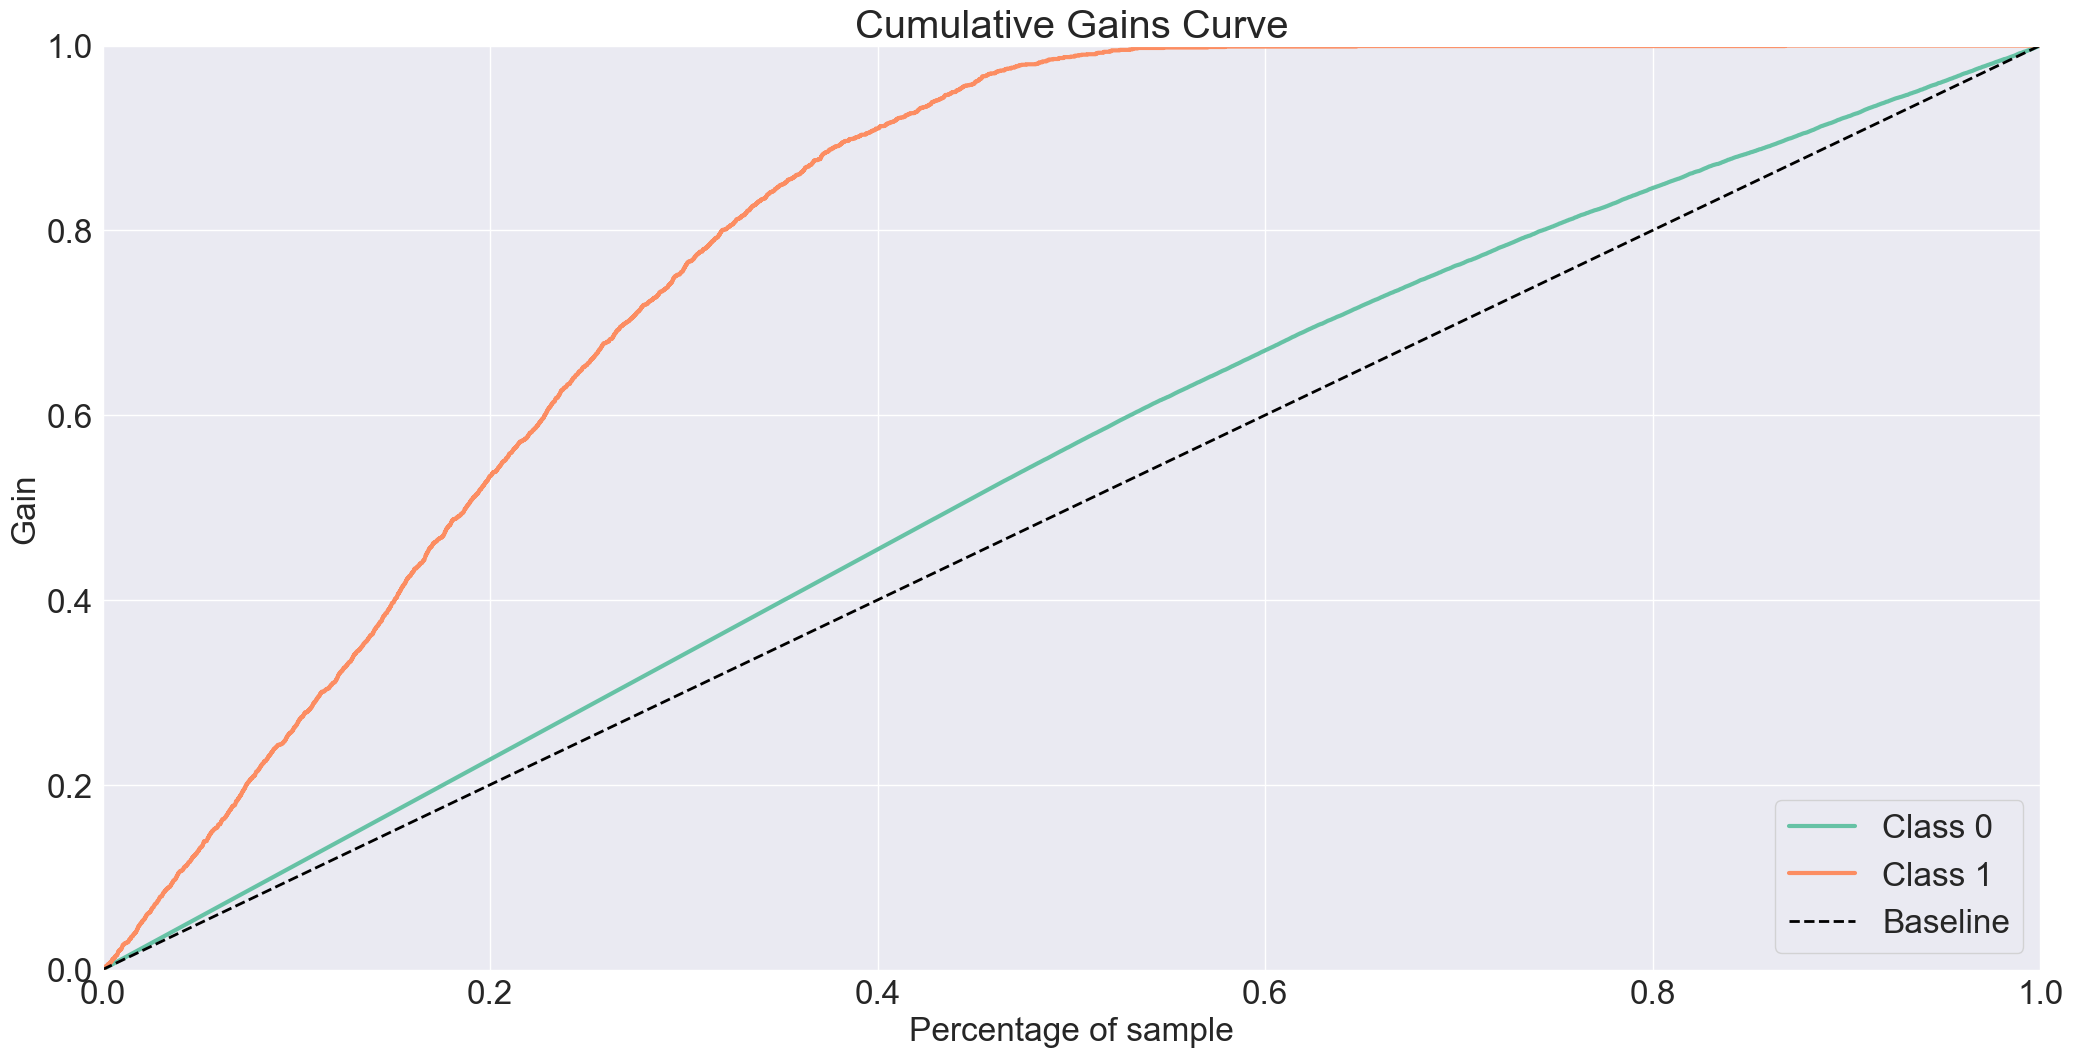

In [565]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lgbm);

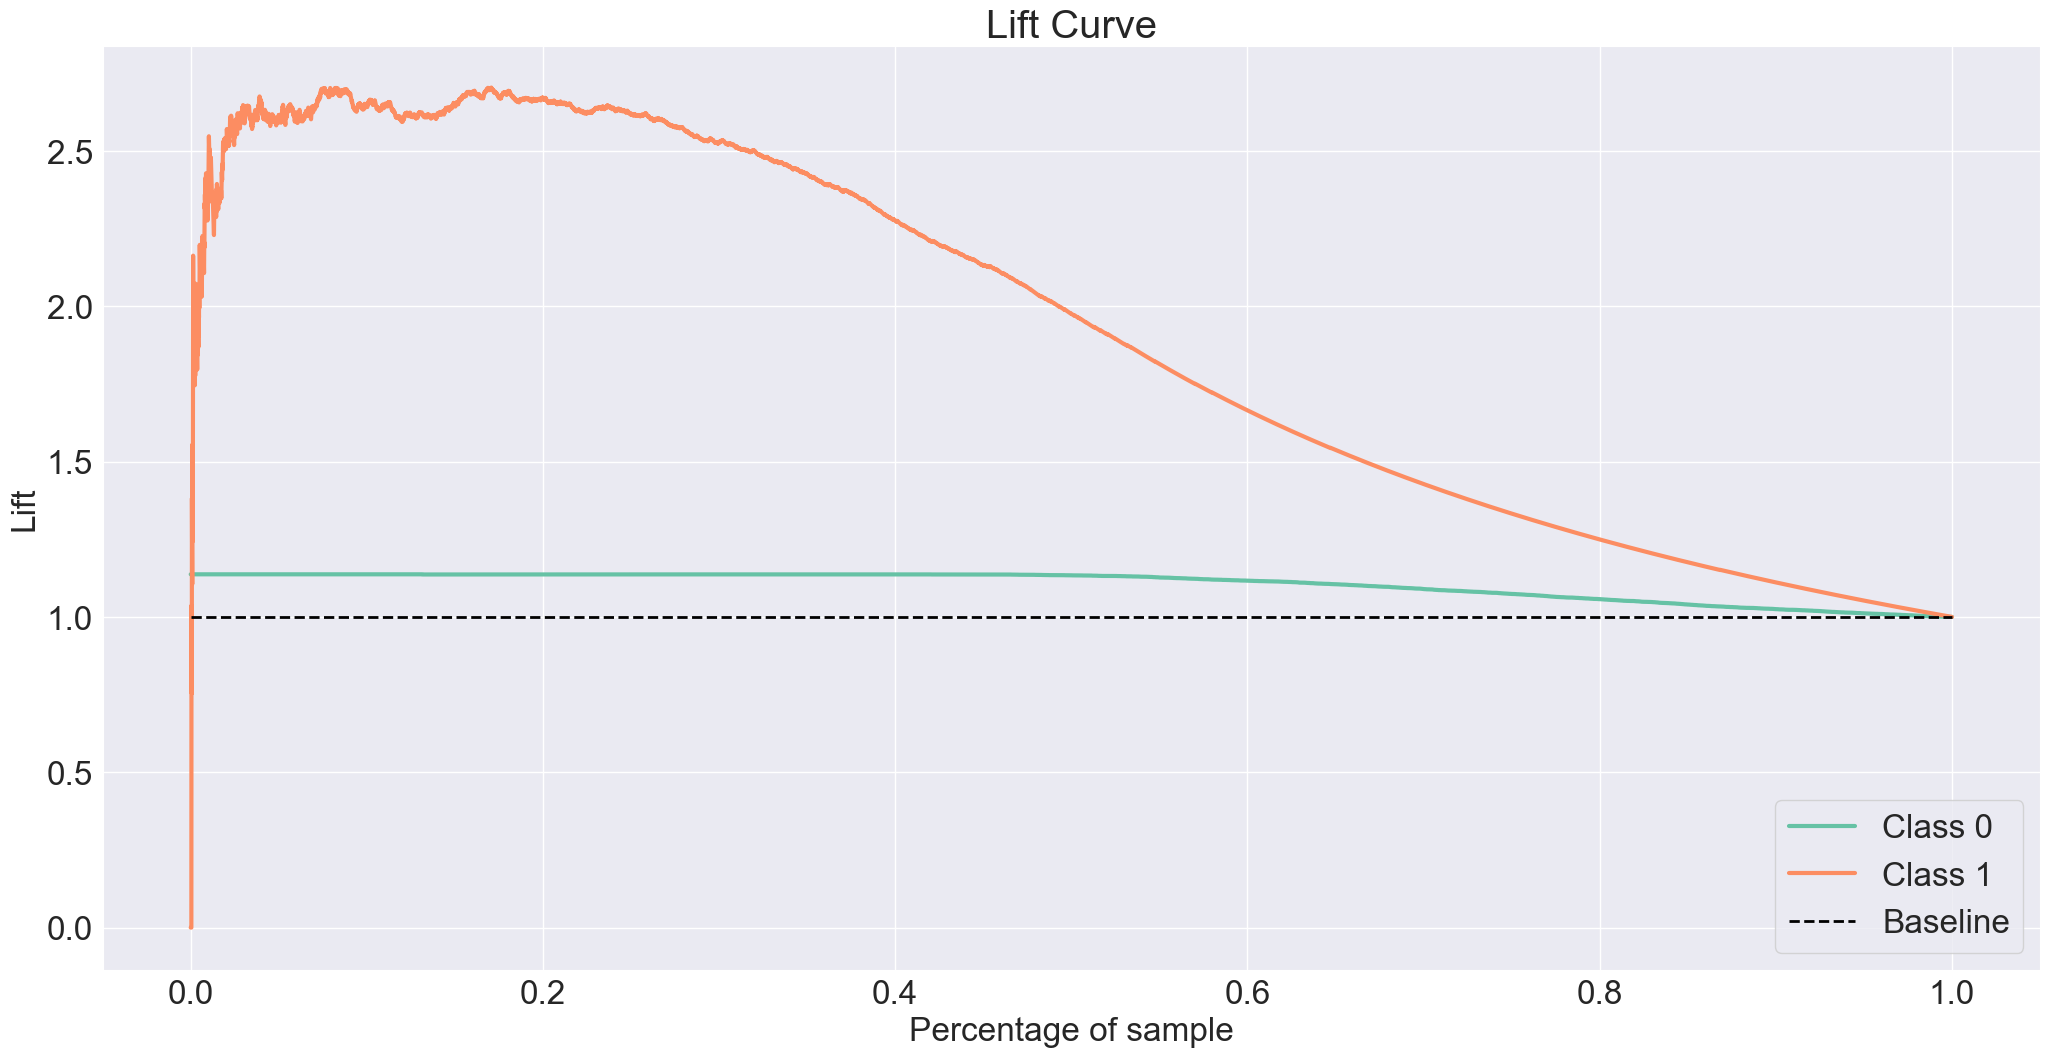

In [566]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_lgbm);

## 7.7. CatBoost

In [567]:
# Definição do modelo CatBoost
cat_model = CatBoostClassifier(verbose=False, random_seed=42)

# Treinamento do modelo
cat_model.fit(x_train, y_train)

# Previsão do modelo no conjunto de validação
yhat_cat = cat_model.predict_proba(x_val) 

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

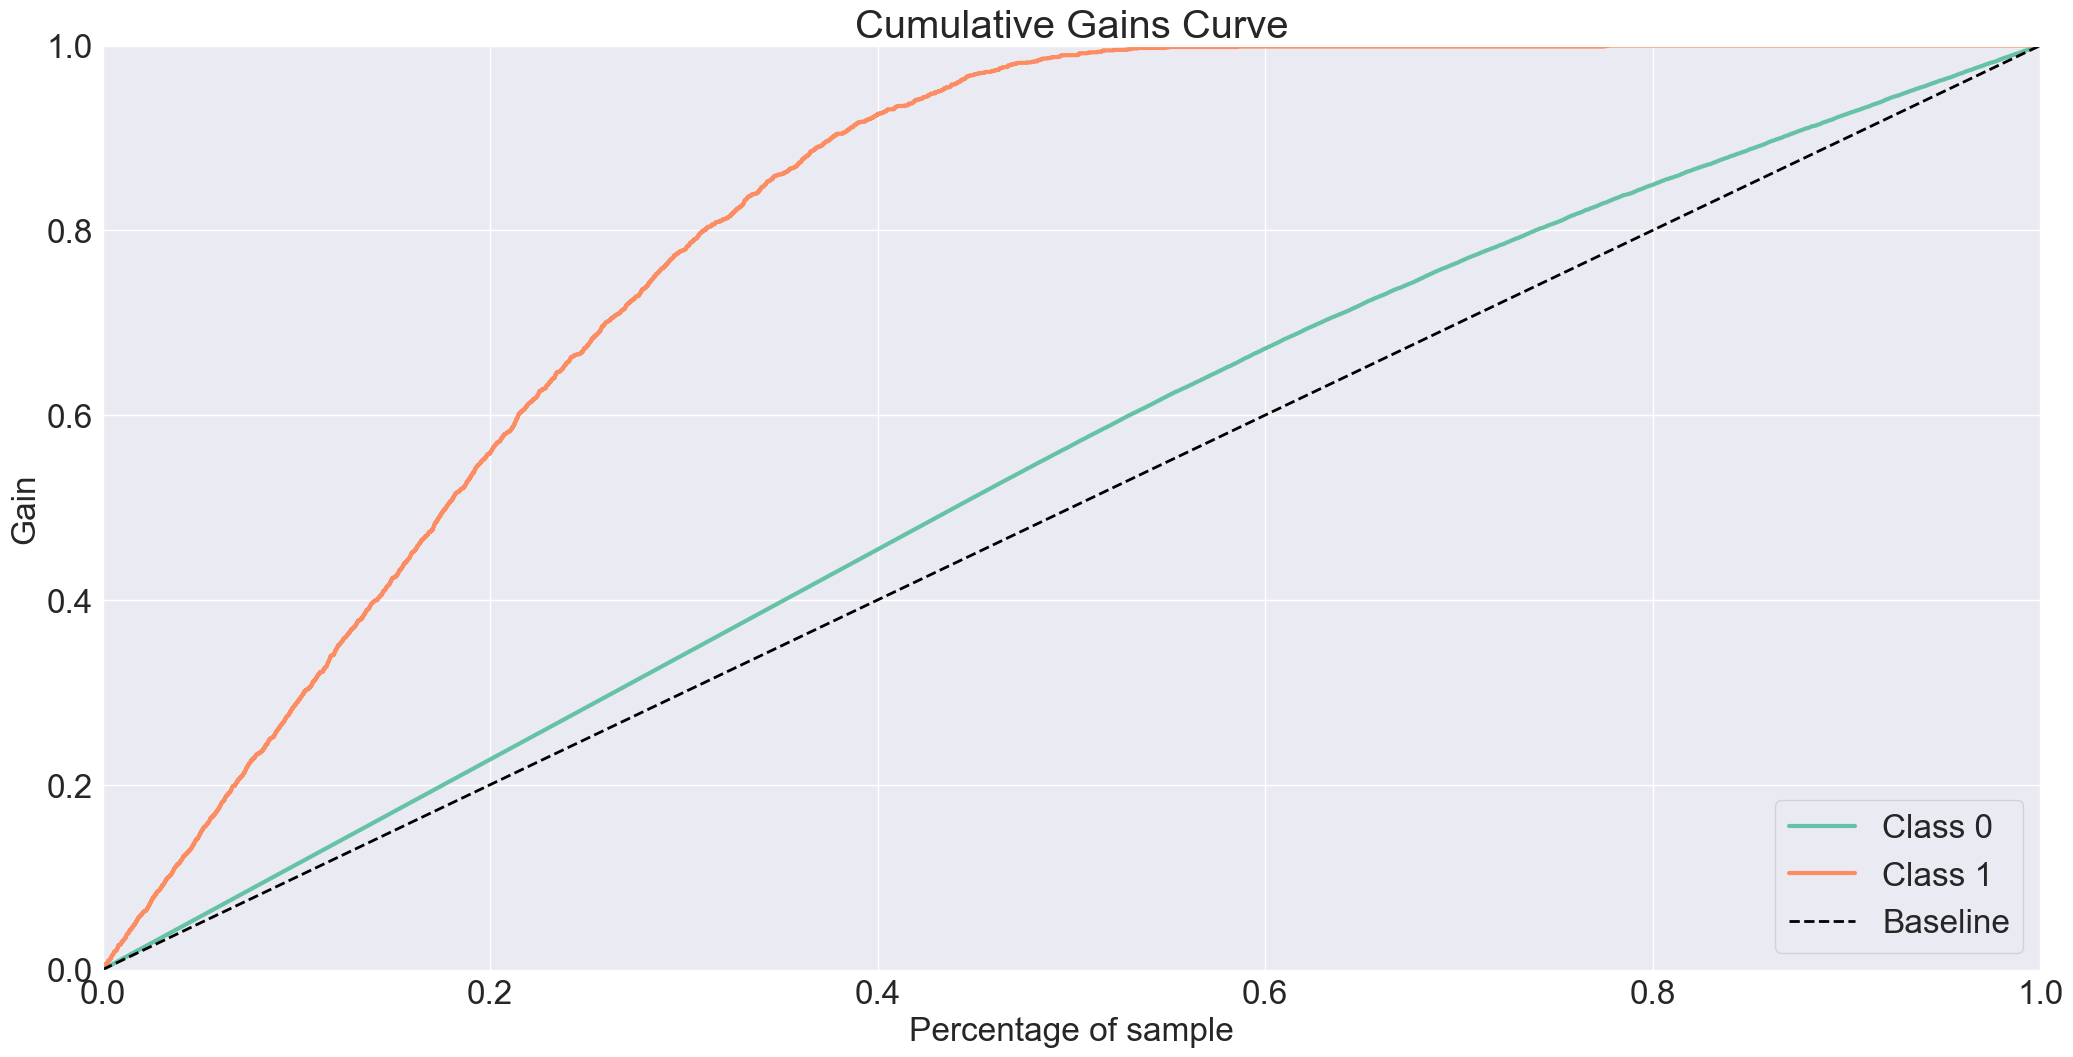

In [568]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_cat)

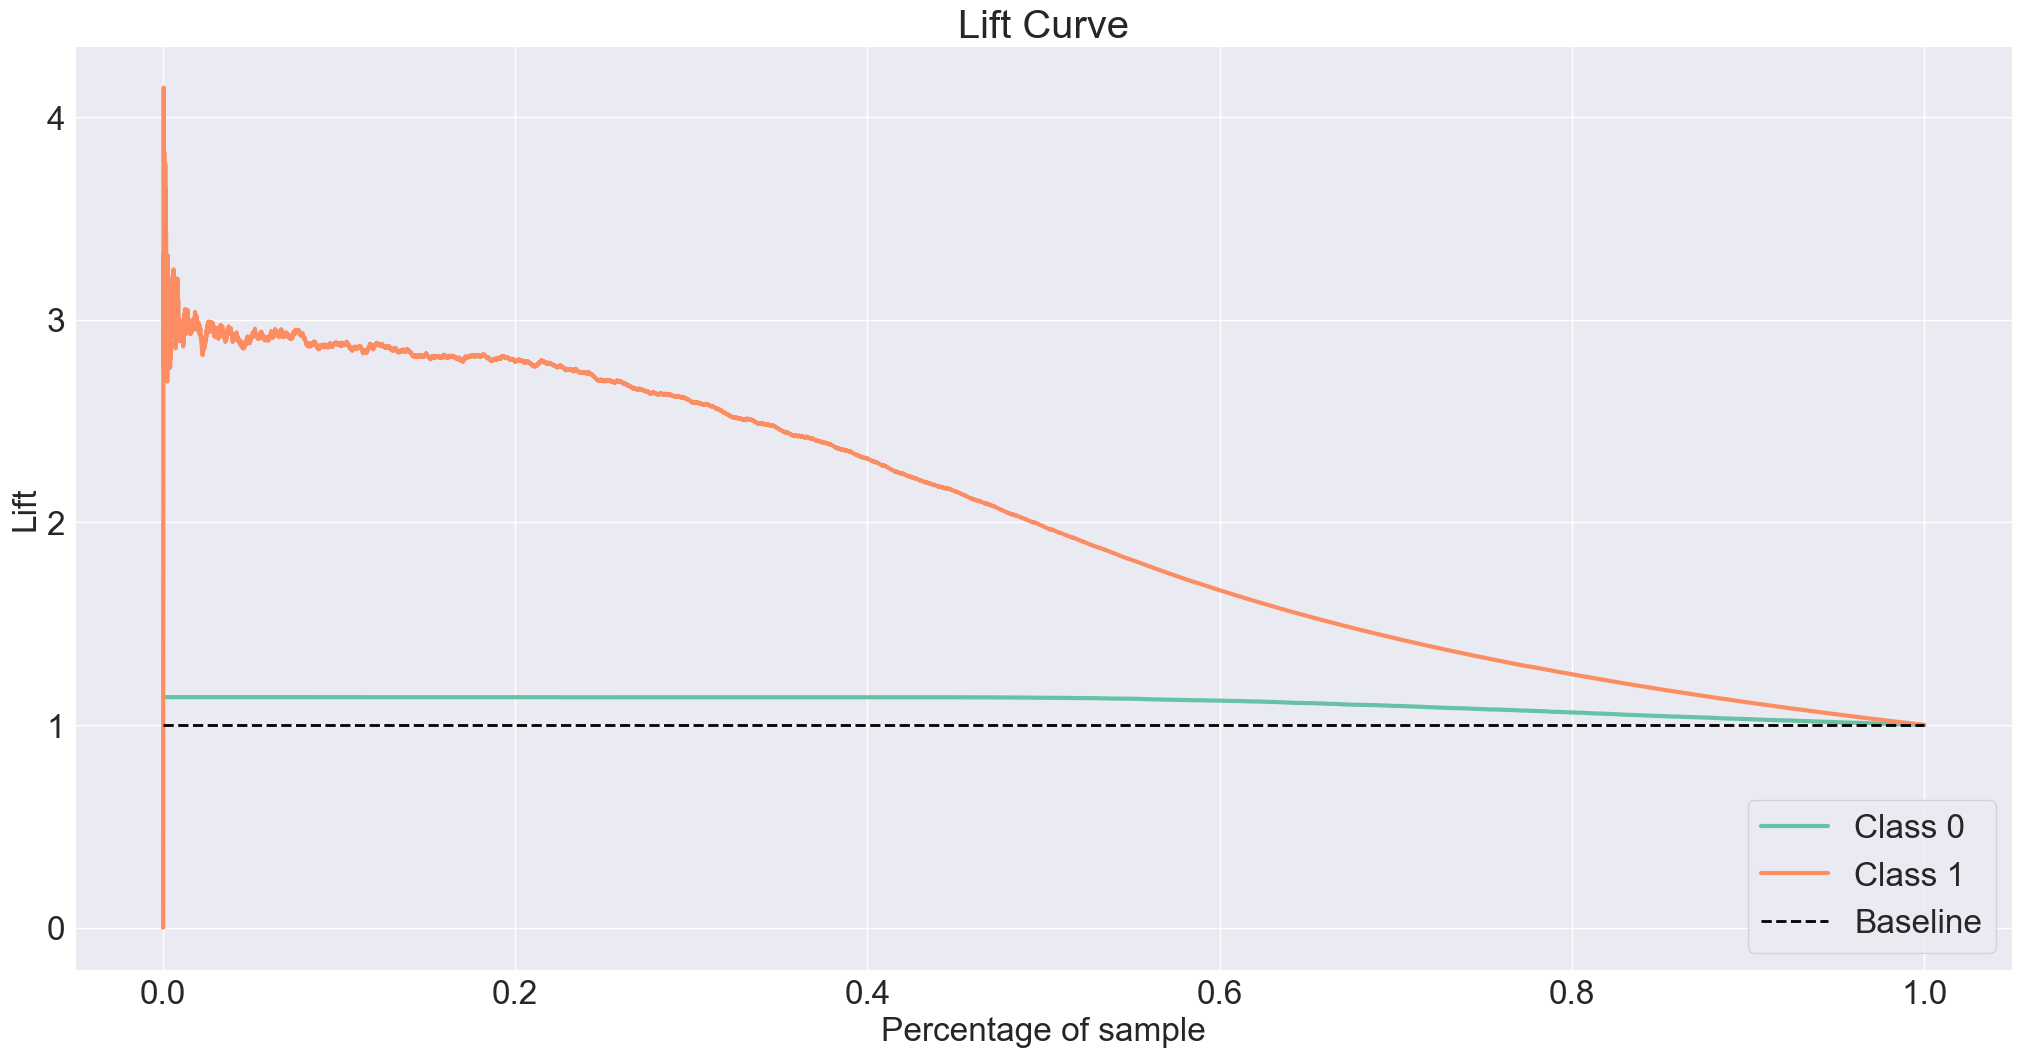

In [569]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_cat);

## 7.8. Compare Model's Performance

### 7.8.1. Single Perfomance

In [791]:
models = [knn_model, lr_model, et_model, rf_model, xgb_model, lgbm_model, cat_model]

In [792]:
# Calcula as métricas de desempenho para cada modelo
metrics_results = calculate_metrics(models, x_train, y_train, x_val, y_val)

# Cria um DataFrame com os resultados das métricas
df_metrics_results = pd.DataFrame(metrics_results)

df_metrics_results

c:\Users\raquel\anaconda3\envs\insurance_data_science\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Learning rate set to 0.060813
0:	learn: 0.5873694	total: 218ms	remaining: 3m 37s
1:	learn: 0.5110809	total: 340ms	remaining: 2m 49s
2:	learn: 0.4665483	total: 477ms	remaining: 2m 38s
3:	learn: 0.4249125	total: 548ms	remaining: 2m 16s
4:	learn: 0.3933467	total: 602ms	remaining: 1m 59s
5:	learn: 0.3684980	total: 665ms	remaining: 1m 50s
6:	learn: 0.3495859	total: 728ms	remaining: 1m 43s
7:	learn: 0.3350759	total: 802ms	remaining: 1m 39s
8:	learn: 0.3238362	total: 869ms	remaining: 1m 35s
9:	learn: 0.3149088	total: 930ms	remaining: 1m 32s
10:	learn: 0.3080194	total: 1.01s	remaining: 1m 31s
11:	learn: 0.3031639	total: 1.08s	remaining: 1m 29s
12:	learn: 0.2989765	total: 1.15s	remaining: 1m 26s
13:	learn: 0.2948916	total: 1.2s	remaining: 1m 24s
14:	learn: 0.2916171	total: 1.27s	remaining: 1m 23s
15:	learn: 0.2891973	total: 1.34s	remaining: 1m 22s
16:	learn: 0.2872662	total: 1.4s	remaining: 1m 20s
17:	learn: 0.2857116	total: 1.45s	remaining: 1m 19s
18:	learn: 0.2842727	total: 1.51s	remaining: 1

Model  Precision    Recall  F1-Score
0    KNeighborsClassifier   0.292047  0.116183  0.166234
1      LogisticRegression   0.000000  0.000000  0.000000
2    ExtraTreesClassifier   0.331956  0.125000  0.181613
3  RandomForestClassifier   0.331633  0.101141  0.155008
4           XGBClassifier   0.307281  0.148859  0.200559
5          LGBMClassifier   0.313501  0.071058  0.115856
6      CatBoostClassifier   0.347458  0.021266  0.040078

### 7.8.2. Cross Validation

In [748]:
models = [knn_model, lr_model, et_model, rf_model, xgb_model, lgbm_model, cat_model]

In [749]:
# Realiza a validação cruzada para os modelos e armazena os resultados
cv_results = perform_cross_validation(models, x_train, y_train)

# Cria um DataFrame com os resultados da validação cruzada
df_cv_results = pd.DataFrame(cv_results)

# Exibe o DataFrame com os resultados
df_cv_results

c:\Users\raquel\anaconda3\envs\insurance_data_science\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\raquel\anaconda3\envs\insurance_data_science\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\raquel\anaconda3\envs\insurance_data_science\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\raquel\anaconda3\envs\

Learning rate set to 0.055285
0:	learn: 0.5935711	total: 117ms	remaining: 1m 57s
1:	learn: 0.5202198	total: 222ms	remaining: 1m 50s
2:	learn: 0.4769521	total: 310ms	remaining: 1m 42s
3:	learn: 0.4362636	total: 371ms	remaining: 1m 32s
4:	learn: 0.4045492	total: 405ms	remaining: 1m 20s
5:	learn: 0.3783079	total: 431ms	remaining: 1m 11s
6:	learn: 0.3584243	total: 457ms	remaining: 1m 4s
7:	learn: 0.3430633	total: 483ms	remaining: 59.9s
8:	learn: 0.3310055	total: 508ms	remaining: 56s
9:	learn: 0.3216563	total: 535ms	remaining: 52.9s
10:	learn: 0.3140553	total: 560ms	remaining: 50.4s
11:	learn: 0.3087744	total: 585ms	remaining: 48.2s
12:	learn: 0.3041678	total: 611ms	remaining: 46.4s
13:	learn: 0.2996195	total: 637ms	remaining: 44.9s
14:	learn: 0.2961169	total: 663ms	remaining: 43.6s
15:	learn: 0.2930246	total: 689ms	remaining: 42.4s
16:	learn: 0.2908365	total: 716ms	remaining: 41.4s
17:	learn: 0.2890237	total: 736ms	remaining: 40.2s
18:	learn: 0.2872567	total: 762ms	remaining: 39.4s
19:	lea

Model  Precision Mean  Precision Std  Recall Mean  Recall Std  F1-Score Mean  F1-Score Std
0    KNeighborsClassifier        0.328252       0.013204     0.131165    0.006559       0.187422      0.008753
1      LogisticRegression        0.000000       0.000000     0.000000    0.000000       0.000000      0.000000
2    ExtraTreesClassifier        0.337198       0.013711     0.123538    0.002814       0.180807      0.004815
3  RandomForestClassifier        0.361189       0.027991     0.100278    0.006622       0.156952      0.010602
4           XGBClassifier        0.327183       0.019899     0.161412    0.006562       0.216134      0.009963
5          LGBMClassifier        0.361325       0.015689     0.088840    0.004719       0.142583      0.006972
6      CatBoostClassifier        0.399239       0.029074     0.025547    0.002854       0.047996      0.005158

### 7.8.3. Accumulative Gain

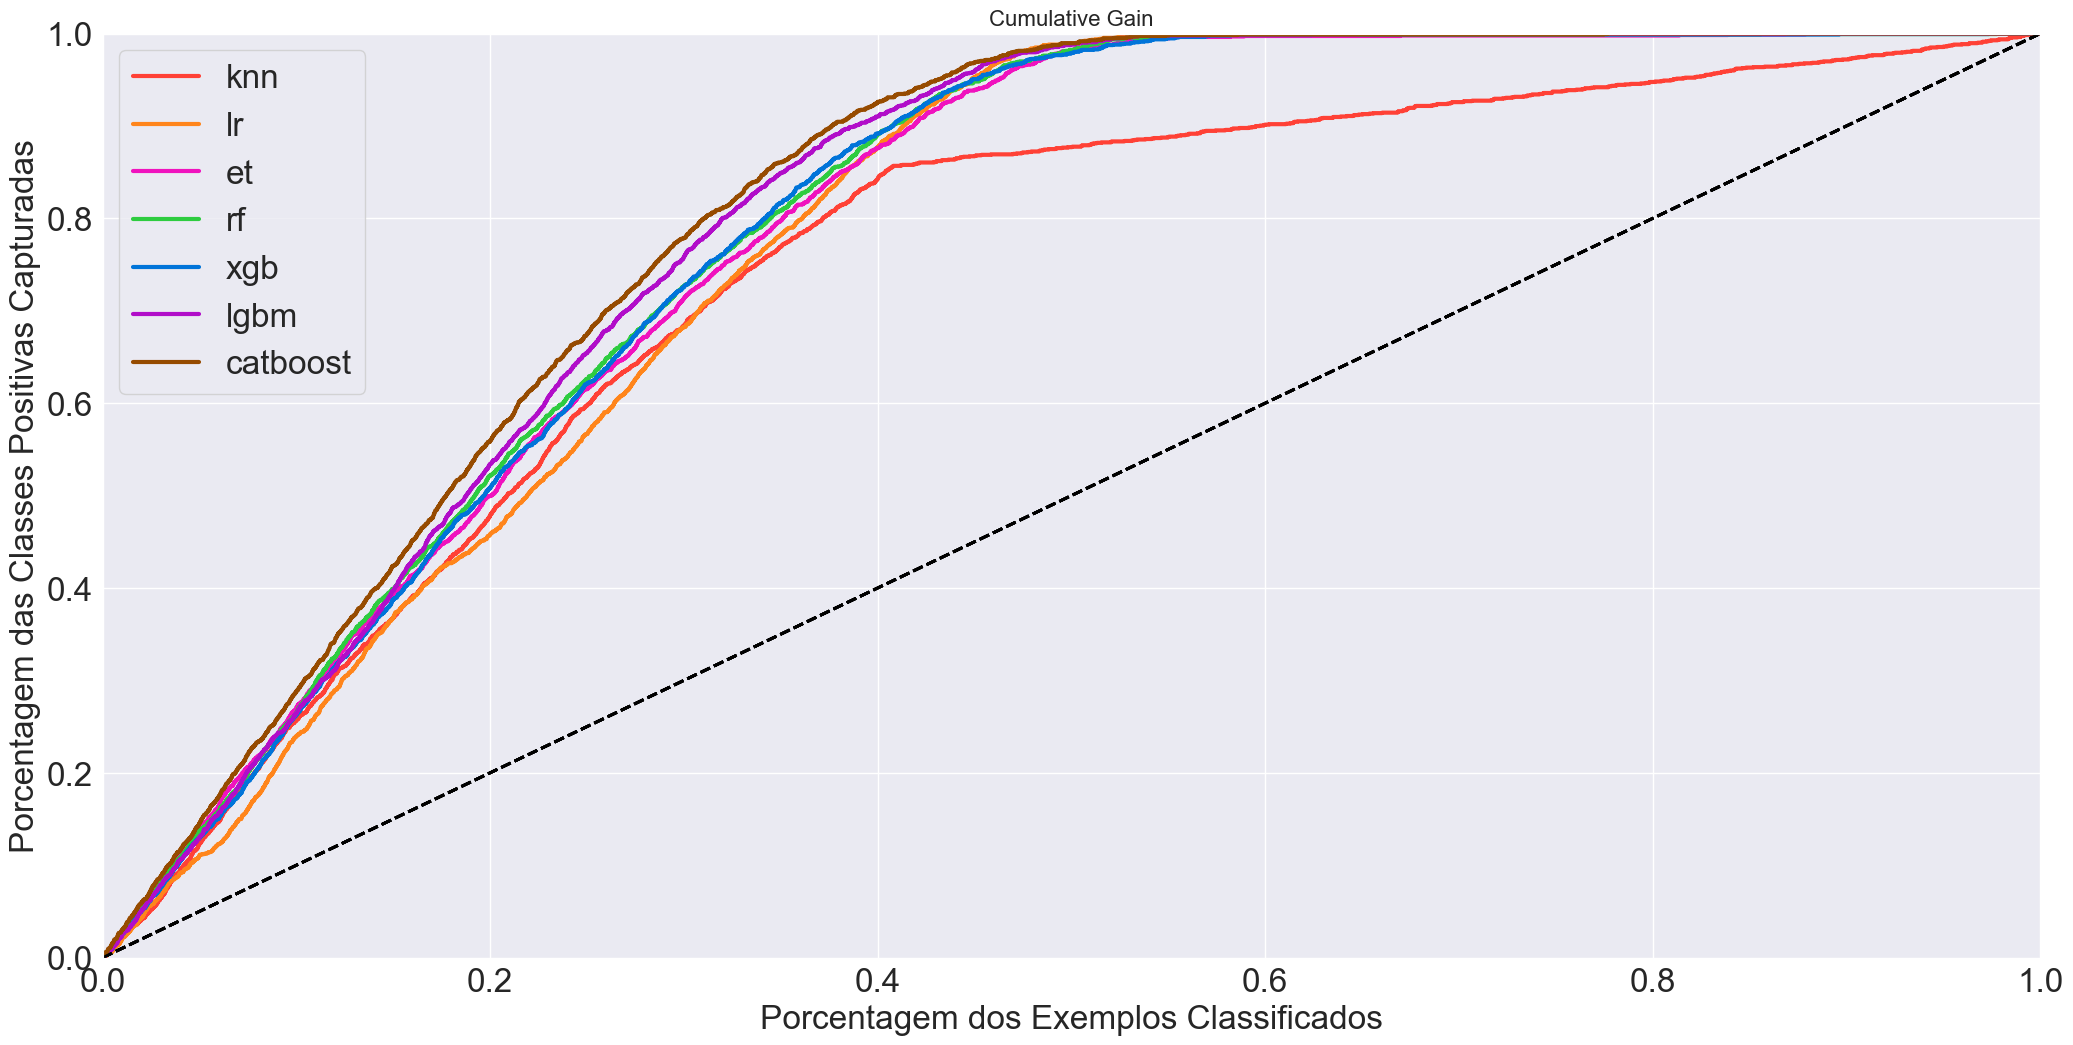

In [786]:
# Define uma paleta de cores personalizada para os gráficos
colors = ['#FF4136', '#FF4136', '#FF851B', '#FF851B', '#F012BE', '#F012BE', '#2ECC40', '#2ECC40', '#0074D9',
          '#0074D9', '#B10DC9', '#B10DC9', '#964B00', '#964B00', '#FFDC00', '#FFDC00', '#AAAAAA', '#AAAAAA']
sns.set_palette(palette=colors)

# Lista de modelos e rótulos correspondentes
models = [yhat_knn, yhat_lr, yhat_et, yhat_rf, yhat_xgb, yhat_lgbm, yhat_cat]
model_labels = ['knn', 'lr', 'et', 'rf', 'xgb', 'lgbm', 'catboost']

# Cria uma figura e eixos
fig, ax = plt.subplots()

# Plota as curvas de ganho cumulativo para cada modelo
for i in range(len(models)):
    ax = skplt.metrics.plot_cumulative_gain(y_val, models[i], ax=ax)
    art.remove(ax.lines[i*2])  # Remove as linhas duplicadas do gráfico

# Adiciona a legenda ao gráfico
ax.legend([ax.lines[i*2] for i in range(len(models))], model_labels)

# Configurações adicionais do gráfico
plt.title('Cumulative Gain')
plt.xlabel('Porcentagem dos Exemplos Classificados')
plt.ylabel('Porcentagem das Classes Positivas Capturadas')
plt.grid(True)


plt.show()


### 7.8.4. Lift Curve

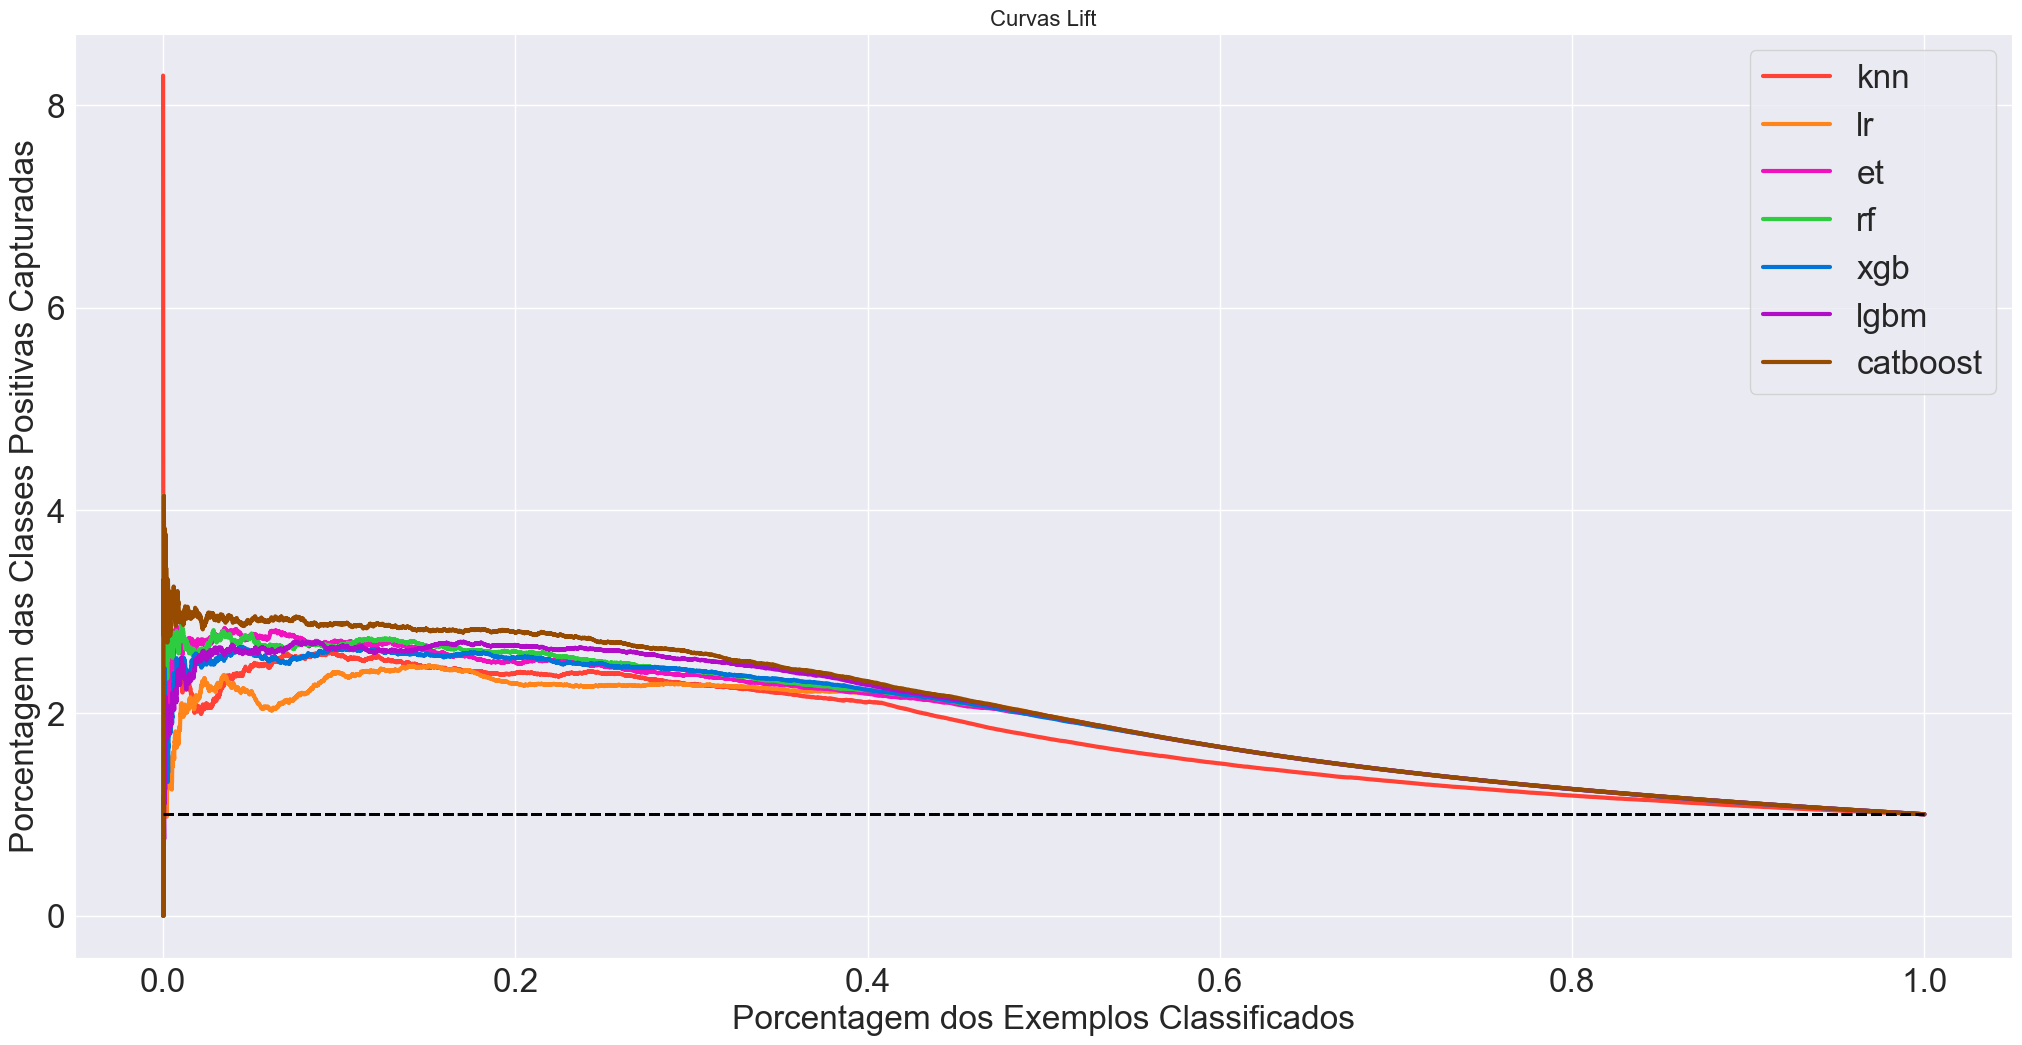

In [573]:
# Define uma paleta de cores personalizada para os gráficos
colors = ['#FF4136', '#FF4136', '#FF851B', '#FF851B', '#F012BE', '#F012BE', '#2ECC40', '#2ECC40', '#0074D9',
          '#0074D9', '#B10DC9', '#B10DC9', '#964B00', '#964B00', '#FFDC00', '#FFDC00', '#AAAAAA', '#AAAAAA']
sns.set_palette(palette=colors)

# Lista de modelos e rótulos correspondentes
models = [yhat_knn, yhat_lr, yhat_et, yhat_rf, yhat_xgb, yhat_lgbm, yhat_cat]
model_labels = ['knn', 'lr', 'et', 'rf', 'xgb', 'lgbm', 'catboost']

# Cria uma figura e eixos
fig, ax = plt.subplots()

# Plota as curvas de lift para cada modelo
for i in range(len(models)):
    ax = skplt.metrics.plot_lift_curve(y_val, models[i], ax=ax)
    art.remove(ax.lines[i*2])  # Remove as linhas duplicadas do gráfico

# Adiciona a legenda ao gráfico
ax.legend([ax.lines[i*2] for i in range(len(models))], model_labels)

# Configurações adicionais do gráfico
plt.title('Curvas Lift')
plt.xlabel('Porcentagem dos Exemplos Classificados')
plt.ylabel('Porcentagem das Classes Positivas Capturadas')
plt.grid(True)

plt.show()


# 8.0. Hyperparameter Finetuning

## 8.1. Bayesian Search CV

In [622]:
# Definir os parâmetros a serem pesquisados
param_space = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],  # Número de árvores na floresta
     'eta': [0.01, 0.03],  # Taxa de aprendizado
     'max_depth': [3, 5, 9],  # Profundidade máxima de cada árvore
     'subsample': [0.1, 0.5, 0.7],  # Fração de observações a serem usadas para cada árvore
     'colsample_bytree': [0.3, 0.7, 0.9],  # Fração de recursos a serem usados para cada árvore
     'min_child_weight': [3, 8, 15]  # Peso mínimo de instância necessário em um nó filho
}

# Criar o modelo XGBoost
xgb_model_bs = XGBClassifier()

# Realizar a busca bayesiana
bayes_search = BayesSearchCV(
    xgb_model_bs, param_space, n_iter=50, scoring='f1_macro', cv=5, random_state=42, n_jobs=1
)

# Treinar o modelo com a busca bayesiana
bayes_search.fit(x_train, y_train)

# Melhores hiperparâmetros encontrados
print("Melhores Hiperparâmetros:")
print(bayes_search.best_params_)

# Melhor pontuação obtida
print("Melhor Pontuação:")
print(bayes_search.best_score_)


c:\Users\raquel\anaconda3\envs\insurance_data_science\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\raquel\anaconda3\envs\insurance_data_science\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\raquel\anaconda3\envs\insurance_data_science\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\raquel\anaconda3\envs\insurance_data_science\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\raquel\anaconda3\envs\insurance_data_science\Lib\site-packages\skopt\optimizer\optimize

Melhores Hiperparâmetros:
OrderedDict([('colsample_bytree', 0.9), ('eta', 0.03), ('max_depth', 9), ('min_child_weight', 3), ('n_estimators', 3500), ('subsample', 0.5)])
Melhor Pontuação:
0.5719228126212943


## 8.2. Random Search

In [623]:
# Definir os parâmetros a serem pesquisados
param_grid = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],  # Número de árvores na floresta
     'eta': [0.01, 0.03],  # Taxa de aprendizado
     'max_depth': [3, 5, 9],  # Profundidade máxima de cada árvore
     'subsample': [0.1, 0.5, 0.7],  # Fração de observações a serem usadas para cada árvore
     'colsample_bytree': [0.3, 0.7, 0.9],  # Fração de recursos a serem usados para cada árvore
     'min_child_weight': [3, 8, 15]  # Peso mínimo de instância necessário em um nó filho
}

# Criar o modelo XgbBoostClassifier
xgb_model_rs = XGBClassifier()

# Realizar a Random Search
random_search = ms.RandomizedSearchCV(
    xgb_model_rs, param_distributions=param_grid, n_iter=10, scoring='f1_macro', cv=5, random_state=42
)

# Treinar o modelo com a Random Search
random_search.fit(x_train, y_train)

# Melhores hiperparâmetros encontrados
print("Melhores Hiperparâmetros:")
print(random_search.best_params_)

# Melhor pontuação obtida
print("Melhor Pontuação:")
print(random_search.best_score_)

Melhores Hiperparâmetros:
{'subsample': 0.5, 'n_estimators': 3500, 'min_child_weight': 15, 'max_depth': 9, 'eta': 0.03, 'colsample_bytree': 0.7}
Melhor Pontuação:
0.5599598373462294


## 8.3. Final Model

### 8.3.1 Bayseian Search

In [624]:
# Definição dos melhores hiperparâmetros encontrados
best_params_bs = {
    'n_estimators': 3500,
    'eta': 0.03,
    'max_depth': 9,
    'subsample': 0.5,
    'colsample_bytree': 0.9,
    'min_child_weight': 3
}


In [625]:
# Criação do modelo XGB com os melhores hiperparâmetros
xgb_model_tuned_bs = XGBClassifier(
    n_estimators=best_params_bs['n_estimators'],
    eta=best_params_bs['eta'],
    max_depth=best_params_bs['max_depth'],
    subsample=best_params_bs['subsample'],
    colsample_bytree=best_params_bs['colsample_bytree'],
    min_child_weight=best_params_bs['min_child_weight']
)

# Treinamento do modelo com os dados de treinamento completos
xgb_model_tuned_bs.fit(x_train, y_train)

# Previsão do modelo no conjunto de validação
yhat_xgb_tuned_bs = xgb_model_tuned_bs.predict_proba(x_val)

### 8.3.2. Random Search

In [628]:
# Definição dos melhores hiperparâmetros encontrados
best_params_rs = {
    'n_estimators': 3500,
    'eta': 0.03,
    'max_depth': 9,
    'subsample': 0.5,
    'colsample_bytree': 0.7,
    'min_child_weight': 15
}




In [630]:
# Criação do modelo XGB com os melhores hiperparâmetros
xgb_model_tuned_rs = XGBClassifier(
    n_estimators=best_params_rs['n_estimators'],
    eta=best_params_rs['eta'],
    max_depth=best_params_rs['max_depth'],
    subsample=best_params_rs['subsample'],
    colsample_bytree=best_params_rs['colsample_bytree'],
    min_child_weight=best_params_rs['min_child_weight']
)

# Treinamento do modelo com os dados de treinamento completos
xgb_model_tuned_rs.fit(x_train, y_train)

# Previsão do modelo no conjunto de validação
yhat_xgb_tuned_rs = xgb_model_tuned_rs.predict_proba(x_val)

### 8.3.3. Best Model 

In [631]:
models = [xgb_model, xgb_model_tuned_bs, xgb_model_tuned_rs]

In [632]:
# Calcula as métricas de desempenho para cada modelo após o finetuning
metrics_results_tuned = calculate_metrics(models, x_train, y_train, x_val, y_val)

metrics_results_tuned[1]['Model'] = 'XGB Bayseian Search'
metrics_results_tuned[2]['Model'] = 'XBG Random Search'

df_metrics_results_tuned = pd.DataFrame(metrics_results_tuned)
df_metrics_results_tuned

Model  Precision    Recall  F1-Score
0        XGBClassifier   0.307281  0.148859  0.200559
1  XGB Bayseian Search   0.314721  0.160788  0.212839
2    XBG Random Search   0.326057  0.123963  0.179632

# 9.0. Performance Metrics

## 9.1. Model Metrics

In [633]:
# Copia o dataframe da amostra de validação
df8 = x_validation.copy()

# Cria uma nova coluna no dataframe para a variável resposta (y_validation)
df8['response'] = y_validation.copy()

# Calcula o score de propensão utilizando o modelo treinado (yhat_xgb_tuned_bs)
df8['score'] = yhat_xgb_tuned_bs[:, 1].tolist()

# Ordena os clientes pela pontuação de propensão, em ordem decrescente
df8 = df8.sort_values('score', ascending=False)

# Calcula a precisão para os 20 primeiros clientes
precision_at_20 = precision_at_20, data=precision_at_k(df8, k=20)

# Calcula o recall para os 15 primeiros clientes
recall_at_15 = recall_at_15, data=recall_at_k(df8, k=15)

# Cria um DataFrame com os valores de precision_at_20 e recall_at_15
df_metrics = pd.DataFrame({'Metric': ['precision_at_20', 'recall_at_15'],
                           'Value': [precision_at_20, recall_at_15]})

df_metrics

Metric     Value
0  precision_at_20  0.190476
1     recall_at_15  0.001556

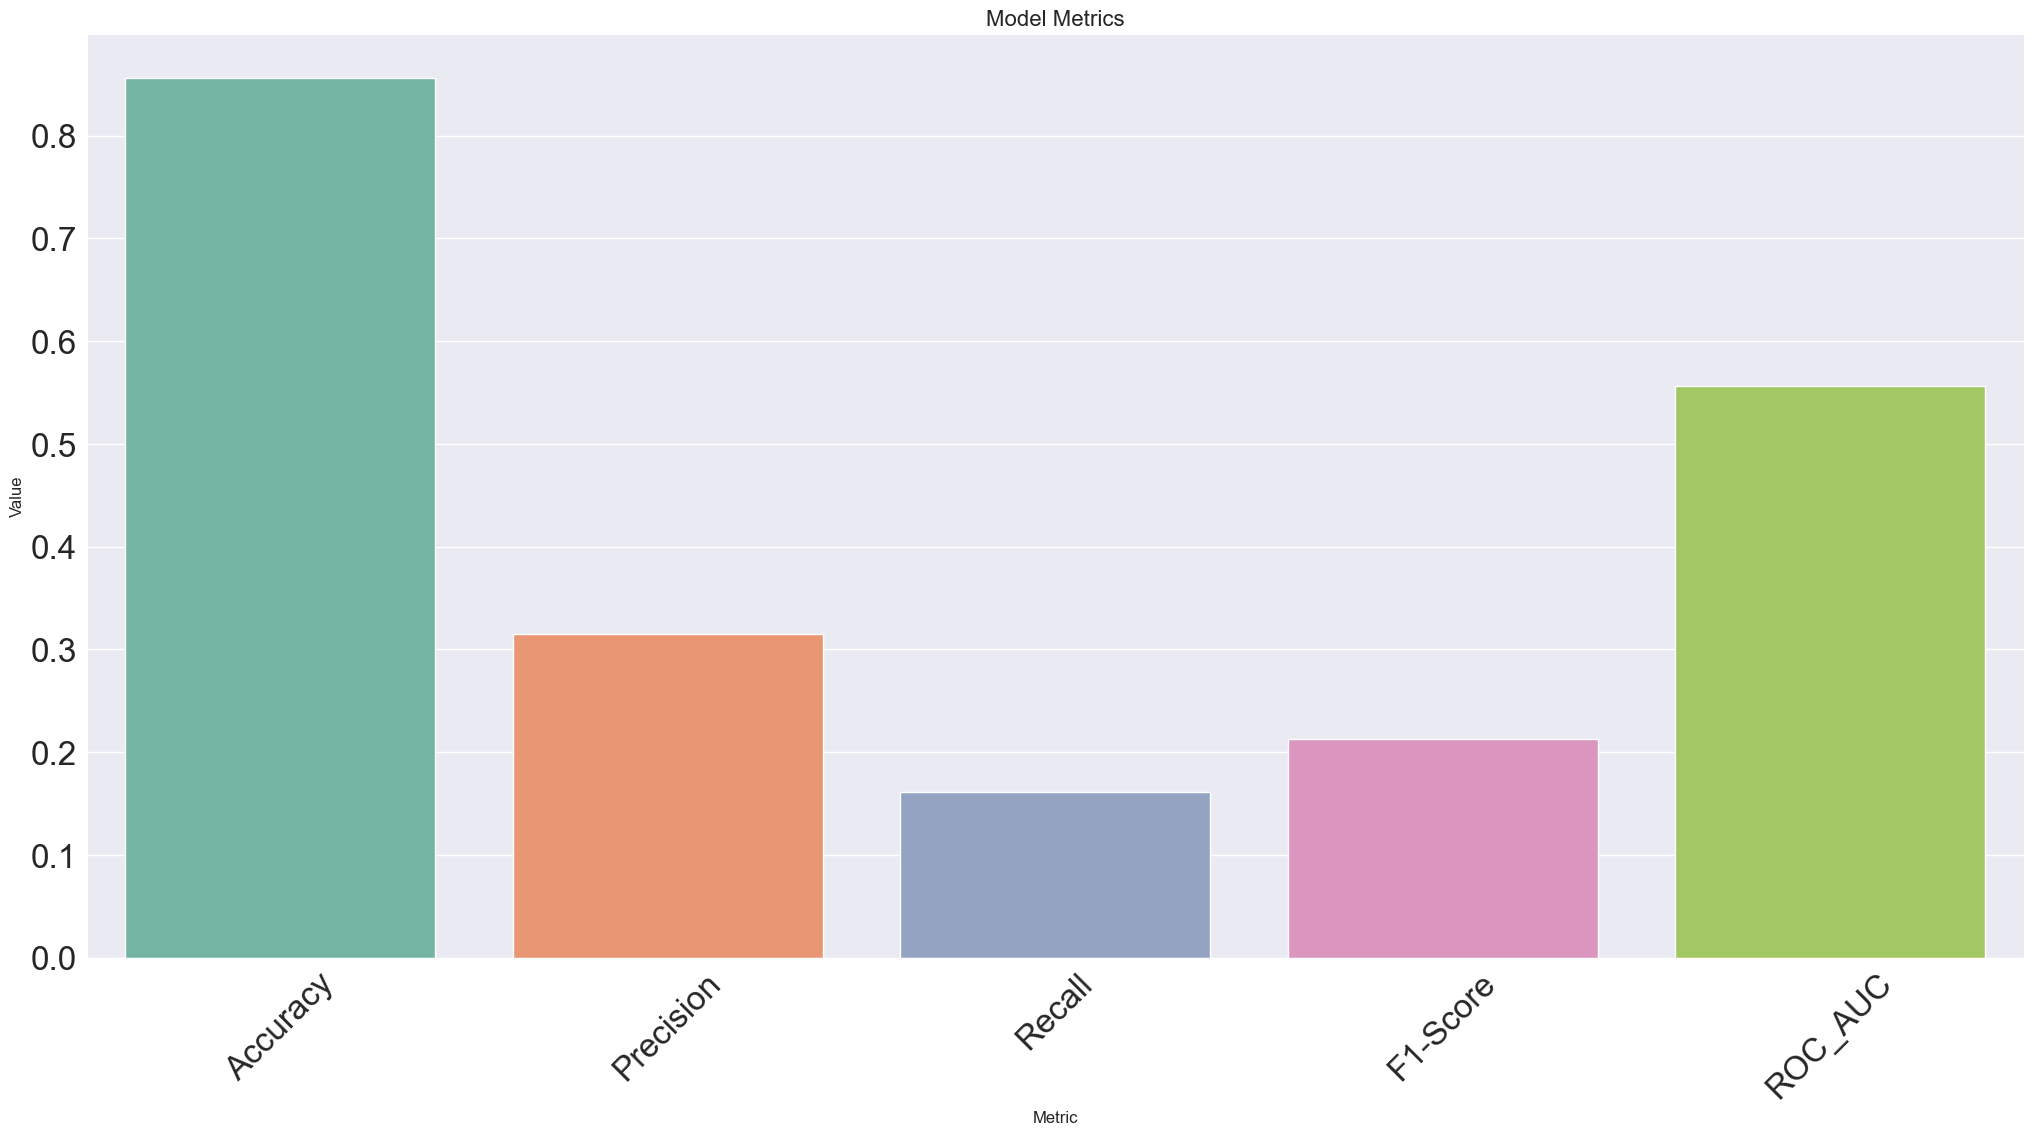

Metric     Value
0   Accuracy  0.856553
1  Precision  0.314721
2     Recall  0.160788
3   F1-Score  0.212839
4    ROC_AUC  0.556385

In [725]:
# Obtém os rótulos preditos
y_pred = xgb_model_tuned_bs.predict(x_val)

# Métricas do Modelo
accuracy = mt.accuracy_score(y_val, y_pred)
precision = mt.precision_score(y_val, y_pred)
recall = mt.recall_score(y_val, y_pred)
f1 = mt.f1_score(y_val, y_pred)
roc_auc = mt.roc_auc_score(y_val, y_pred)

# Cria um DataFrame com as métricas do Modelo
df_model_metrics = pd.DataFrame({'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC_AUC'],
                                 'Value': [accuracy, precision, recall, f1, roc_auc]})

# Métricas de Negócio
conversion_rate = y_val.mean()
gross_revenue = 40 * y_pred.sum()  # Valor fictício para a receita bruta
cost = 4 * len(y_pred)  # Valor fictício para o custo
net_revenue = gross_revenue - cost
roi = (net_revenue / cost) * 100
average_value_per_customer = net_revenue / y_pred.sum()

# Cria um DataFrame com as métricas de Negócio
df_business_metrics = pd.DataFrame({'Metric': ['Conversion Rate', 'Gross Revenue', 'Net Revenue', 'ROI',
                                                'Average Value per Customer'],
                                    'Value': [conversion_rate, gross_revenue, net_revenue, roi,
                                              average_value_per_customer]})

# Plota o gráfico das métricas do Modelo
sns.barplot(x='Metric', y='Value', data=df_model_metrics)
plt.title('Model Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.show()

df_model_metrics

## 9.2. Cummulative Curve 

- O gráfico apresenta o poder discriminativo do modelo em identificar os clientes com maior probabilidade de compra em comparação com uma classificação aleatória.

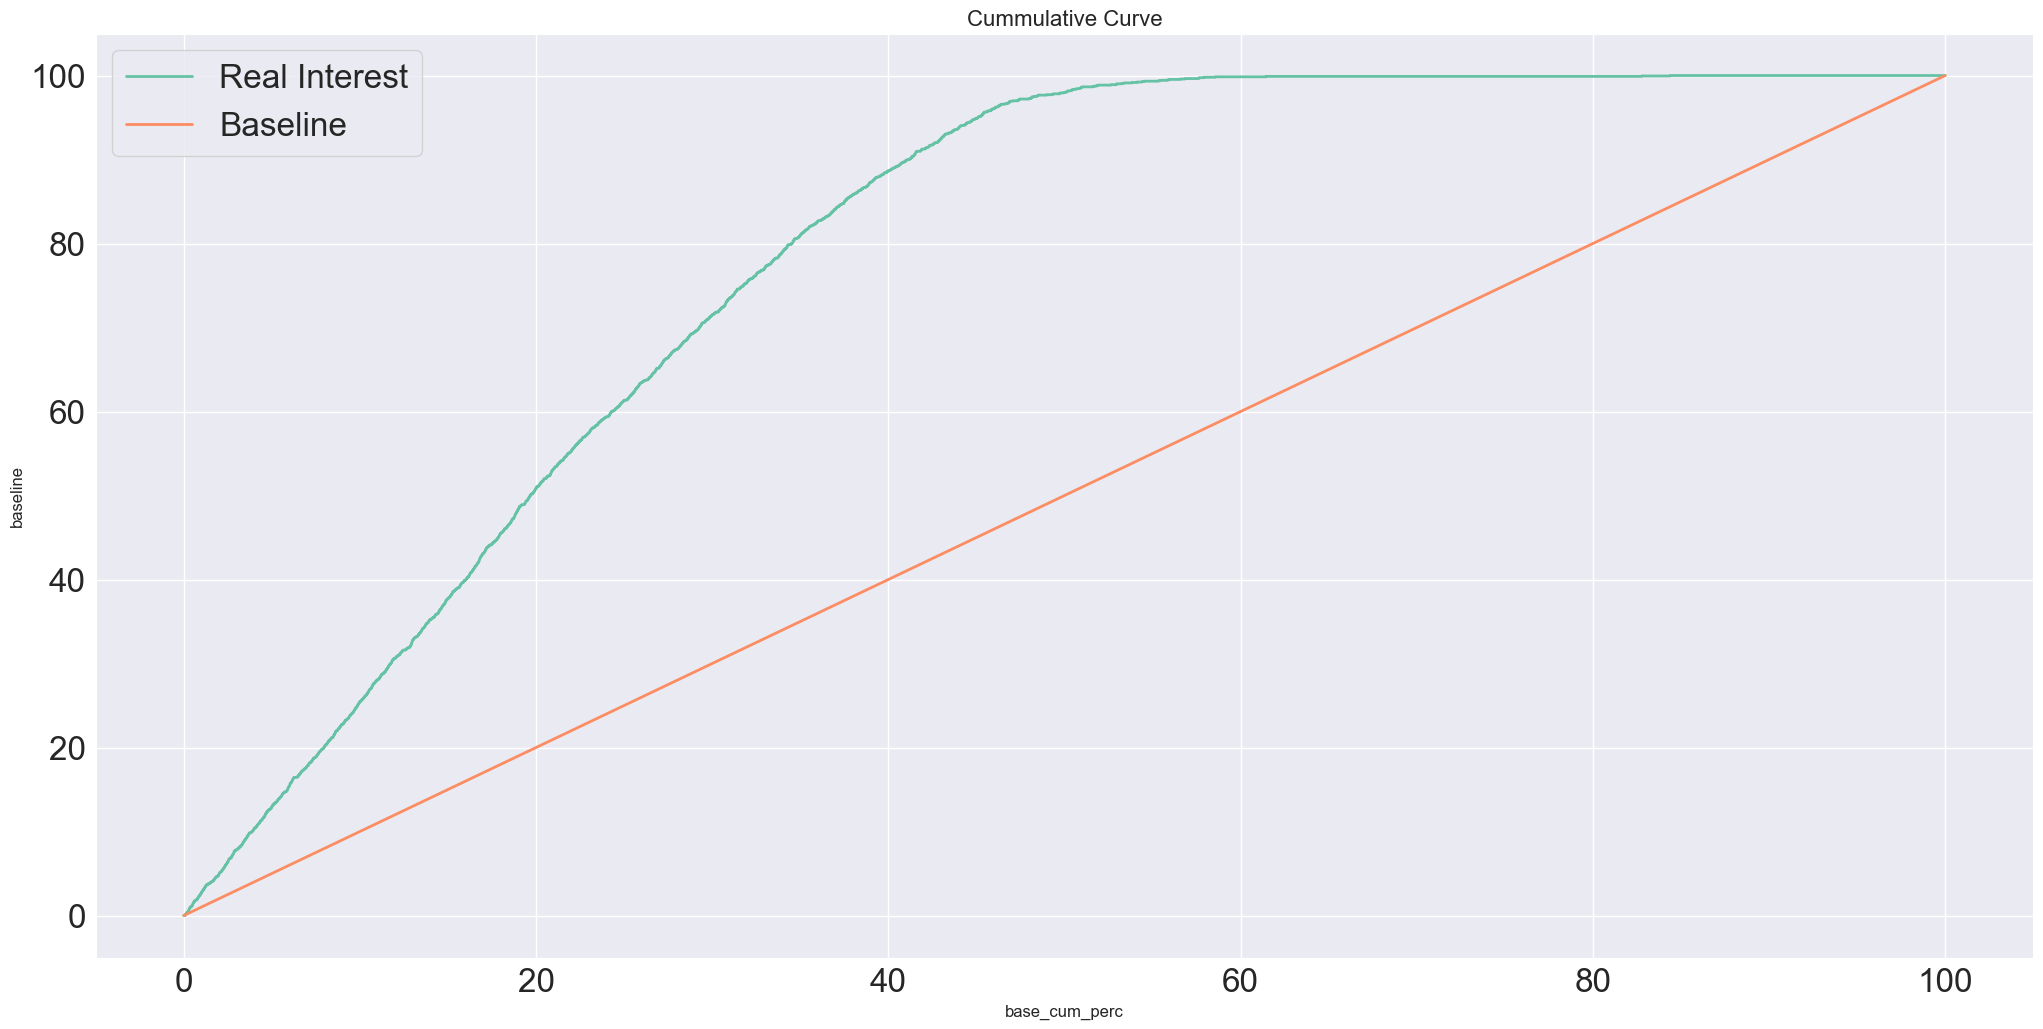

In [639]:
# Cria um dataframe com as colunas de 'predição' e 'real'
results = pd.DataFrame()
results['prediction'] = yhat_xgb_tuned_bs[:,1].tolist()
results['real'] = y_val.tolist()

# Ordena por ordem decrescente de acordo com a predição
results = results.sort_values('prediction', ascending=False)

# Calcula a porcentagem acumulada de clientes que realmente compraram (interesse - Propensity Score)
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Calcula a porcentagem acumulada de clientes (base)
results['base'] = range(1, len(results) + 1)
results['base_cum_perc'] = 100*results['base']/len(results)

# Cria uma coluna de referência (baseline)
results['baseline'] = results['base_cum_perc']

# Plota o gráfico com as linhas de porcentagem acumulada de interesse e baseline
plt.title('Cummulative Curve')

sns.lineplot(x='base_cum_perc', y='real_cum_perc', data=results, label='Real Interest')
sns.lineplot(x='base_cum_perc', y='baseline', data=results, label='Baseline')
plt.legend()




## 9.3. Lift Curve

- O gráfico permite visualizar a variação do lift ao longo da porcentagem acumulada da base. Isso pode ser útil para identificar em que parte da base o modelo está tendo um desempenho melhor ou pior em comparação com a situação de referência.

<AxesSubplot: title={'center': 'Lift Curve'}, xlabel='base_cum_perc', ylabel='lift'>

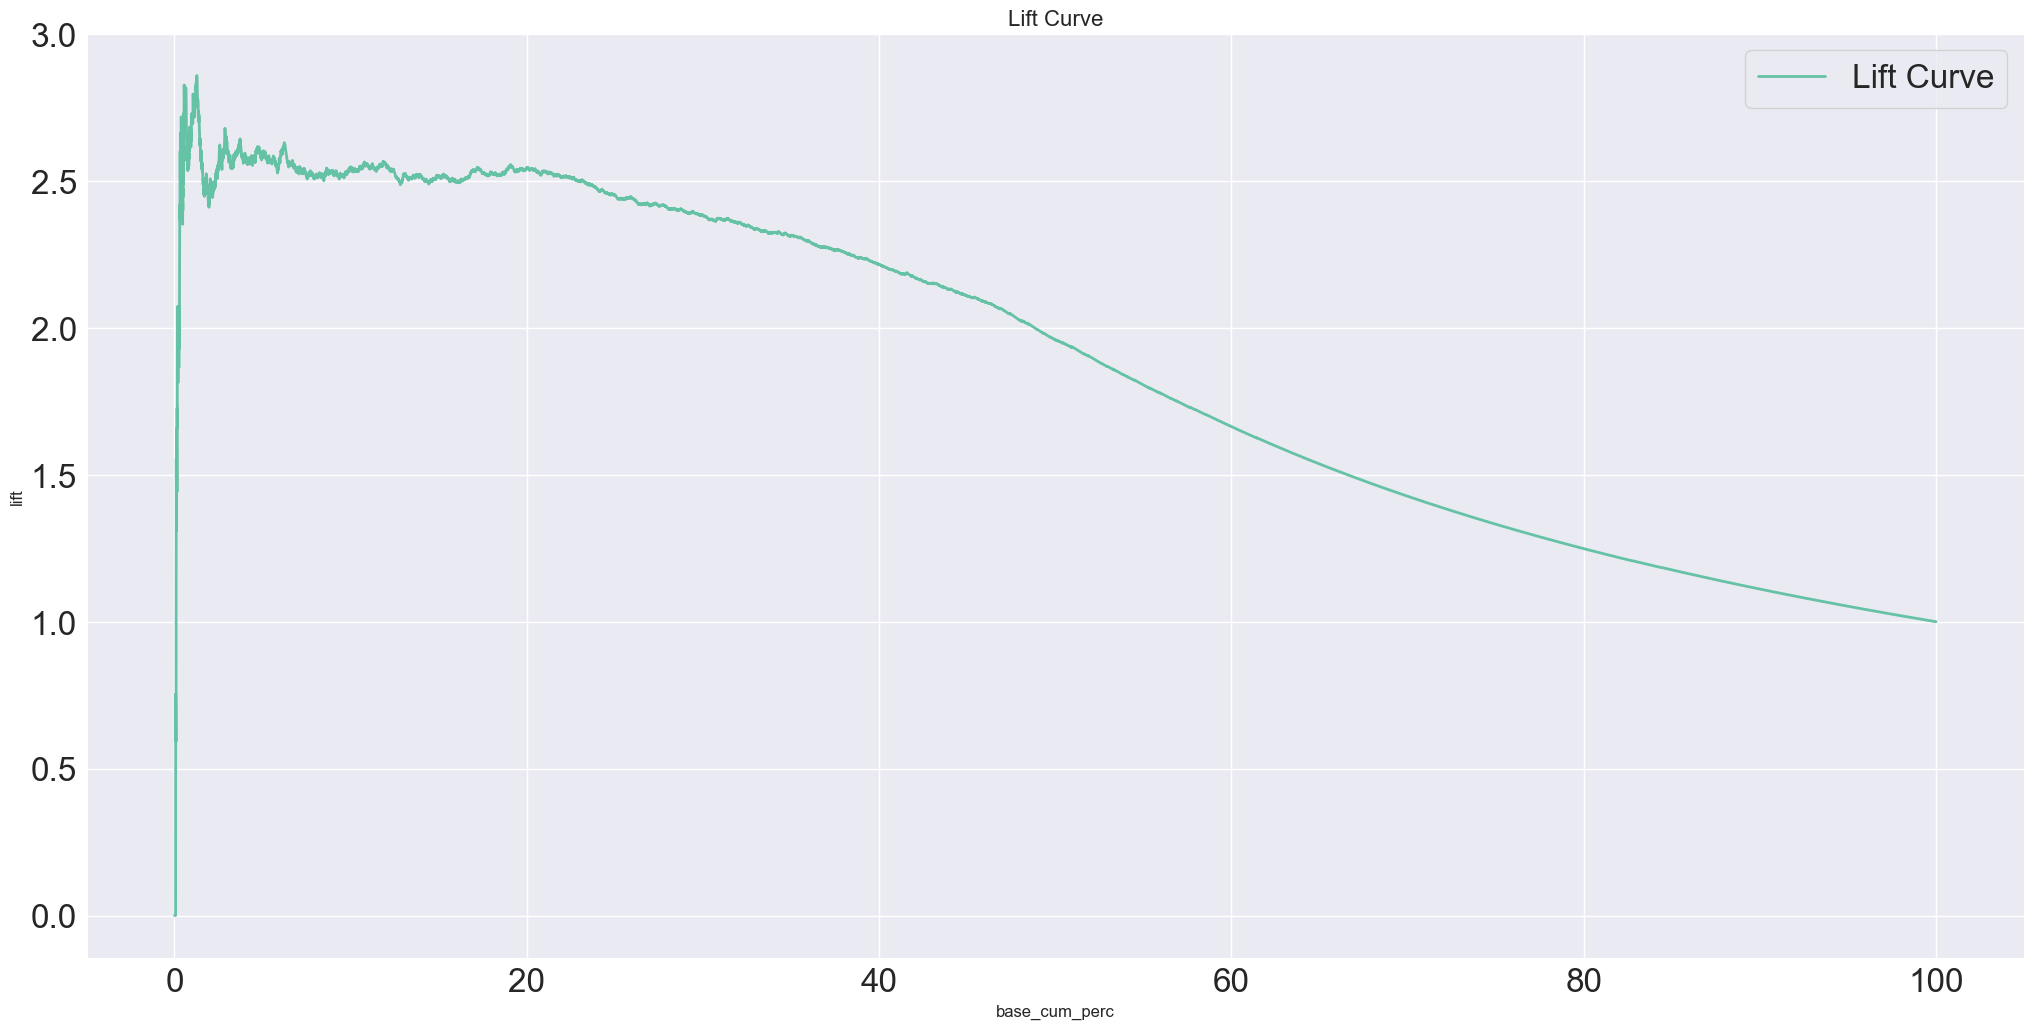

In [640]:
results = pd.DataFrame()
results['prediction'] = yhat_xgb_tuned_bs[:,1].tolist()
results['real'] = y_val.tolist()

# ordenando por previsão
results = results.sort_values('prediction', ascending=False)

# porcentagem de interesse (score de propensão)
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100 * results['real_cum'] / results['real'].sum()

# porcentagem da base (clientes)
results['base'] = range(1, len(results) + 1)
results['base_cum_perc'] = 100 * results['base'] / len(results)

# modelo baseline
results['baseline'] = results['base_cum_perc']

# cálculo do lift
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

# Adiciona a legenda
plt.title('Lift Curve')
sns.lineplot(x='base_cum_perc', y='lift', data=results, label='Lift Curve')
# sns.lineplot(x='base_cum_perc', y='baseline', data=results, label='Baseline')
# plt.legend()


## 9.4. ROI Curve

- A curva ROI permite visualizar a melhoria relativa proporcionada pelo modelo em comparação com o baseline ao longo da porcentagem acumulada da base. É útil para avaliar o desempenho do modelo em termos de retorno esperado, especialmente em cenários de classificação onde a precisão da previsão é crítica.

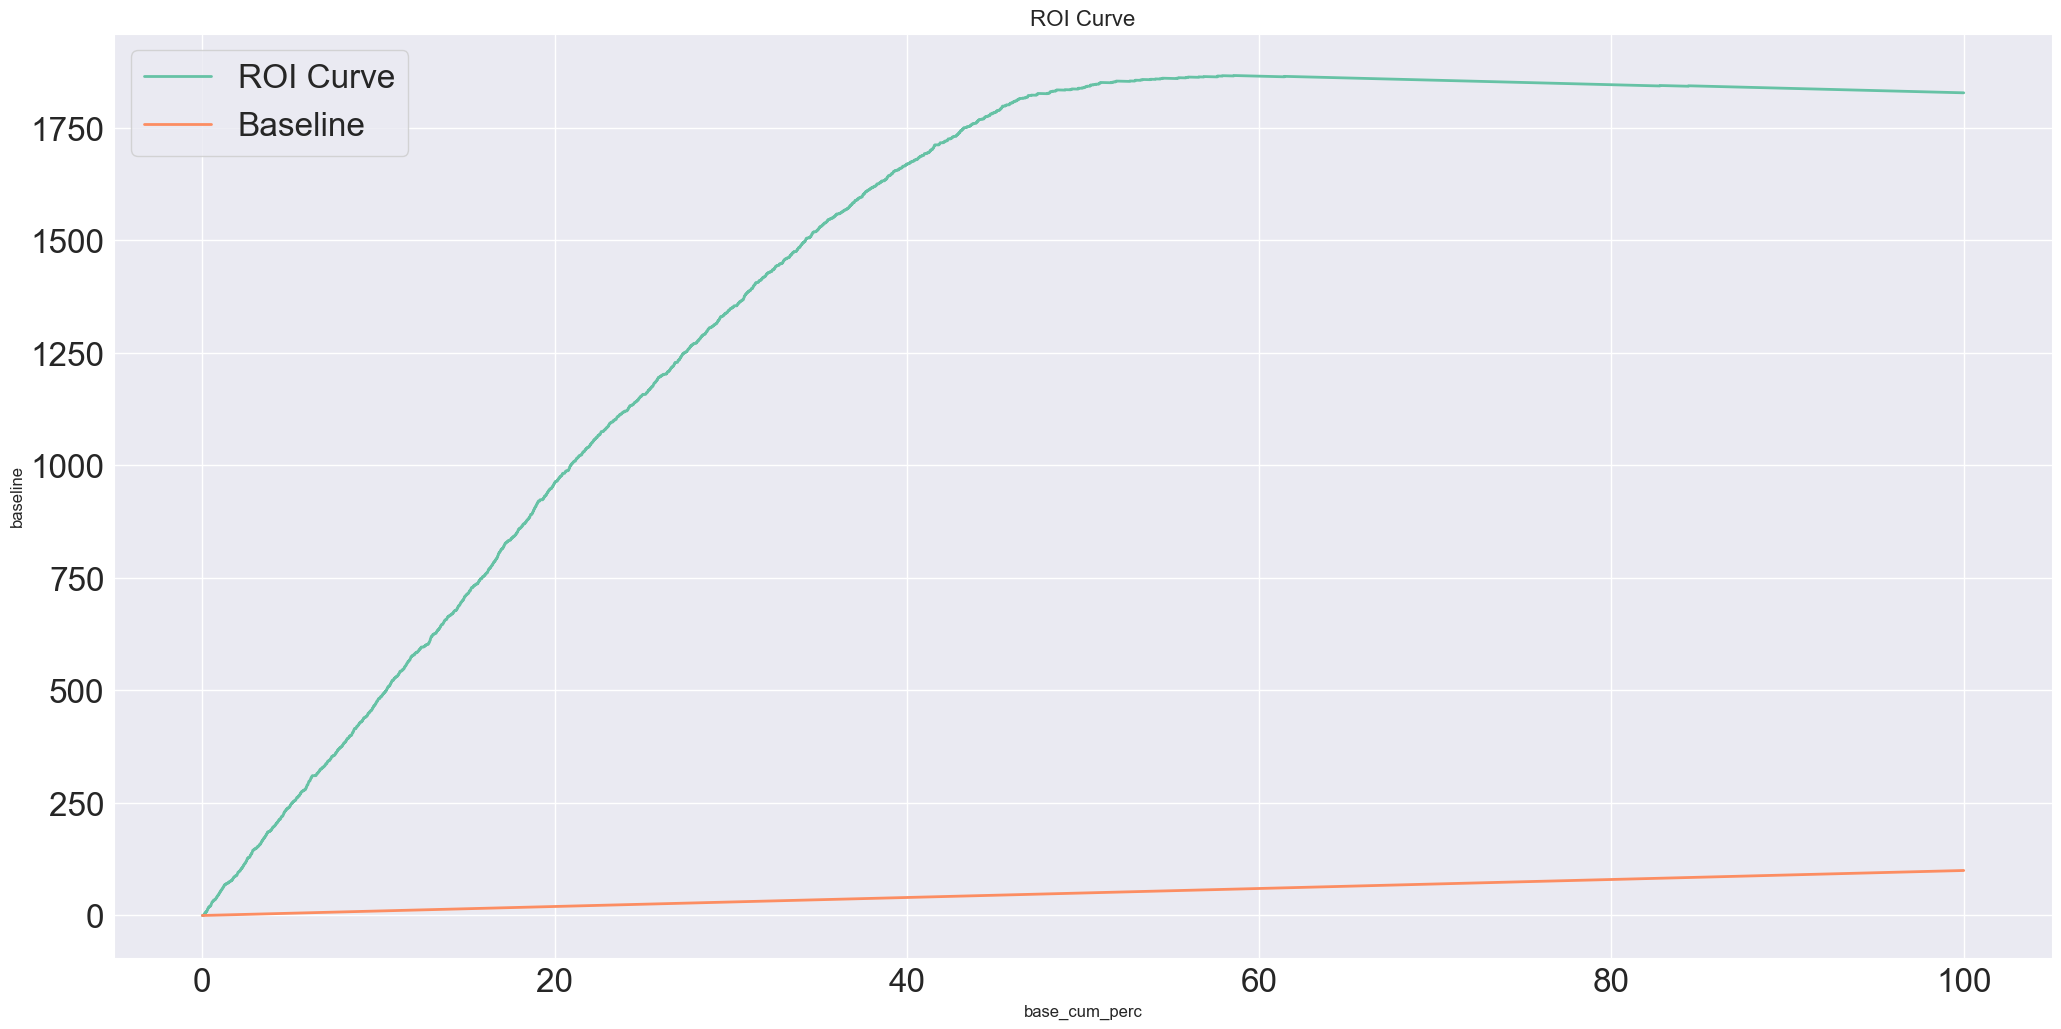

In [709]:
results = pd.DataFrame()
results['prediction'] = yhat_xgb_tuned_bs[:,1].tolist()
results['real'] = y_val.tolist()

# Ordenando por previsão
results = results.sort_values('prediction', ascending=False)

# Porcentagem de interesse (Propensity Score)
results['real_cum'] = results['real'].cumsum()
results['real_cum_perc'] = 100 * results['real_cum'] / results['real'].sum()

# Porcentagem da base (clientes)
results['base'] = range(1, len(results) + 1)
results['base_cum_perc'] = 100 * results['base'] / len(results)

# Baseline model
results['baseline'] = results['base_cum_perc']

# Calcula o retorno sobre o investimento (ROI)
results['roi'] = results['real_cum'] - results['base_cum_perc']

# Curva ROI
plt.title('ROI Curve')
sns.lineplot(x='base_cum_perc', y='roi', data=results, label='ROI Curve')
sns.lineplot(x='base_cum_perc', y='baseline', data=results, label='Baseline')
plt.legend()


## 9.6. Business Metrics  

- O código calcula o intervalo de propensão com base nas pontuações de predição. Os clientes são classificados em diferentes intervalos de propensão, que vão de 0.9 a 0.01 em decrementos de 0.1. Essa informação é adicionada como uma nova coluna chamada "bucket" na tabela "results".

- Em seguida, os clientes são agrupados por intervalo de propensão e são calculadas estatísticas para cada grupo. A contagem de clientes em cada intervalo de propensão e a pontuação mínima de predição são calculadas. Os resultados são armazenados em um novo DataFrame chamado "df".

- A receita bruta e o custo são calculados para cada intervalo de propensão. A receita bruta é obtida multiplicando a contagem de clientes, a pontuação de propensão e os valores definidos. O custo é calculado de maneira semelhante.

- O percentual acumulado de clientes e a receita acumulada são computados para cada intervalo de propensão. O percentual acumulado de clientes é calculado dividindo a contagem cumulativa de clientes pelo total de clientes. A receita acumulada é obtida subtraindo o custo da receita bruta.

- Por fim, os resultados são ordenados pelo índice do intervalo de propensão em ordem decrescente, para que os intervalos de propensão mais altos apareçam primeiro no DataFrame "df".

In [650]:
# Compute bucket based on prediction values
# O código abaixo cria uma nova coluna chamada "bucket" na tabela "results", 
# que classifica os clientes em diferentes intervalos de propensão de acordo com 
# suas pontuações de predição.
results['bucket'] = results['prediction'].apply(
    lambda x: 0.9 if x >= 0.90 else 
              0.8 if ( x >= 0.80) & ( x <= 0.90 ) else 
              0.7 if ( x >= 0.70) & ( x <= 0.80 ) else 
              0.6 if ( x >= 0.60) & ( x <= 0.70 ) else 
              0.5 if ( x >= 0.50) & ( x <= 0.60 ) else 
              0.4 if ( x >= 0.40) & ( x <= 0.50 ) else 
              0.3 if ( x >= 0.30) & ( x <= 0.40 ) else 
              0.2 if ( x >= 0.20) & ( x <= 0.30 ) else 
              0.1 if ( x >= 0.10) & ( x <= 0.20 ) else 0.01 
)

# agrupa os clientes por "bucket" e computa a contagem de clientes em cada intervalo de propensão, bem como a pontuação mínima de predição em cada intervalo
df = results[['prediction','bucket']].groupby('bucket').agg({'min', 'count'}).reset_index()
df.columns = df.columns.droplevel()
df.columns = ['index', 'clients', 'propensity_score']

# Calcula a receita bruta e o custo em cada intervalo de propensão
df['gross_revenue'] = 40 * df['clients'] * df['propensity_score'] 
df['cost'] = 4 * df['clients']

# Computa o percentual acumulado de clientes e a receita acumulada em cada intervalo de propensão
df['base'] = df['clients'].sort_values(ascending=True).cumsum() / df['clients'].sum()
df['revenue'] = df['gross_revenue'] - df['cost']


# ordena os resultados por índice de intervalo de propensão em ordem decrescente
df = df.sort_values('index', ascending=False)
df


index  clients  propensity_score  gross_revenue   cost      base       revenue
9   0.90       17      9.030182e-01     614.052360     68  0.001063    546.052360
8   0.80       97      8.019252e-01    3111.469939    388  0.007132   2723.469939
7   0.70      185      7.001553e-01    5181.148911    740  0.018705   4441.148911
6   0.60      261      6.011460e-01    6275.964682   1044  0.035033   5231.964682
5   0.50      425      5.001978e-01    8503.363073   1700  0.061620   6803.363073
4   0.40      526      4.002925e-01    8422.153277   2104  0.094526   6318.153277
3   0.30      801      3.001508e-01    9616.830096   3204  0.144636   6412.830096
2   0.20     1104      2.002902e-01    8844.815369   4416  0.213700   4428.815369
1   0.10     1577      1.001143e-01    6315.208687   6308  0.312355      7.208687
0   0.01    10992      6.563078e-07       0.288565  43968  1.000000 -43967.711435

<AxesSubplot: xlabel='base', ylabel='revenue'>

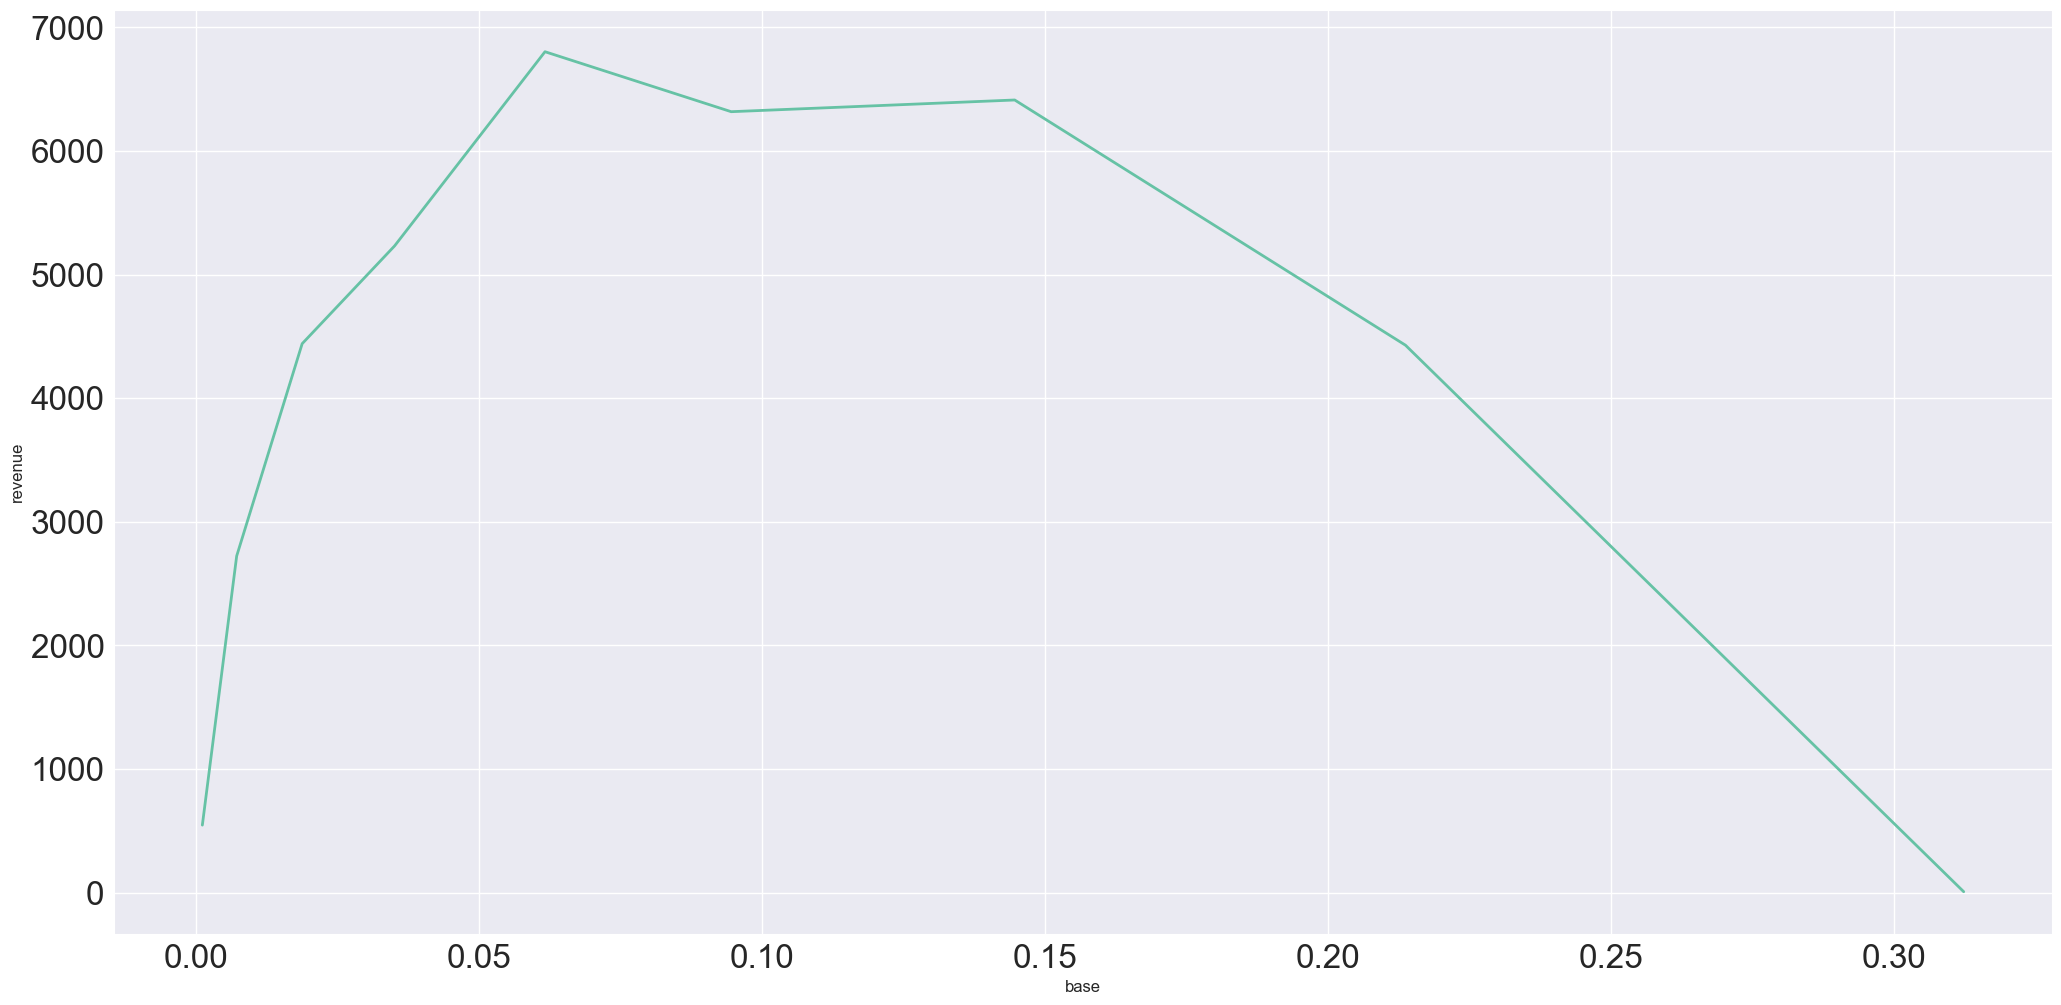

In [644]:
# Seleciona apenas os dados com propensity_score maior ou igual a 0.1
aux = df[df['propensity_score'] >= 0.1]

# Criação do gráfico de linha
sns.lineplot(x='base', y='revenue', data=aux)


<AxesSubplot: title={'center': 'Best K for the Biggest Profit'}, xlabel='Percentage of sample', ylabel='Profit'>

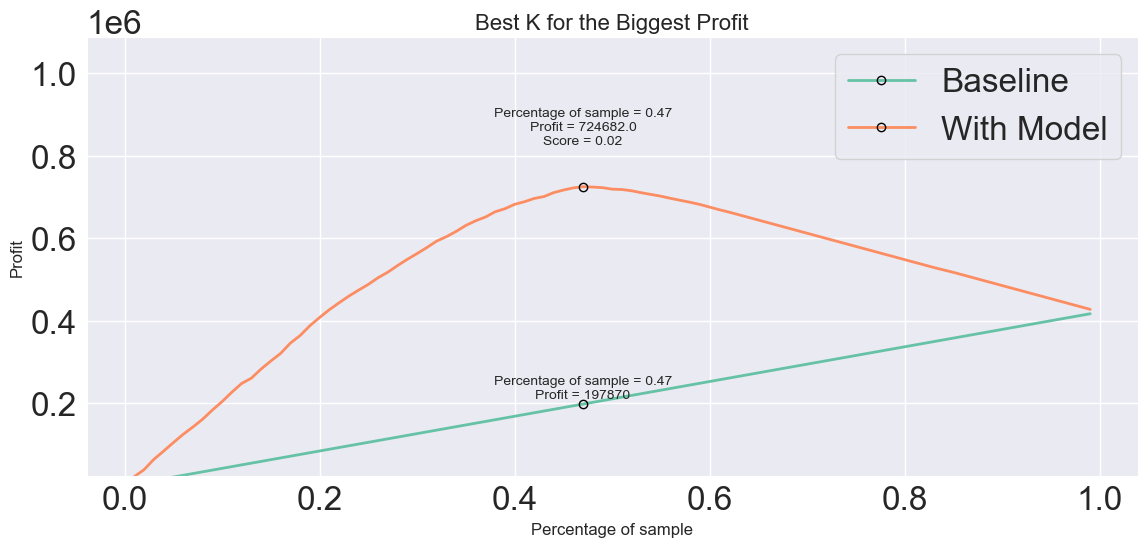

In [781]:
# Define o preço do seguro e o custo por cliente
insurance_price = 550
cost = 40

# Calcula o dataframe de lucro
df_profit = profit_dataframe(df8, insurance_price, cost)

# Plota o gráfico de lucro
line_profit(df_profit)



<AxesSubplot: title={'center': 'Profit: Selected Customers X All Customers'}, ylabel='Profit'>

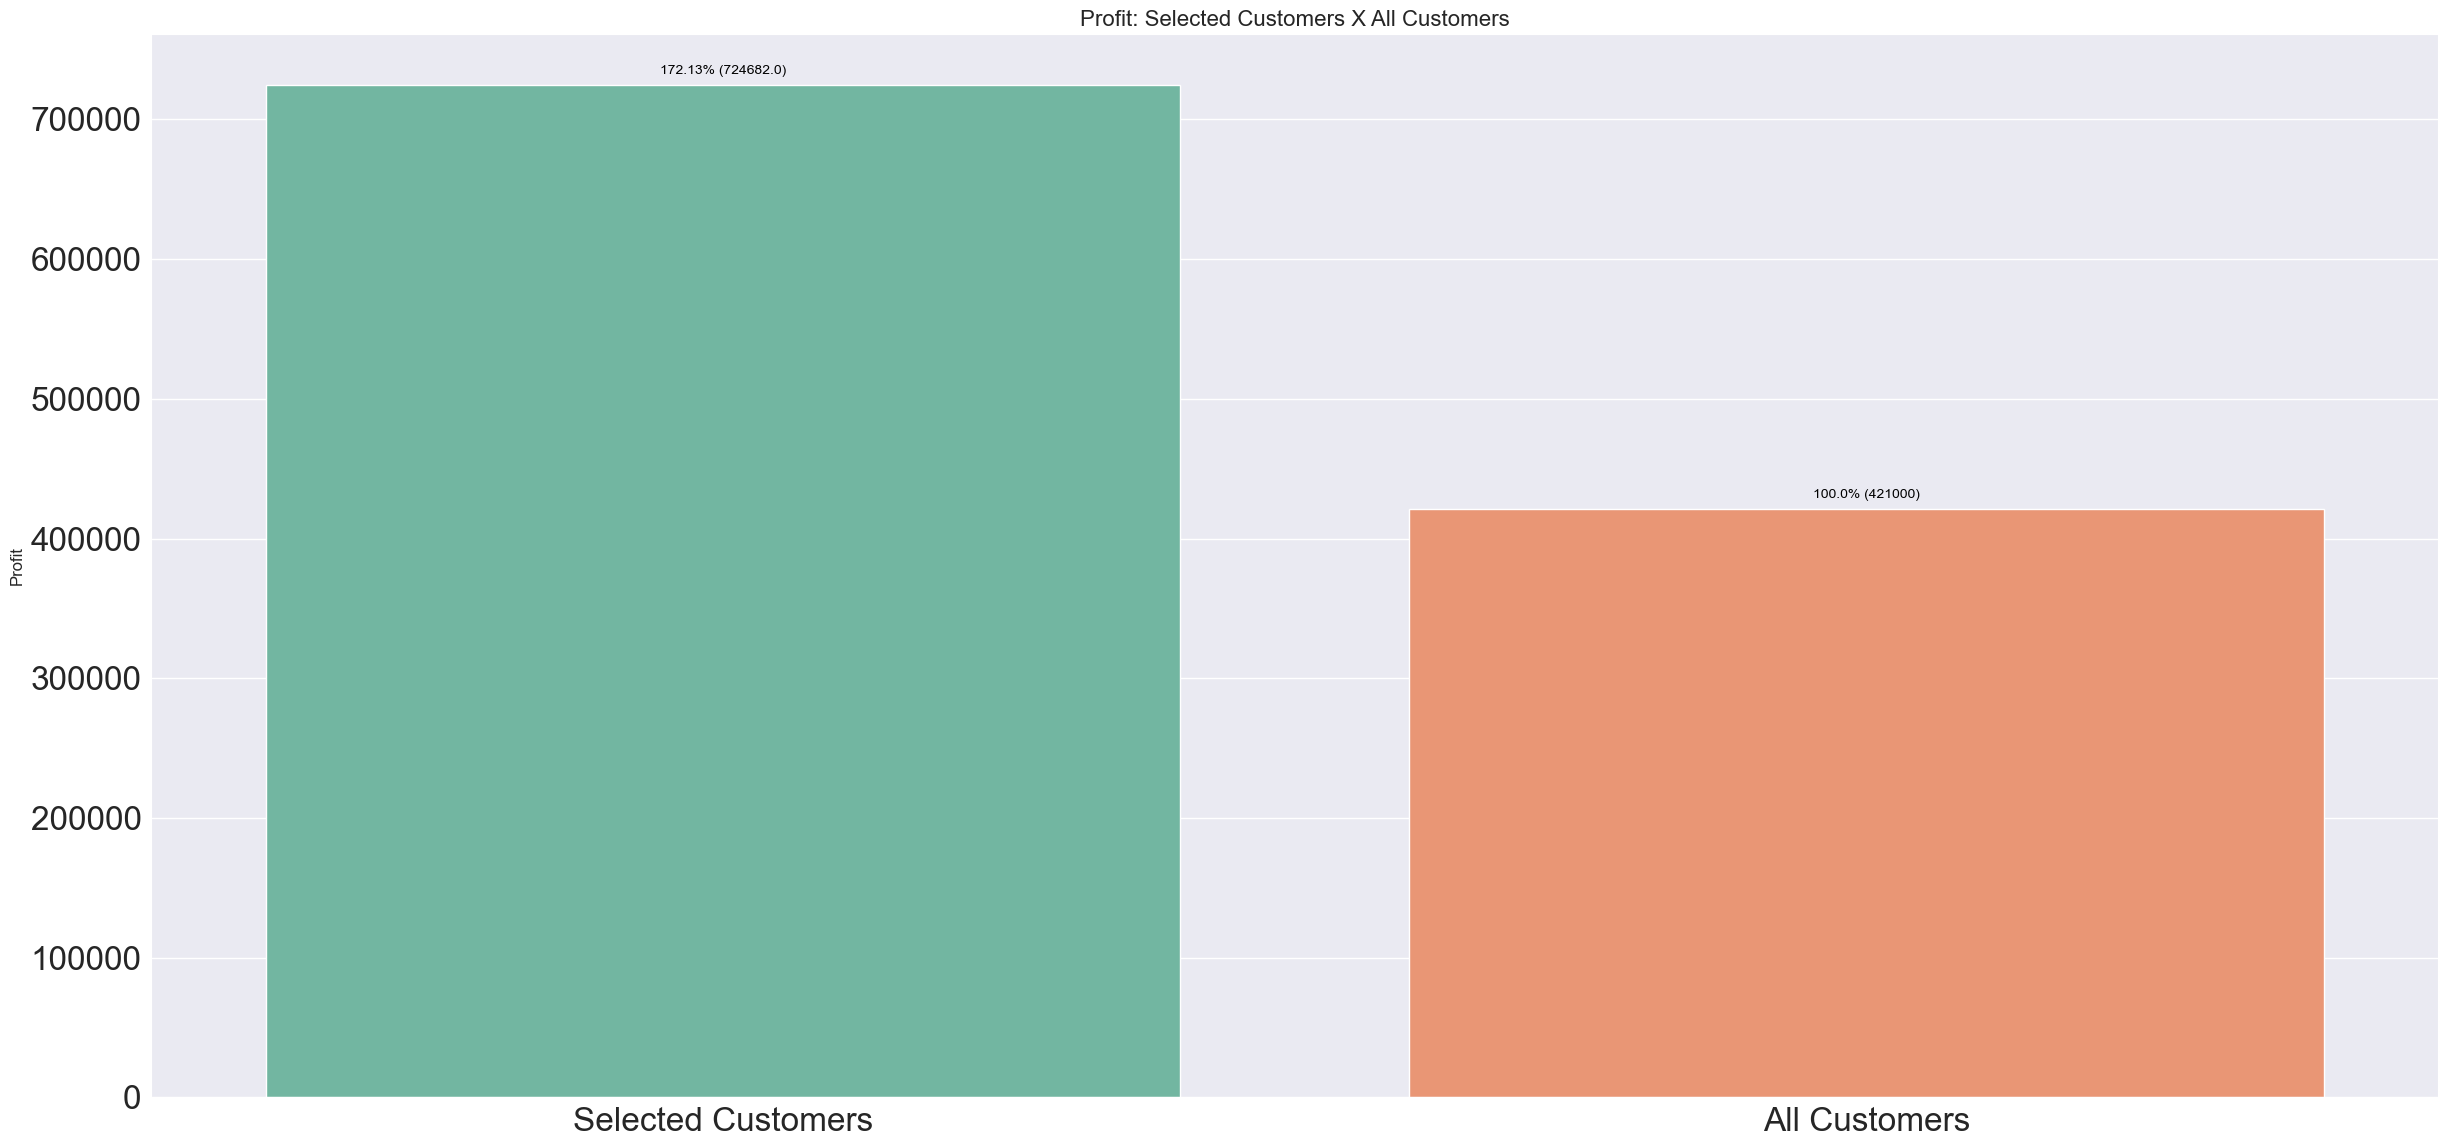

In [782]:
# Plota o gráfico de barras de lucro
profit_bar(df_profit, df8, insurance_price, cost)

# 10.0. Deploy to Production

In [727]:
# Salva o modelo treinado
#pickle.dump(et, open('C:\\Users\\raquel\\Documents\\Comunidade DS\\repos\\06-PA-Health-Insurance-Cross-Sell\\health_insurance_ross_sell\\src\\models\\model_health_insurance.pkl', 'wb'))
pickle.dump(xgb_model_tuned_bs, open(r'C:\Users\raquel\Documents\Comunidade DS\repos\06-PA-Health-Insurance-Cross-Sell\health_insurance\health_insurance\src\models\model_xgb_tuned_bs.pkl', 'wb'))

## 10.1. Health Insurance Class

In [728]:
import pickle
import numpy  as np
import pandas as pd

class HealthInsurance:
    
    def __init__(self):
        # Definindo o caminho dos arquivos do projeto
        self.home_path = 'C:\\Users\\raquel\\Documents\\Comunidade DS\\repos\\06-PA-Health-Insurance-Cross-Sell\\health_insurance_ross_sell\\'
        
        # Carregando os objetos scaler gerados no treinamento do modelo
        self.annual_premium_scaler =            pickle.load(open(self.home_path + 'src\\features\\annual_premium_scaler.pkl', 'rb'))
        self.age_scaler =                       pickle.load(open(self.home_path + 'src\\features\\age_scaler.pkl', 'rb')) 
        self.vintage_scaler =                   pickle.load(open(self.home_path + 'src\\features\\vintage_scaler.pkl', 'rb')) 
        self.target_encode_gender_scaler =      pickle.load(open(self.home_path + 'src\\features\\target_encode_gender_scaler.pkl', 'rb'))
        self.target_encode_region_code_scaler = pickle.load(open(self.home_path + 'src\\features\\target_encode_region_code_scaler.pkl', 'rb'))
        self.fe_policy_sales_channel_scaler =   pickle.load(open(self.home_path + 'src\\features\\fe_policy_sales_channel_scaler.pkl', 'rb'))
        
    def data_cleaning(self, df1):
        # 1.1. Renomeando as colunas
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
                    'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

        df1.columns = cols_new
        
        return df1 

    
    def feature_engineering(self, df2):
        # 2.0. Feature Engineering

        # Criando a coluna 'vehicle_damage_num' para representar os veículos que já foram danificados (1) e os que não foram danificados (0)
        df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

        # Transformando a coluna 'vehicle_age' em uma coluna categórica para aplicação de técnicas de codificação
        df2['vehicle_age'] =  df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year')
        
        return df2
    
    
    def data_preparation(self, df5):
        # Aplicando a transformação de Escalonamento Padrão na coluna 'annual_premium'
        df5['annual_premium'] = self.annual_premium_scaler.transform(df5[['annual_premium']].values)

        # Aplicando a transformação de Escalonamento Mínimo e Máximo na coluna 'age'
        df5['age'] = self.age_scaler.transform(df5[['age']].values)

        # Aplicando a transformação de Escalonamento Mínimo e Máximo na coluna 'vintage'
        df5['vintage'] = self.vintage_scaler.transform(df5[['vintage']].values)

        # Codificando a coluna 'gender' utilizando a técnica de Target Encoding
        df5.loc[:, 'gender'] = df5['gender'].map(self.target_encode_gender_scaler)

        # Aplica o processo de target encoding na coluna region_code
        df5.loc[:, 'region_code'] = df5['region_code'].map(self.target_encode_region_code_scaler)

        # Cria variáveis dummy para a coluna vehicle_age usando a função pd.get_dummies
        df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

        # Aplica o processo de frequency encoding na coluna policy_sales_channel
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(self.fe_policy_sales_channel_scaler)

        # Feature Selection
        # Seleciona as colunas relevantes para o modelo
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

        # Retorna o dataframe com as colunas selecionadas
        return df5[cols_selected]


    def get_prediction(self, model, original_data, test_data):
        # model prediction
        # Usa o modelo treinado para fazer as predições em test_data
        pred = model.predict_proba(test_data)
        
        # join prediction into original data
        # Adiciona as predições ao dataframe original
        original_data['score'] = pred
        
        # Retorna o dataframe em formato JSON
        return original_data.to_json(orient='records', date_format='iso')



## 10.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from HealthInsurance import HealthInsurance

# carregando o modelo
path = 'C:\\Users\\raquel\\Documents\\Comunidade DS\\repos\\06-PA-Health-Insurance-Cross-Sell\\health_insurance_ross_sell\\'
model = pickle.load(open(path + 'src/models/model_health_insurance.pkl', 'rb'))

# inicializando a API
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def health_insurance_predict():
    test_json = request.get_json()

    if test_json: # se houver dados
        if isinstance(test_json, dict): # único exemplo
            test_raw = pd.DataFrame(test_json, index=[0])

        else: # múltiplos exemplos
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        # Instanciando a classe HealthInsurance
        pipeline = HealthInsurance()

        # Limpeza dos dados
        df1 = pipeline.data_cleaning(test_raw)

        # Engenharia de Recursos
        df2 = pipeline.feature_engineering(df1)

        # Preparação dos dados
        df3 = pipeline.data_preparation(df2)

        # Previsão
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response

    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0', debug=True)


ModuleNotFoundError: No module named 'HealthInsurance'

## 10.3. API Tester

In [729]:
import requests
import json

In [736]:
 # loading test dataset
df_test = x_validation
df_test['response'] = y_validation

In [737]:
df_test = df_test.sample(10)

In [738]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [739]:

data = '[{"id": 74147, "gender": "Female", "age": 26, "driving_license": 1, "region_code": 28.0, "previously_insured": 0, "vehicle_age": "between_1_2_year", "vehicle_damage": 1, "annual_premium": 43343.0, "policy_sales_channel": 124.0, "vintage": 288}, {"id": 363080, "gender": "Male", "age": 44, "driving_license": 1, "region_code": 28.0, "previously_insured": 0, "vehicle_age": "between_1_2_year", "vehicle_damage": 0, "annual_premium": 41405.0, "policy_sales_channel": 23.0, "vintage": 279}]'
data


'[{"id": 74147, "gender": "Female", "age": 26, "driving_license": 1, "region_code": 28.0, "previously_insured": 0, "vehicle_age": "between_1_2_year", "vehicle_damage": 1, "annual_premium": 43343.0, "policy_sales_channel": 124.0, "vintage": 288}, {"id": 363080, "gender": "Male", "age": 44, "driving_license": 1, "region_code": 28.0, "previously_insured": 0, "vehicle_age": "between_1_2_year", "vehicle_damage": 0, "annual_premium": 41405.0, "policy_sales_channel": 23.0, "vintage": 279}]'

In [742]:
# API Call
#url = 'http://localhost:5000/predict'
url = 'https://health-insurance-api-amhg.onrender.com/predict'
header = {'Content-type': 'application/json' }

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [741]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1.sort_values('score', ascending=False).head()

id    gender       age  driving_license  region_code  previously_insured   vehicle_age  vehicle_damage  annual_premium  policy_sales_channel   vintage     score
0   74147  0.103451  0.092308                1     0.185227                   0  below_1_year               0        0.744416                 124.0  0.961938  0.031998
1  363080  0.139884  0.369231                1     0.185227                   0  below_1_year               0        0.631572                  23.0  0.930796  0.000452